# Financial Econometrics I: Homework 3
Jan Kubal & Matyáš Mattanelli

## Problem 1

In [1]:
#install.packages(c("fst", "xts", "highfrequency", "stringr", "tseries", "rugarch", "forecast"))
#Loading the packages
suppressPackageStartupMessages({
    library(fst)
    library(xts)
    library(highfrequency)
    library(stringr)
    library(tseries)
    library(rugarch)
    library(forecast)
})

### 1.

Firstly, we load the data for each stock, convert it to an xts object, and then store it in a list. In this way, we do not have to rewrite the code for each stock. The ``xts`` package facilitates the manipulation with time series.

In [3]:
#Loading data
hw3_data <- vector("list", 3) #Empty vector for the data
list_of_files <- list.files("HW_3_data") #Retrieving the file names
stock_names <- str_match(list_of_files, "HW_3_(.*)_")[, 2] #Saving the stock names
for (i in 1:3) {
    data_holder <- read_fst(paste("HW_3_data/", list_of_files[i], sep = "")) #Reading the data
    hw3_data[[i]] <- xts(data_holder$V1, order.by = data_holder$index) #Turning into xts and storing
}

### 2. Restricting data

Given the functionality of the ``xts`` package, we can restrict the series using a simple syntax. 

In [4]:
#Restricting data using xts syntax
hw3_data_restricted <- vector("list", 3) #Empty list for restricted data
for (i in 1:3) {
    data_holder <- hw3_data[[i]]["2012/2016"] #Restricting the years
    hw3_data_restricted[[i]] <- data_holder["T09:30/T16:00"] #Restricting NYSE trading hours
}

### 3. Getting intraday 1-minute returns

To calculate the intraday returns, we firstly adjust the ``makeReturns`` function to set the first observation to NA rather than zero since we do not want to bias the results (even though the calculation of Realized Variance should not be affected). We then apply the function on the data split into individual days. Lastly, we merge the series back together. 

In [5]:
#Calculating intraday returns
hw3_data_final <- vector("list", 3) #Empty vector for final data
makeReturns_adjusted <- function(xts_object) { #A function to prevent the makeReturns function to set first row to zero
    result <- makeReturns(xts_object) #Call the function and save the resulting returns
    result[1] <- NA #Replace the zero in first row with NA
    return(result)
}
for (i in 1:3) { #Looping through the stocks
    days <- split(hw3_data_restricted[[i]], f = "days") #Splitting the series into days
    intraday_returns <- lapply(X = days, FUN = makeReturns_adjusted) #Calculating the returns for each day
    hw3_data_final[[i]] <- do.call(rbind.xts, intraday_returns) #Concatenating the series
}

### 4. Examining the behavior of rCov() function

In order to inspect the behavior of the ``rCov`` function, we firstly calculate the Realized Variance from raw prices setting ``makeReturns=TRUE``.

In [6]:
#Calculating the Realized Variance from prices
real_var_from_prices <- vector("list", 3) #Empty vector for the results
for (i in 1:3) {#Looping through the tickers
    real_var_from_prices[[i]] <- rCov(hw3_data_restricted[[i]], makeReturns = TRUE)
}

Then we calculate RV from manually calculated returns...

In [7]:
#Calculating the Realized Variance from returns
real_var_from_returns <- vector("list", 3) #Empty vector for the results
for (i in 1:3) {#Looping through the tickers
    real_var_from_returns[[i]] <- rCov(na.omit(hw3_data_final[[i]]), makeReturns = FALSE) #Have to omit NAs in order for the function to work
}

...and compare the results.

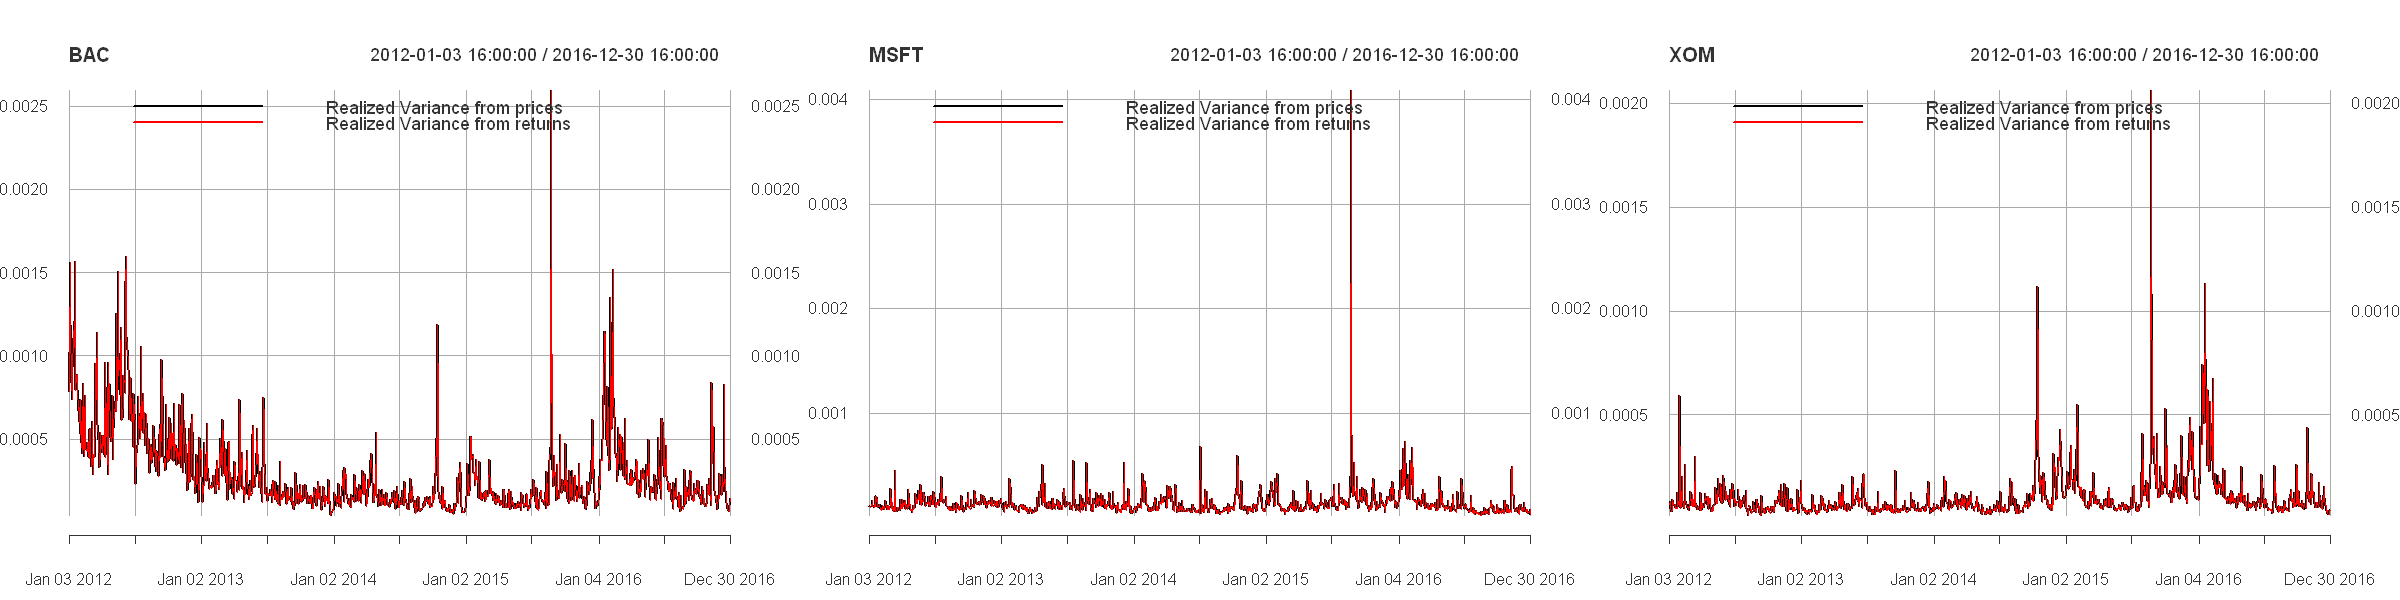

In [8]:
#Plotting the results
par(mfrow = c(1, 3)) #Setting up the grid
options(repr.plot.width = 20, repr.plot.height = 5) #Enlarging the plot
for (i in 1:3) {#Looping through the stocks
    plot_holder <- plot(real_var_from_prices[[i]], main = stock_names[i]) #Plotting Realized Variance calculated from prices
    plot_holder <- lines(real_var_from_returns[[i]], col = "red") #Adding Realized Variance calculated from returns for comparison
    plot_holder <- addLegend("topleft", on = 1, legend.names = c("Realized Variance from prices", "Realized Variance from returns"), col = c("black", "red"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}

A first glance suggests that the series are identical. We can verify that by plotting their difference.

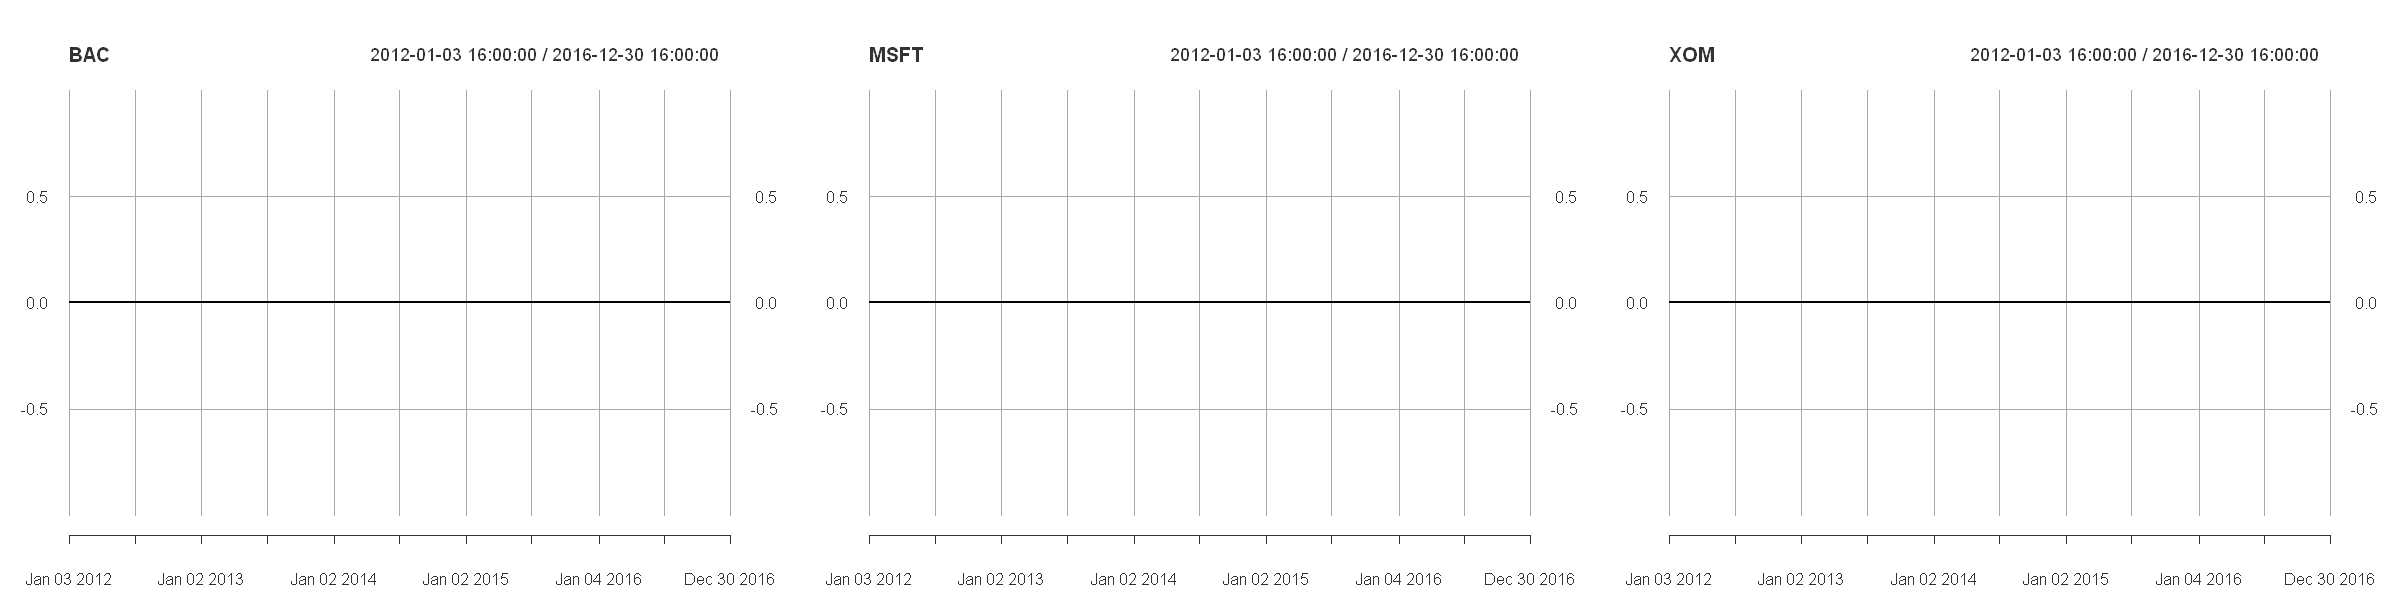

In [9]:
#Plotting the differences
par(mfrow = c(1, 3))
for (i in 1:3) {
    print(plot(real_var_from_prices[[i]] - real_var_from_returns[[i]], main = stock_names[i]))
}

There does not seem to be a difference. That would imply that both procedures arrive to identical results.

### 5. Realized Variance for intraday sub-periods

In this task, we split the previously calculated returns into the given periods and then compute the Realized Variance for each subset.

In [10]:
#Calculating Realized Variance for the sub-periods
real_var_subsets <- vector("list", 3) #Empty vector for the results
sub_periods <- c("T09:30/T10:59", "T11:00/T14:29", "T14:30/T16:00") #Saving the sub-periods to subset
for (i in 1:3) { #Looping through the tickers
    real_var_subsets_indiv <- vector("list", 3) #Empty list for the results for each ticker
    for (j in 1:3) { #Looping through the sub-periods
        real_var_subsets_indiv[[j]] <- rCov(na.omit(hw3_data_final[[i]][sub_periods[j]]), makeReturns = FALSE) #Calculating RV from the subset
    }
    real_var_subsets[[i]] <- real_var_subsets_indiv #Storing the results
}

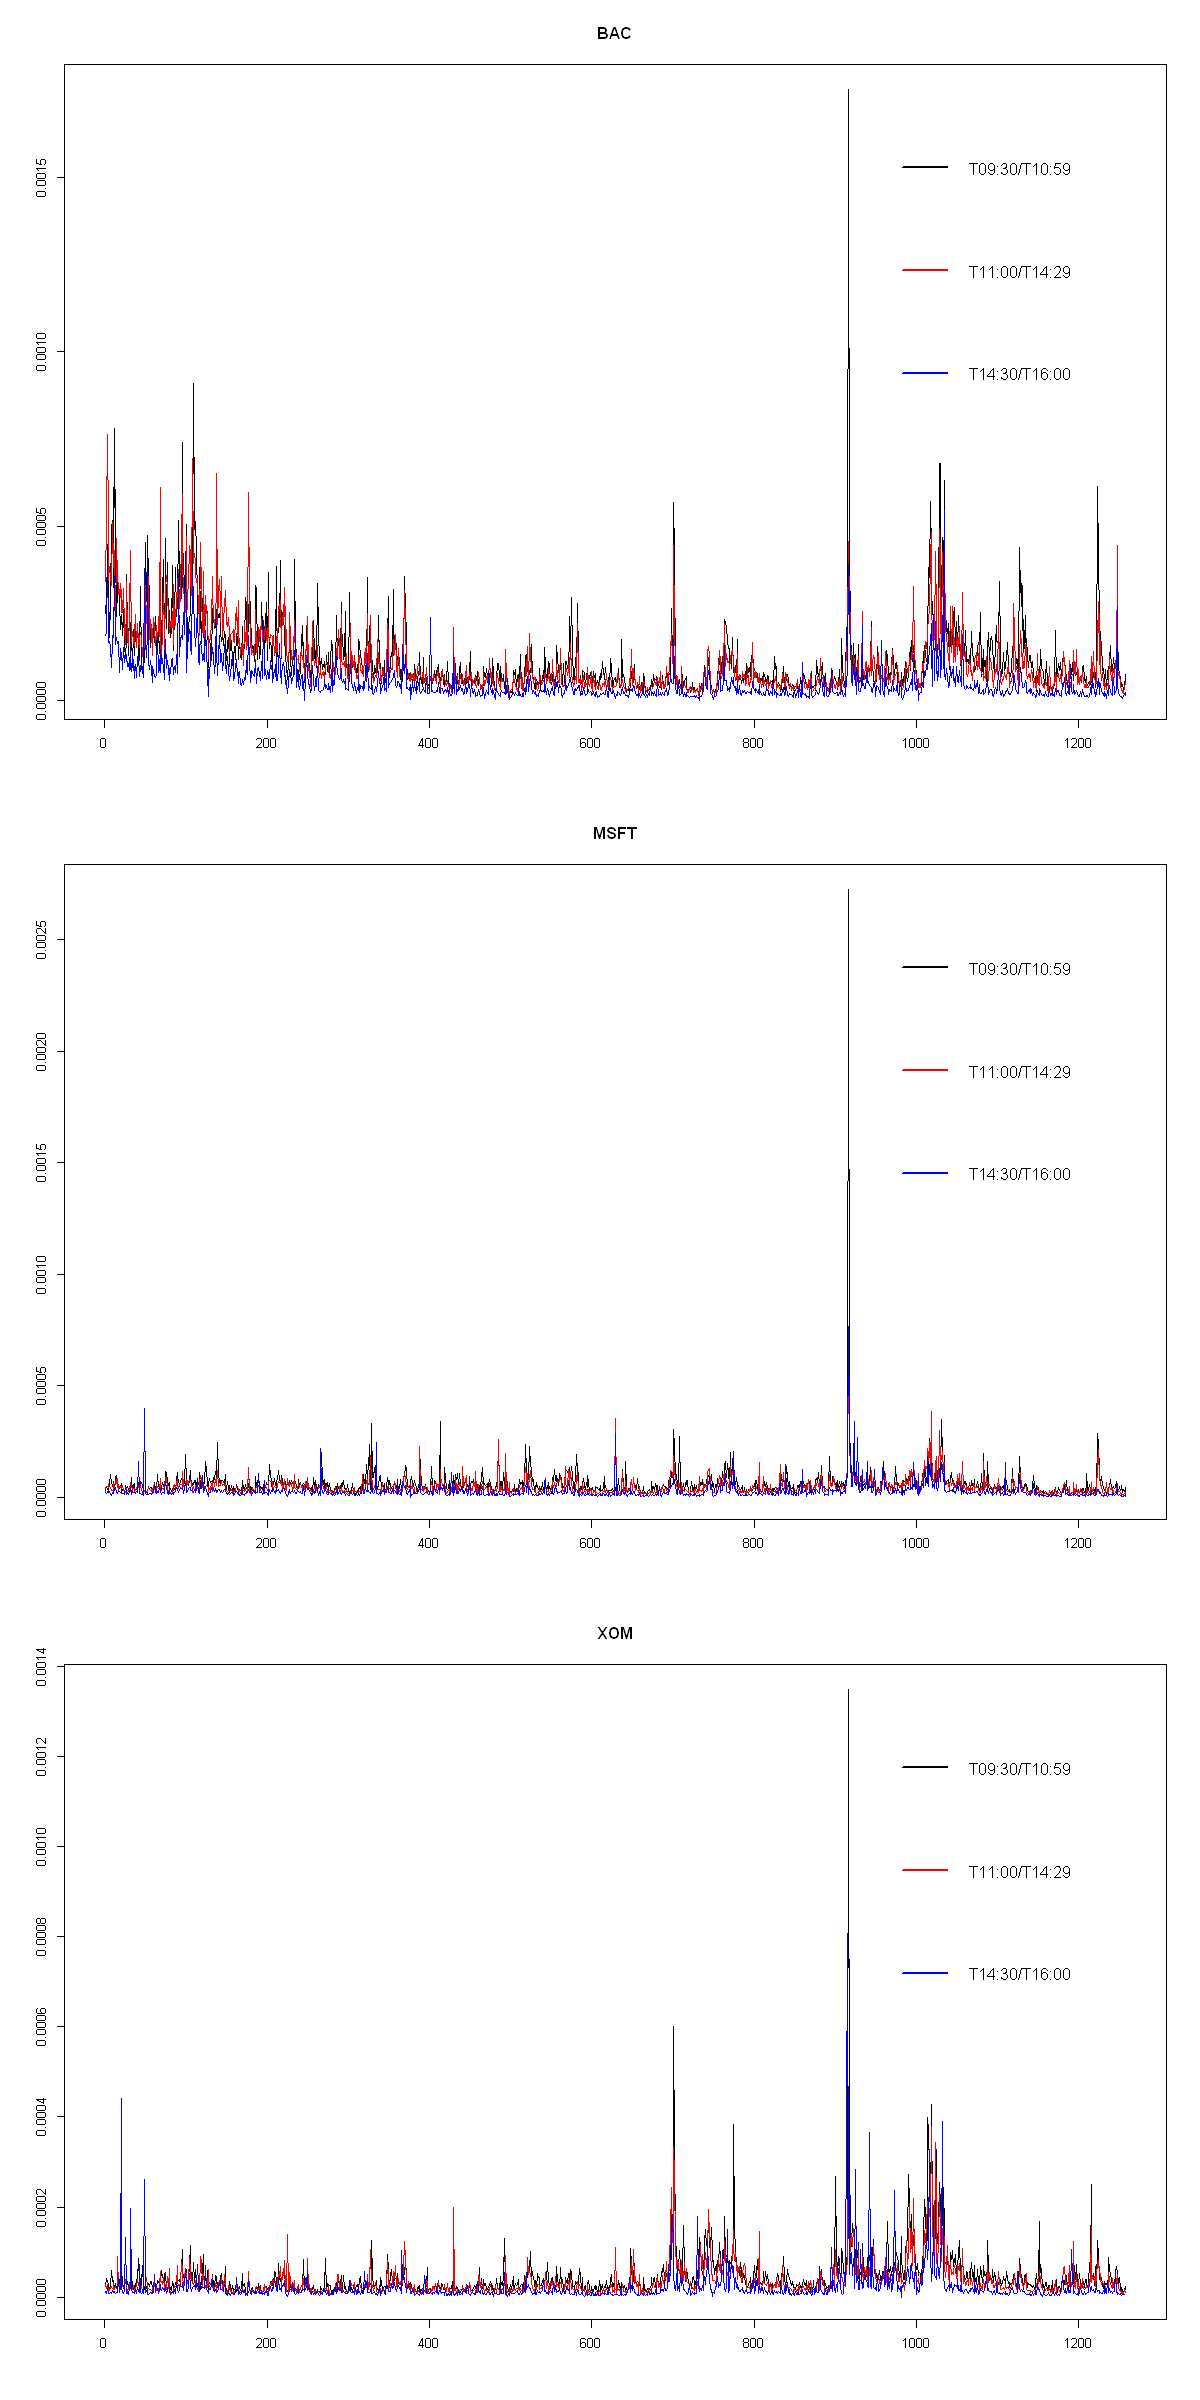

In [11]:
#Plotting
options(repr.plot.width = 10, repr.plot.height = 20)
par(mfrow = c(3, 1)) #Setting up the grid
for (i in 1:3) { #Looping through the tickers
    plot(as.numeric(real_var_subsets[[i]][[1]]), type = "l", xlab = "", ylab = "", main = stock_names[i])
    lines(as.numeric(real_var_subsets[[i]][[2]]), col = "red")
    lines(as.numeric(real_var_subsets[[i]][[3]]), col = "blue")
    legend("topright", sub_periods, col = c("black", "red", "blue"), lty = 1, bty = "n", cex = 1.2, lwd = 2)
}


It is difficult to deduce much from the plots but we could see that, for example, the Realized Variance of BAC seems to be systematically lower in the afternoon.

### 6.

Now, we simply sum the intraday returns for each day.

In [12]:
#Calculating the sum of intraday RV
sum_intraday_RV <- vector("list", 3) #Empty list for sums of intraday RV
for (i in 1:3) { #Looping through the tickers
    time_removed <- lapply(real_var_subsets[[i]], to.daily, OHLC = F) #Removing the time stamp from each subset for easier handling
    subsets_merged <- merge.xts(time_removed[[1]], time_removed[[2]], time_removed[[3]]) #Merging the subsets into a single xts object
    sum_intraday_RV[[i]] <- apply.daily(subsets_merged, sum) #Summing RV for each day
}
#Removing the time stamp from daily RV for easier plotting
daily_RV <- lapply(real_var_from_returns, to.daily, OHLC = F)

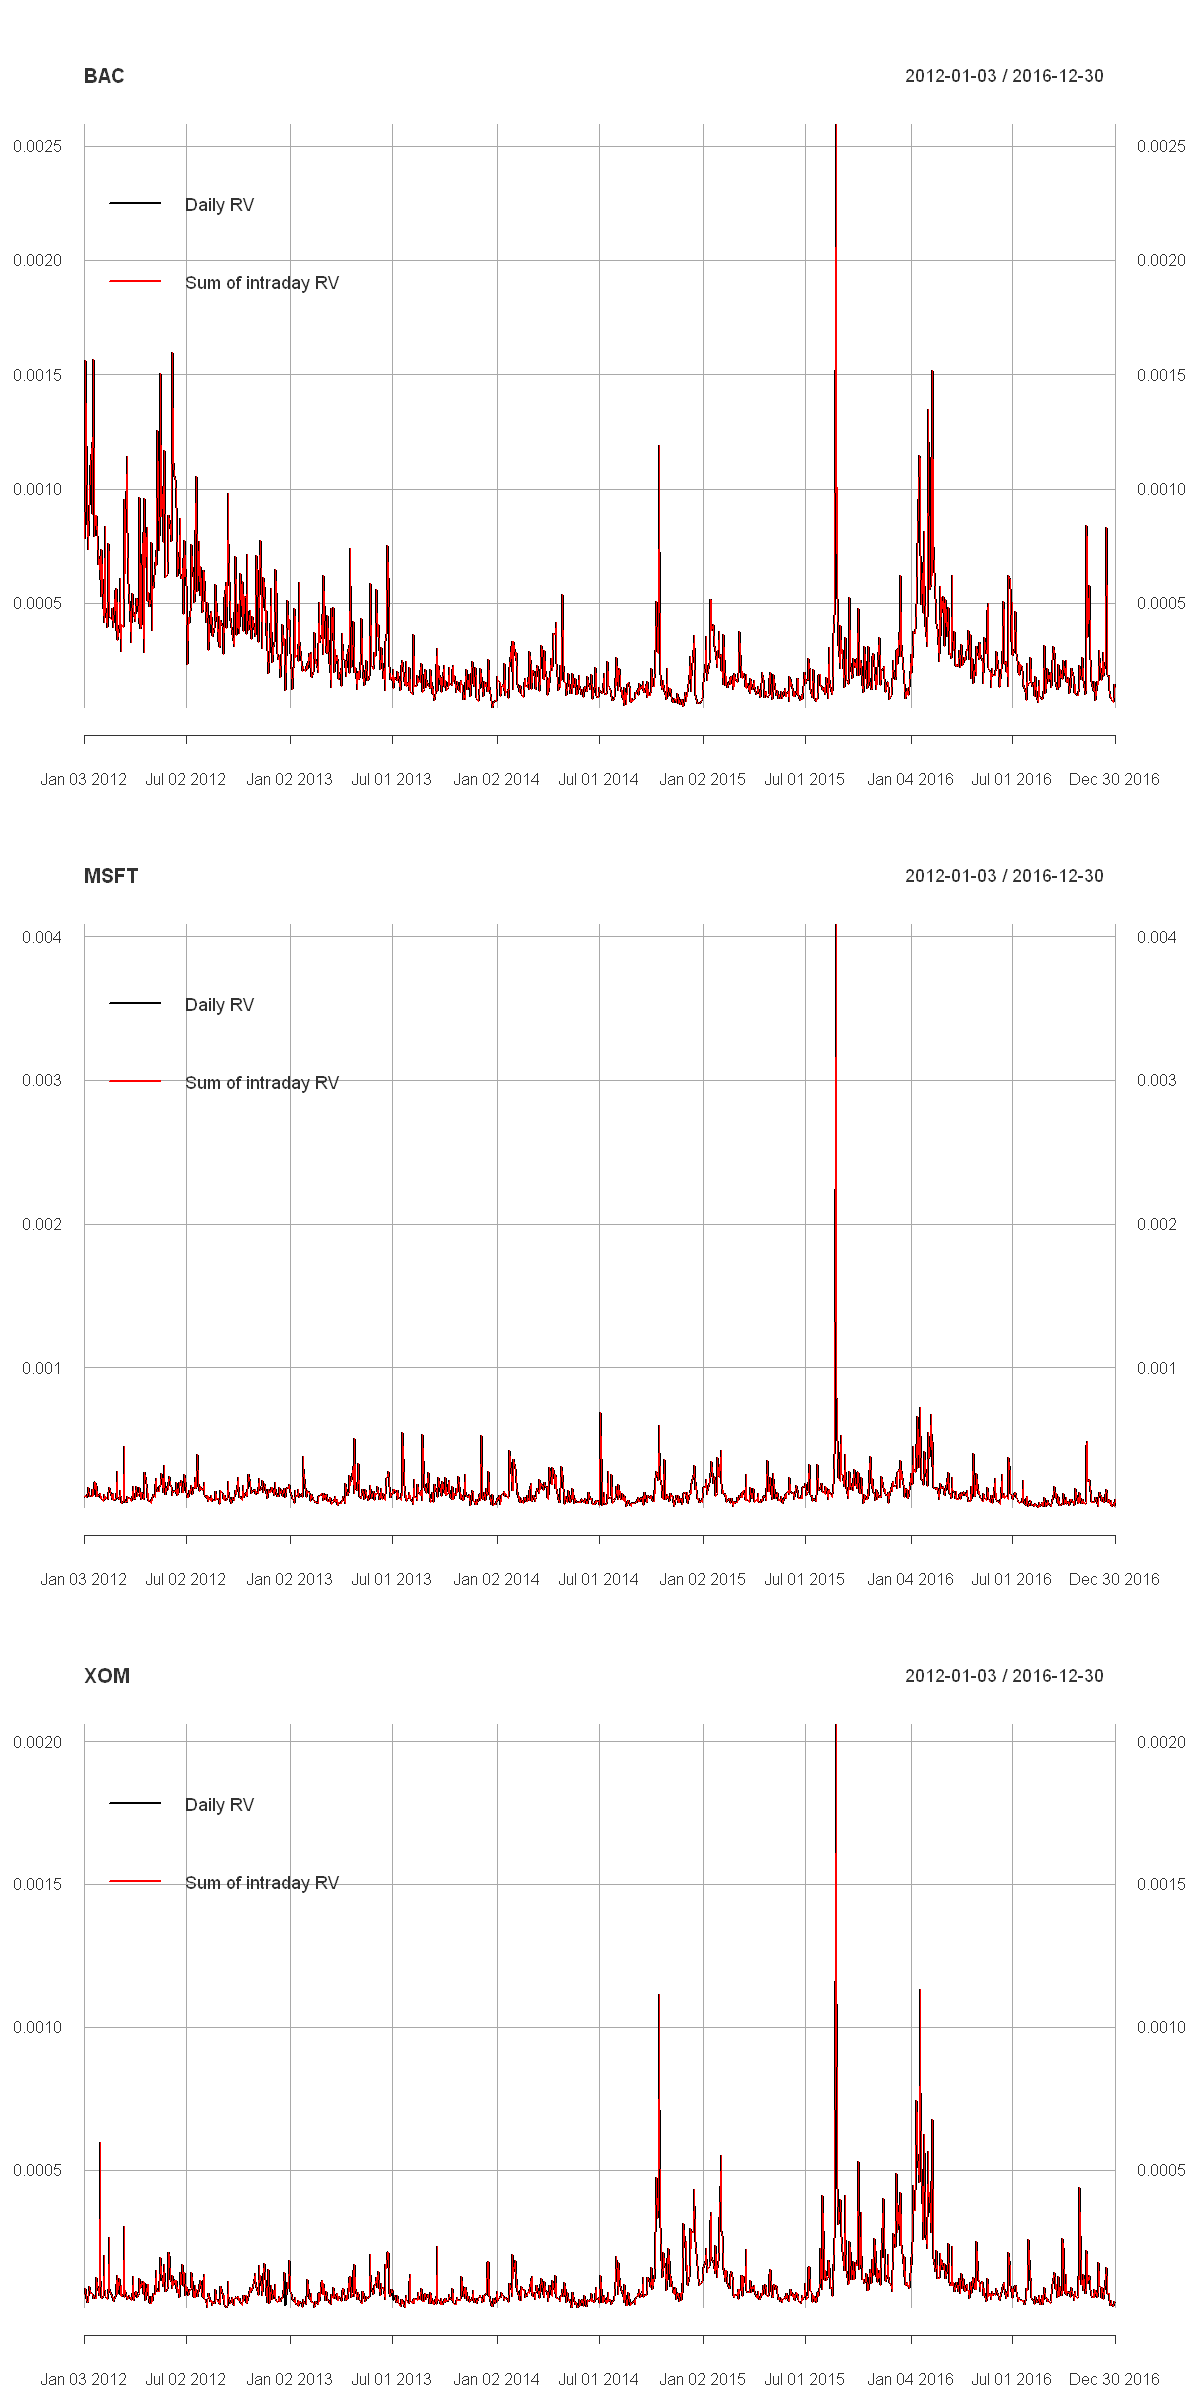

In [13]:
#Plotting
par(mfrow = c(3, 1)) #Setting up the grid
for (i in 1:3) { #Looping through the tickers
    plot_holder <- plot(daily_RV[[i]], main = stock_names[i])
    plot_holder <- lines(sum_intraday_RV[[i]], col = "red")
    plot_holder <- addLegend("topleft", on = 1, legend.names = c("Daily RV", "Sum of intraday RV"), col = c("black", "red"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}

The first peek at the plots does not uncover any substantial dissimilarities. To get a better insight, we will take a look at the difference of the series.

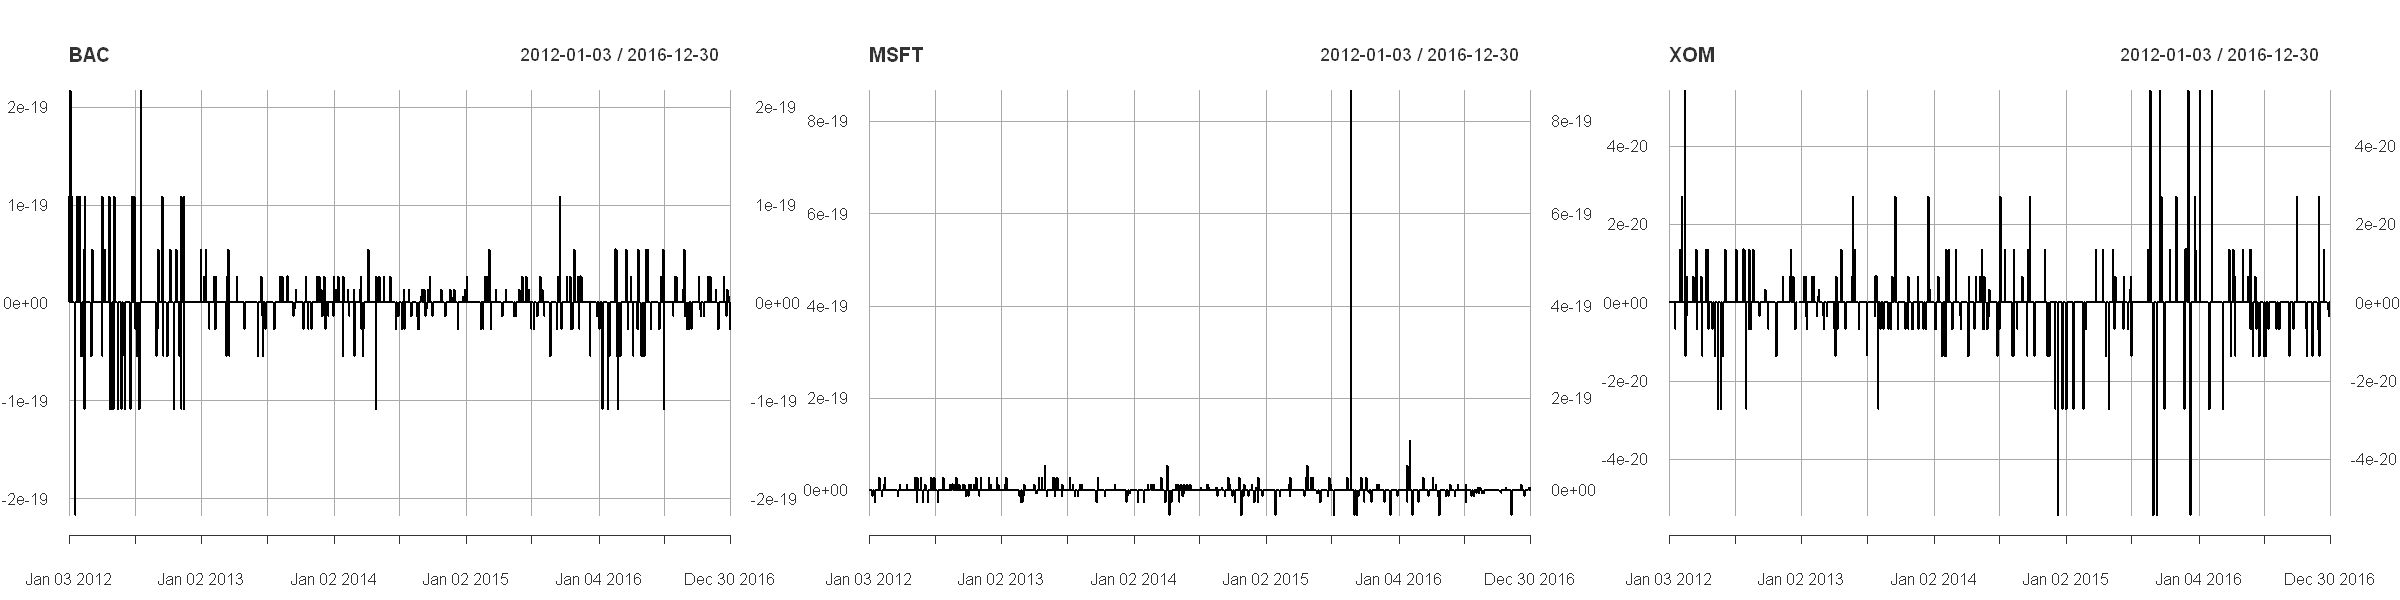

In [14]:
#Plotting the difference
options(repr.plot.width = 20, repr.plot.height = 5) #Enlarging the plot
par(mfrow = c(1, 3)) #Setting up the grid
for (i in 1:3) { #Looping through the tickers
    print(plot(daily_RV[[i]] - sum_intraday_RV[[i]], main = stock_names[i]))
}

As can be seen, there appear to be some differences. However, one needs to consider the size of the numbers. Since they are negligibly small, they could simply be assigned to a rounding error.

### 7.

In this section, we calculate the contribution of each sub-period to the overall daily RV and then plot the results using a stacked barplot.

In [15]:
#Calculating the percentage share of each intrady RV in daily RV
percentage_shares <- vector("list", 3) #Empty vector for the results
for (i in 1:3) { #Looping through the tickers
    time_removed <- lapply(real_var_subsets[[i]], to.daily, OHLC = F) #Removing the time stamp from each subset for easier handling
    percentage_shares_list <- lapply(time_removed, function(x) {x / daily_RV[[i]]}) #Calculating the shares for each subset
    percentage_shares[[i]] <- merge.xts(percentage_shares_list[[1]], percentage_shares_list[[2]], percentage_shares_list[[3]]) #Merging the results into a single xts object (3 shares per day)
    names(percentage_shares[[i]]) <- sub_periods #Renaming the series for plotting
}

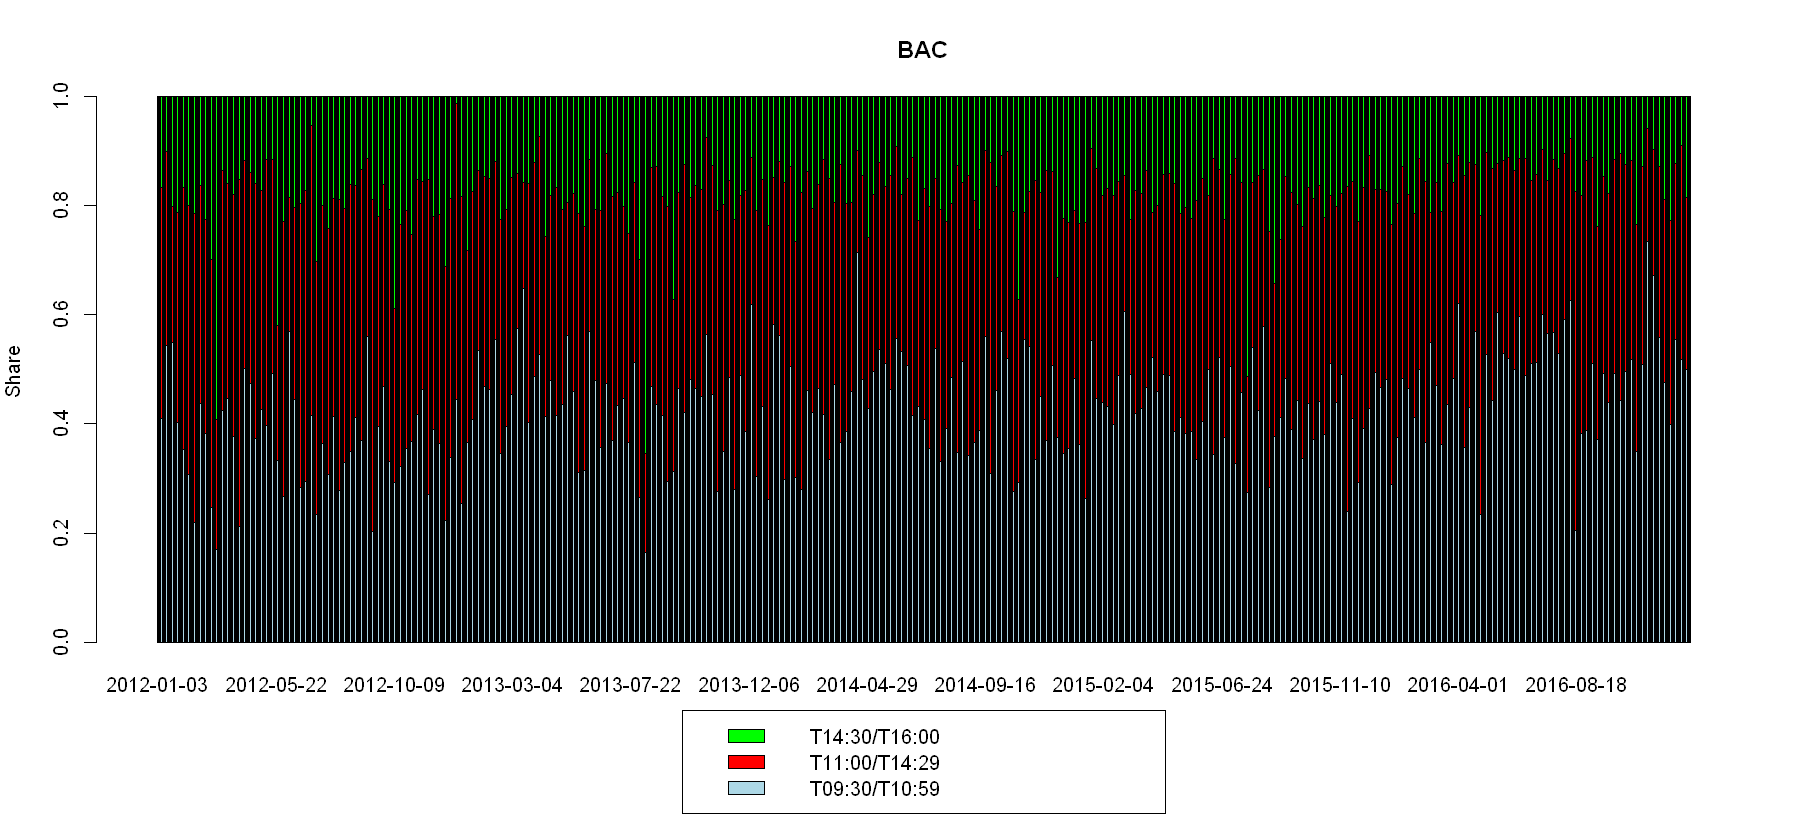

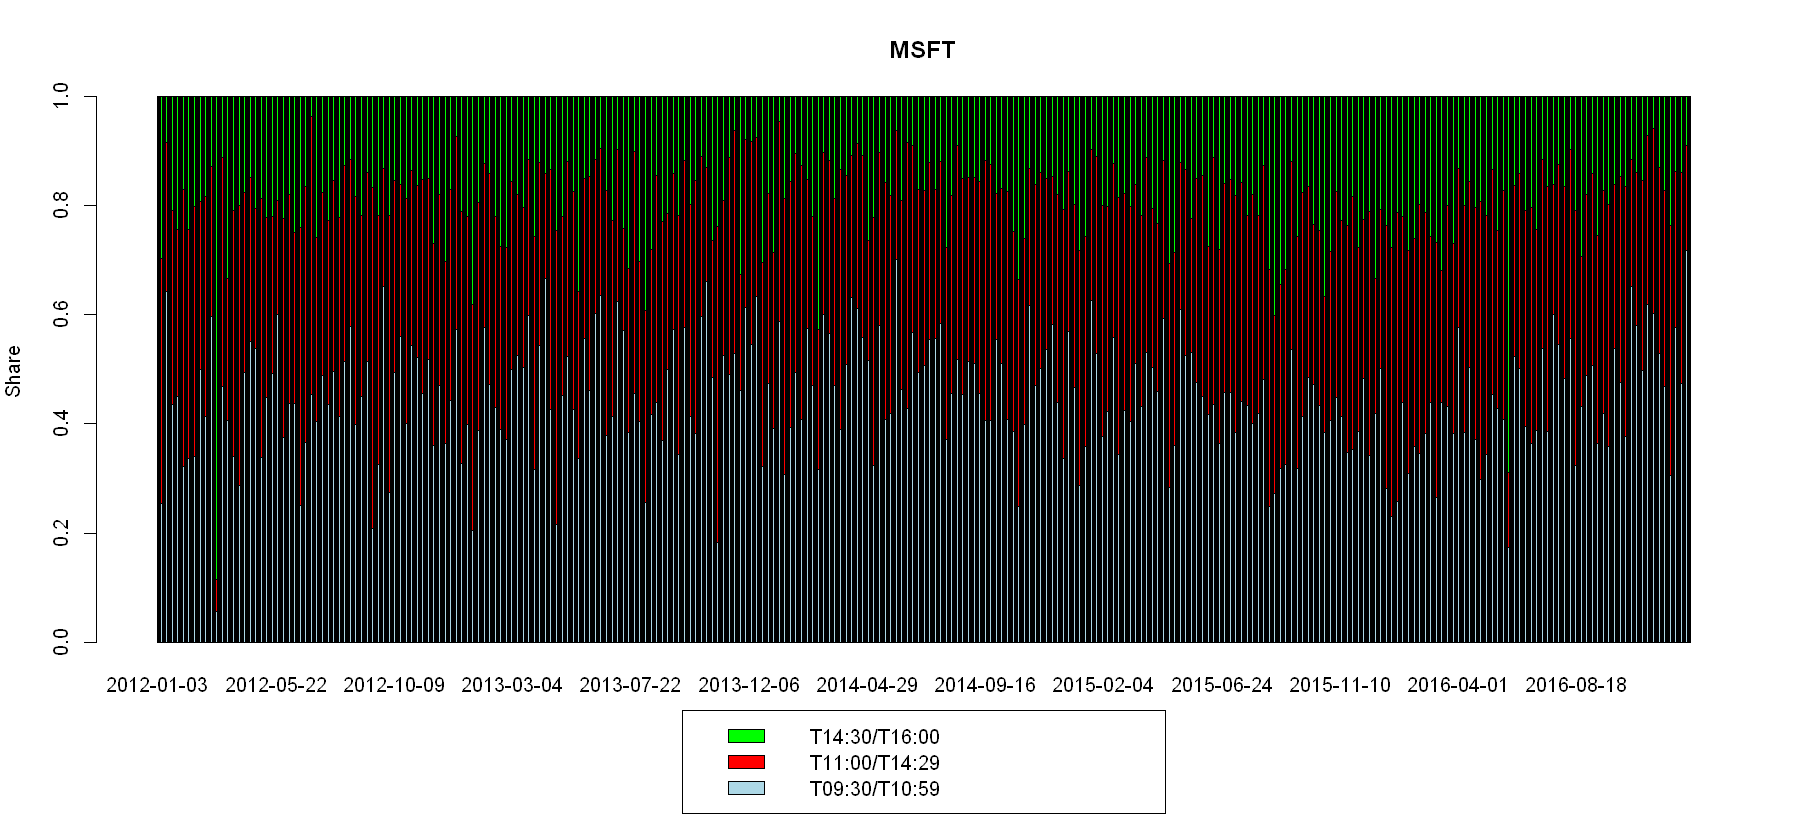

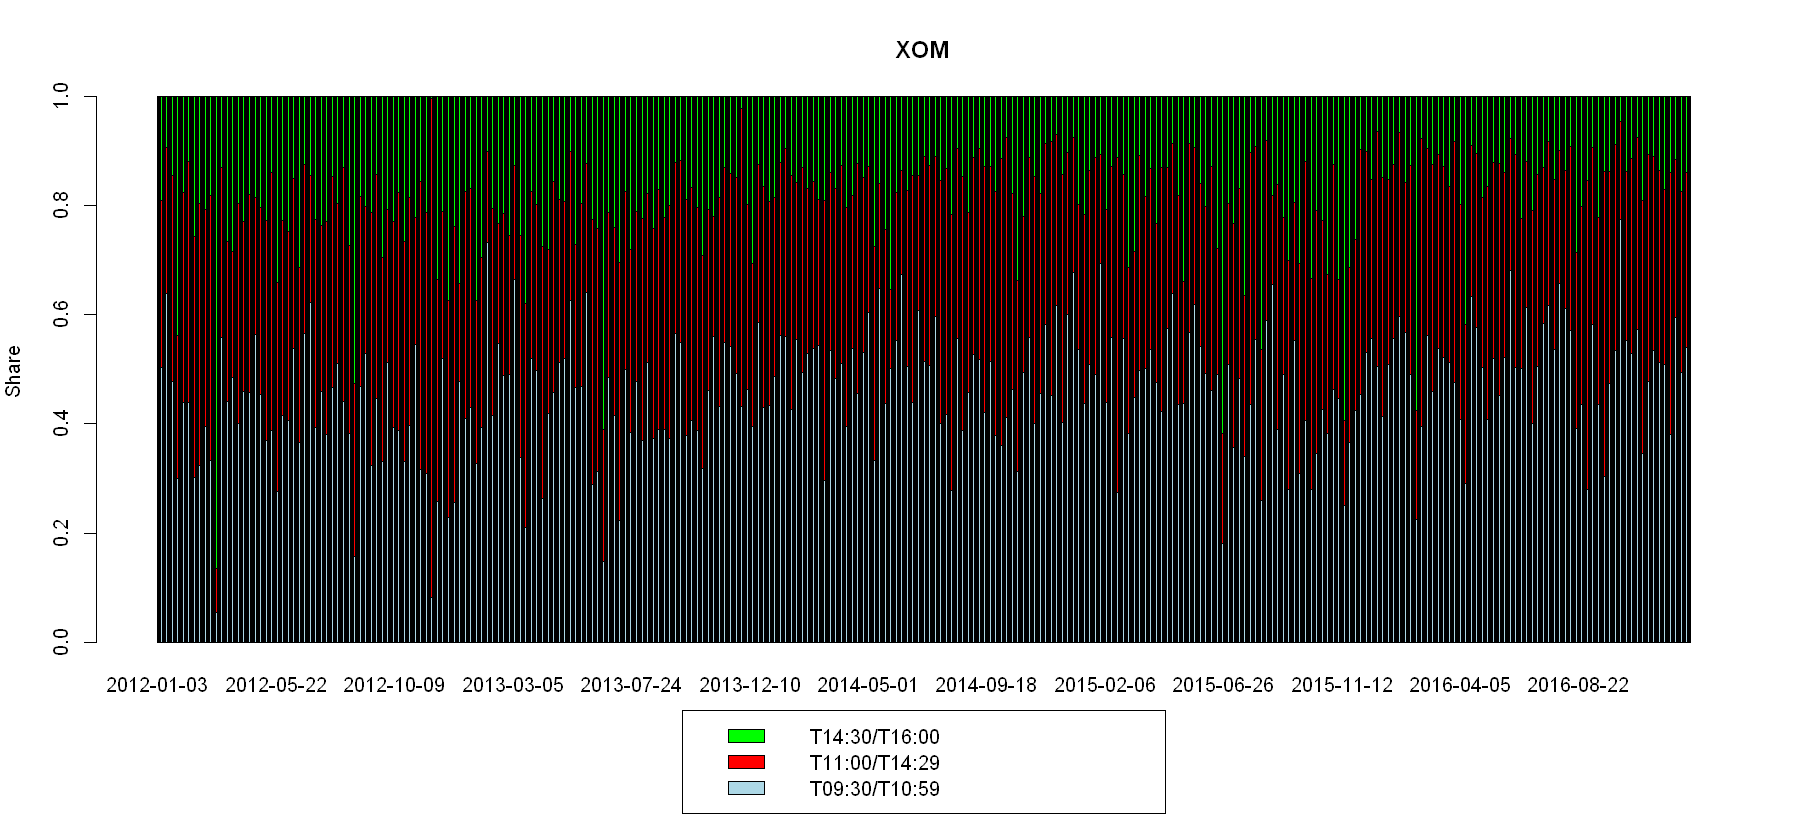

In [16]:
#Plotting
options(repr.plot.width = 15, repr.plot.height = 7)
par(mar = c(8, 4, 4, 2)) #Making a space for the legend
for (i in 1:3) { #Looping through the tickers
    barplot(na.omit(percentage_shares[[i]]), col = c("lightblue", "red", "green"), space = 0, main = stock_names[i], ylab = "Share", legend = T, args.legend = list(x = "bottom", inset = -0.3)) #Omitting 2 NAs that emerged in XOM after merging
}

As the charts suggest, the first period appears to have the greatest contribution to the daily Realized Variance. On the other hand, the afternoon hours contribute the lowest. This is something we observed in one of the previous sections. We can support our findings further by calculating the average share for each sub-period over all available days.

In [17]:
#Average share of intrady RV for each sub-period
for (i in 1:3) { #Looping through the stocks
    print(stock_names[i])
    for (j in 1:3) { #Looping through the sub-periods
        print(paste(sub_periods[j], ": ", mean(percentage_shares[[i]][, j], na.rm = T)))
    }
}

[1] "BAC"
[1] "T09:30/T10:59 :  0.430930095930397"
[1] "T11:00/T14:29 :  0.390920554565582"
[1] "T14:30/T16:00 :  0.178149349504021"
[1] "MSFT"
[1] "T09:30/T10:59 :  0.451527613954206"
[1] "T11:00/T14:29 :  0.356041034455285"
[1] "T14:30/T16:00 :  0.192431351590508"
[1] "XOM"
[1] "T09:30/T10:59 :  0.454940178027377"
[1] "T11:00/T14:29 :  0.351723647957707"
[1] "T14:30/T16:00 :  0.193644034164621"


And our observations seem to be confirmed. For all stocks, the average Realized Variance is largest in the morning and lowest in the afternoon.

### 8.

Now, we simply repeat the procedure from 5, 6, and 7 using raw prices. However, firstly, we need to make sure that we have at least two observations for each period within each day since otherwise it is impossible to calculate the returns. If we found such a day, we remove it since the ``makeReturns`` function cannot handle it on its own.

In [18]:
#Checking the number of observations for each sub-period within each day
for (i in 1:3) { #Looping through the tickers
    for (j in 1:3) { #Looping throught the sub-periods
        days_holder <- split(hw3_data_restricted[[i]][sub_periods[j]], "days") #Splitting the sub-periods by days 
        for (k in days_holder) { #For each day
            if (length(k) == 1) { #If there is only a single day
                index_to_remove <- which(index(hw3_data_restricted[[i]]) == as.POSIXct(index(k), tz = "UTC")) #Extract the index to remove
                hw3_data_restricted[[i]] <- hw3_data_restricted[[i]][-index_to_remove] #Remove the specific observation
                print(paste("Removed observation", index(k), "from sub-period", sub_periods[j], "from ticker", stock_names[i])) #Print what was removed
            }
        }
    }
}

[1] "Removed observation 2013-11-29 15:56:00 from sub-period T14:30/T16:00 from ticker MSFT"
[1] "Removed observation 2015-12-24 14:49:00 from sub-period T14:30/T16:00 from ticker MSFT"


As can bee seen, we had to disregard two observations for the MSFT stock. Finally, we can calculate the Realized Variance using raw prices and setting ``makeReturns=TRUE``

In [19]:
#Calculating Realized Variance for the sub-periods
real_var_subsets_from_prices <- vector("list", 3) #Empty vector for the results
for (i in 1:3) { #Looping through the tickers
    real_var_subsets_from_prices_indiv <- vector("list", 3) #Empty list for the results for each ticker
    for (j in 1:3) { #Looping through the sub-periods
        real_var_subsets_from_prices_indiv[[j]] <- rCov(hw3_data_restricted[[i]][sub_periods[j]], makeReturns = TRUE) #Calculating RV on the subset
    }
    real_var_subsets_from_prices[[i]] <- real_var_subsets_from_prices_indiv #Storing the results
}

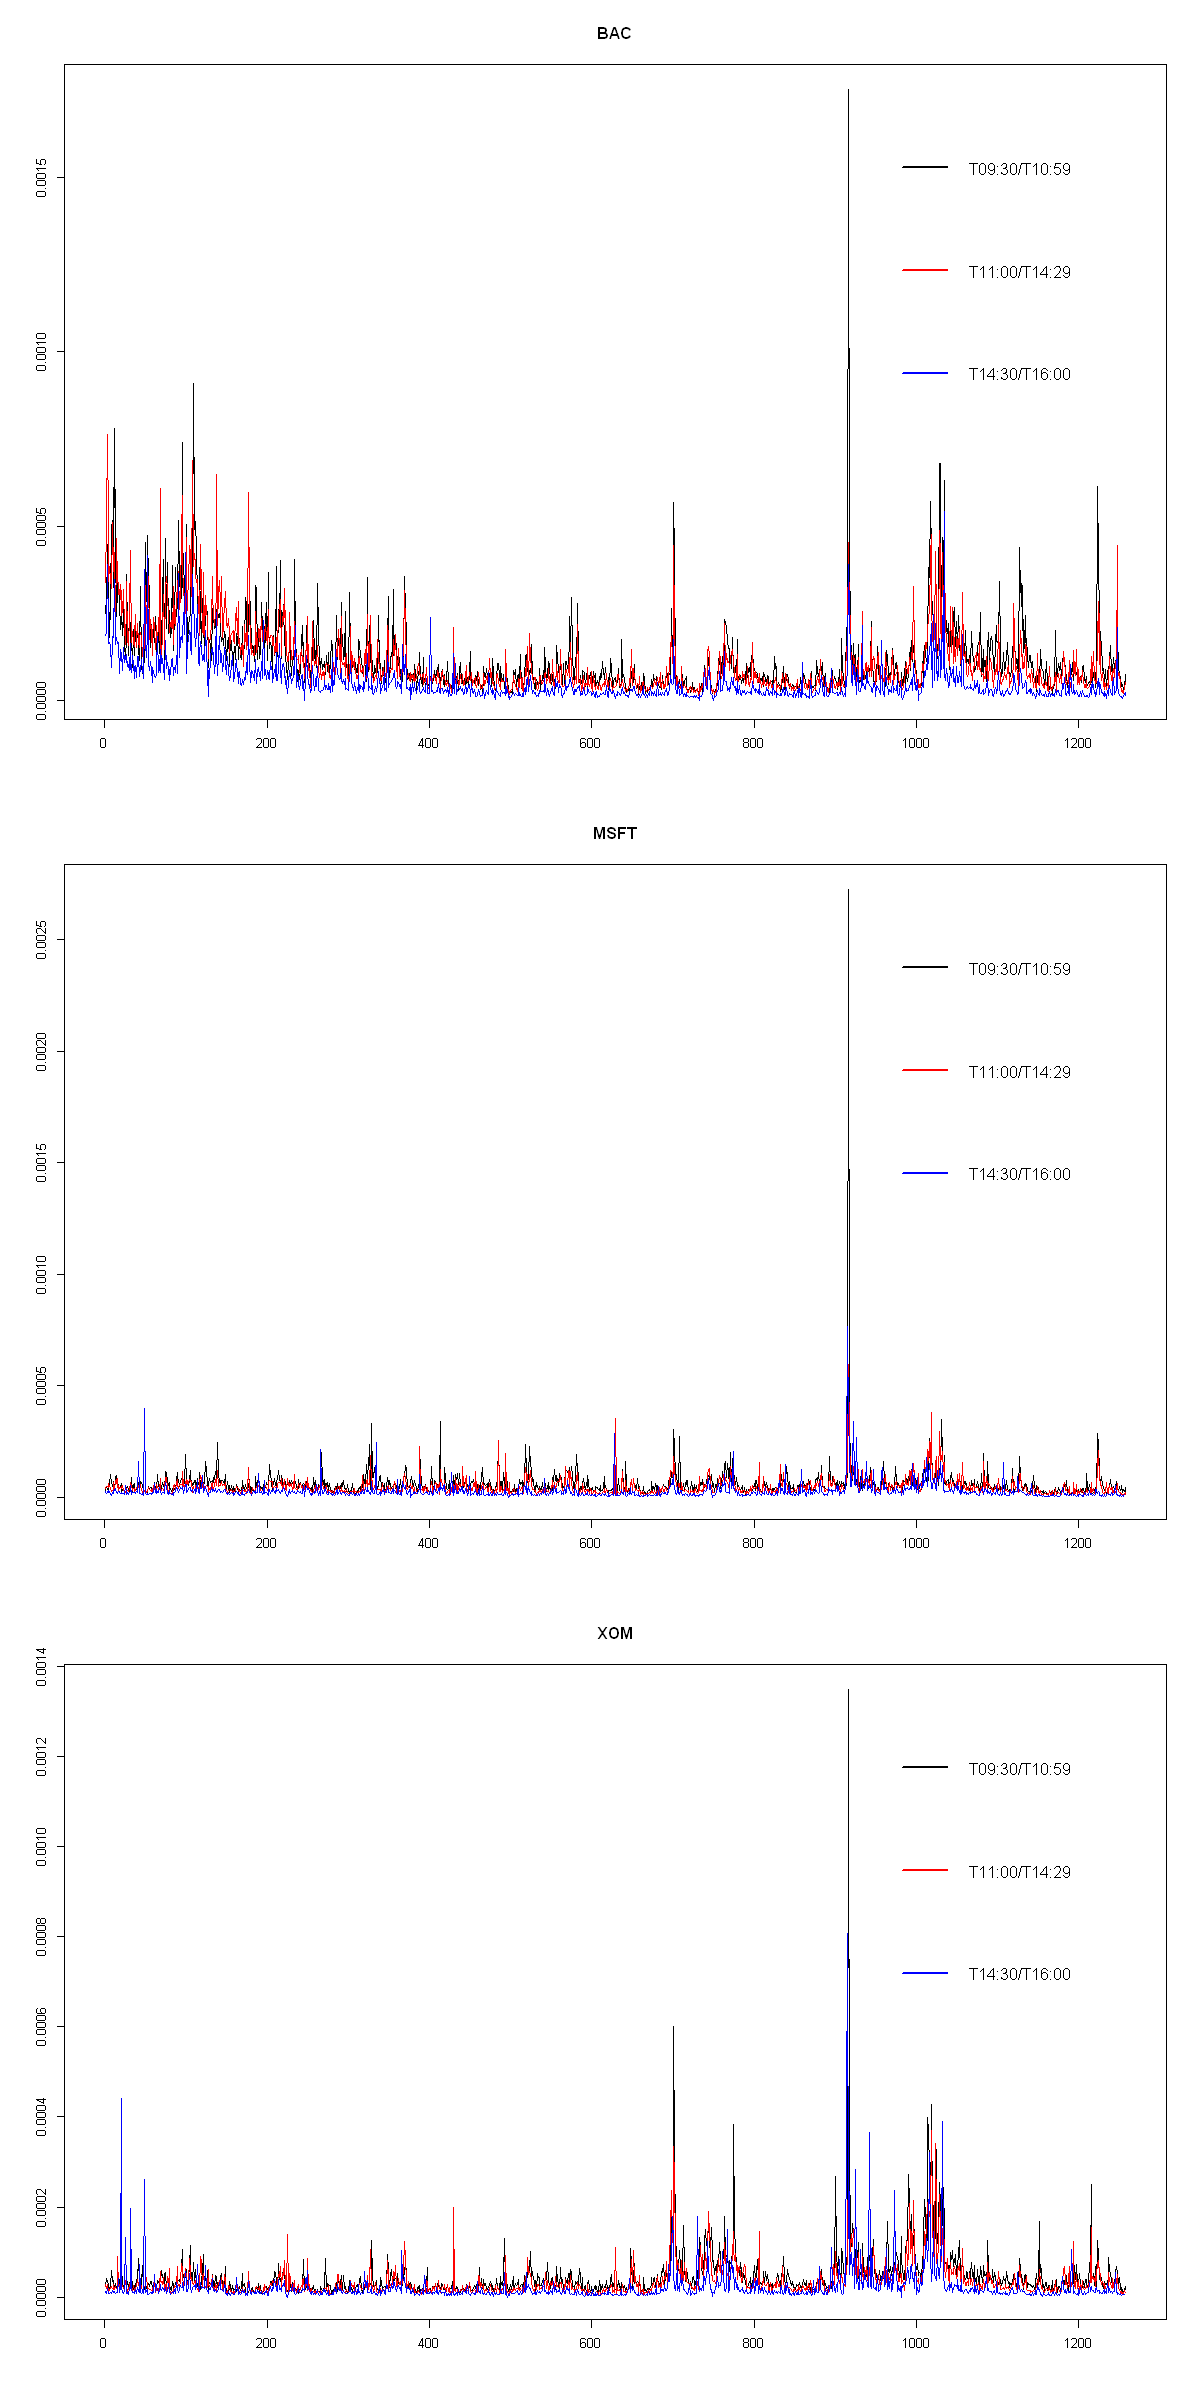

In [20]:
#Plotting
options(repr.plot.width = 10, repr.plot.height = 20)
par(mfrow = c(3, 1)) #Setting up the grid
for (i in 1:3) { #Looping through the tickers
    plot(as.numeric(real_var_subsets_from_prices[[i]][[1]]), type = "l", xlab = "", ylab = "", main = stock_names[i])
    lines(as.numeric(real_var_subsets_from_prices[[i]][[2]]), col = "red")
    lines(as.numeric(real_var_subsets_from_prices[[i]][[3]]), col = "blue")
    legend("topright", sub_periods, col = c("black", "red", "blue"), lty = 1, bty = "n", cex = 1.2, lwd = 2)
}

The plots look very similar to the ones in the previous exercise. In the next step, we sum the intraday RV from each period and compare it to daily RV.

In [21]:
#Calculating the sum of intraday RV from prices
sum_intraday_RV_from_prices <- vector("list", 3) #Empty list for sums of intraday RV
for (i in 1:3) { #Looping through the tickers
    time_removed <- lapply(real_var_subsets_from_prices[[i]], to.daily, OHLC = F) #Removing the time stamp from each subset for easier handling
    subsets_merged <- merge.xts(time_removed[[1]], time_removed[[2]], time_removed[[3]]) #Merging the subsets into a single xts object
    sum_intraday_RV_from_prices[[i]] <- apply.daily(subsets_merged, sum) #Summing RV for each day
}
#Removing the time stamp from daily RV for easier plotting
daily_RV_from_prices <- lapply(real_var_from_prices, to.daily, OHLC = F)

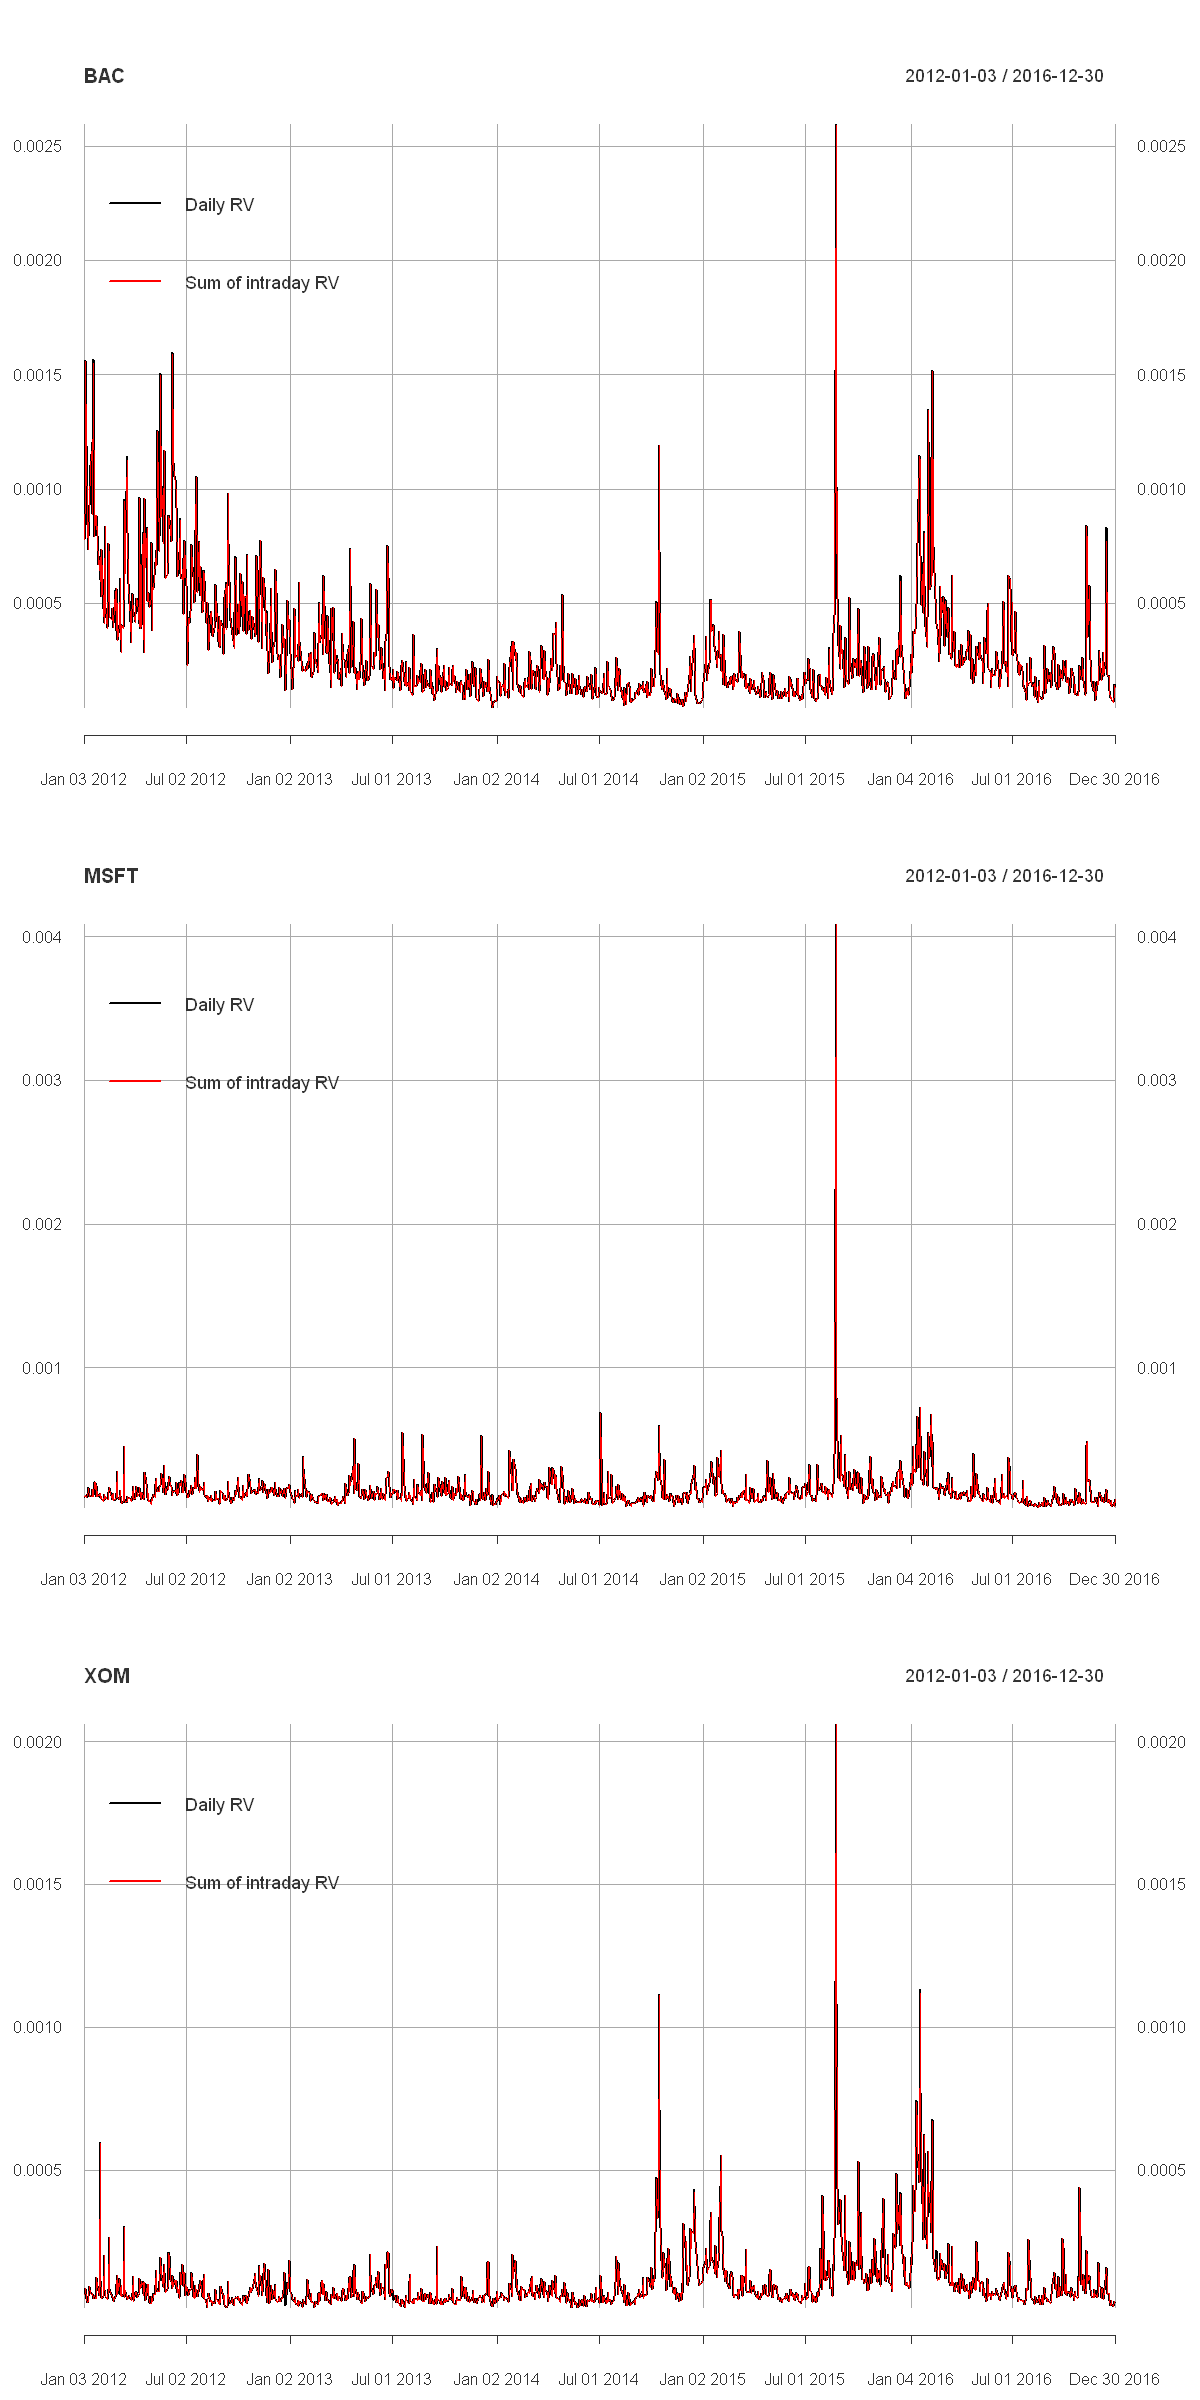

In [22]:
#Plotting
par(mfrow = c(3, 1)) #Setting up the grid
for (i in 1:3) { #Looping through the tickers
    plot_holder <- plot(daily_RV_from_prices[[i]], main = stock_names[i])
    plot_holder <- lines(sum_intraday_RV_from_prices[[i]], col = "red")
    plot_holder <- addLegend("topleft", on = 1, legend.names = c("Daily RV", "Sum of intraday RV"), col = c("black", "red"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}

In this case, the series does not seem to overlap perfectly. It may be more illustrative to plot their difference.

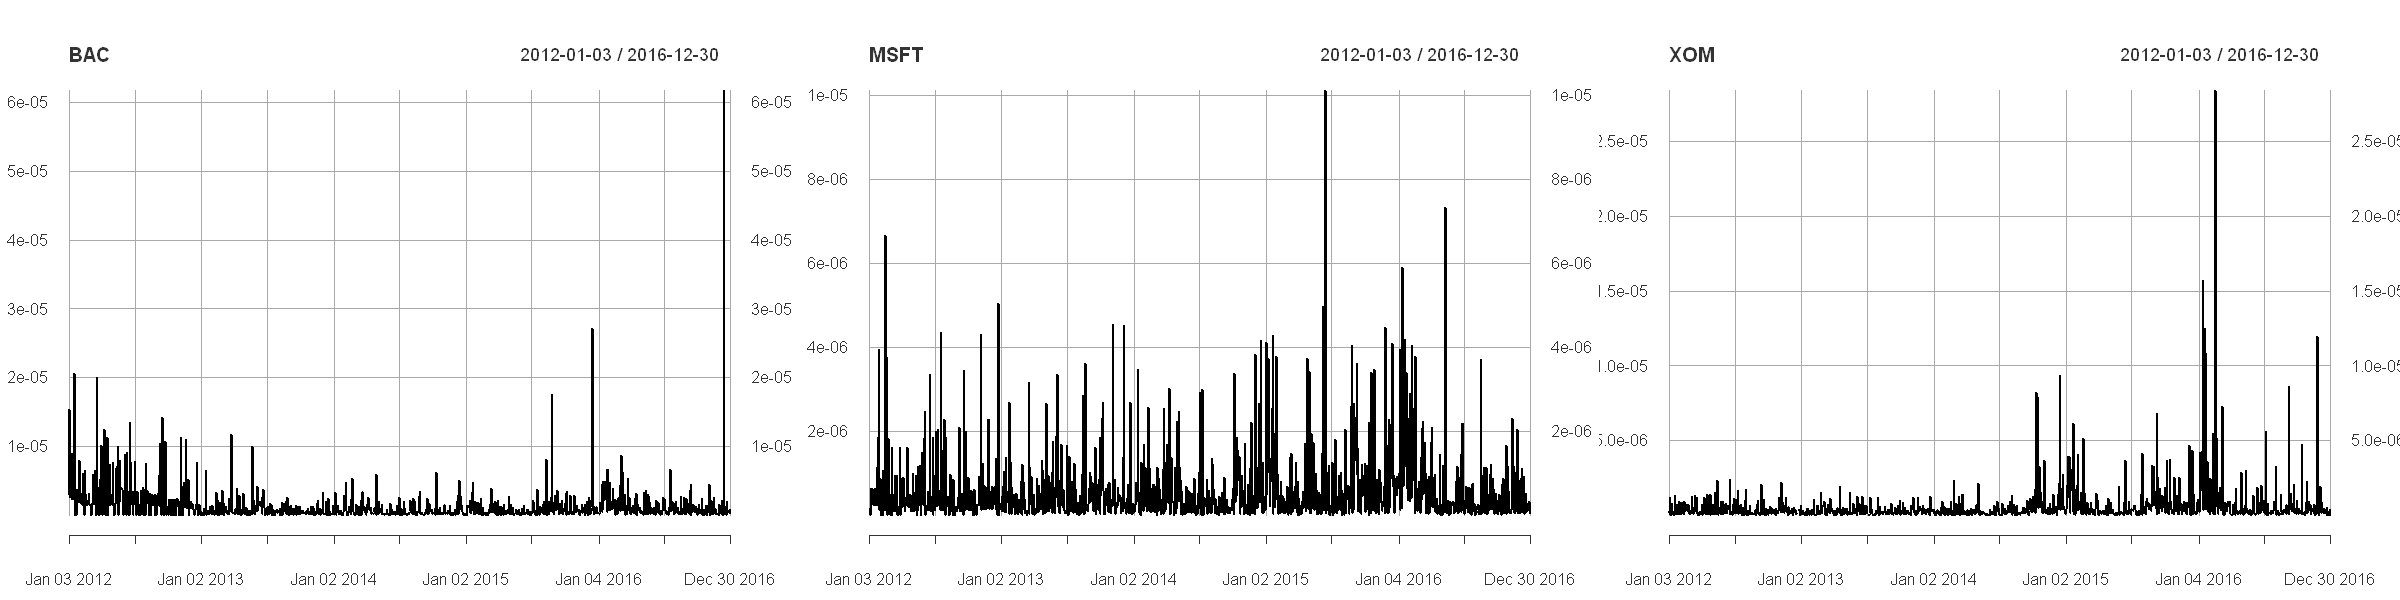

In [23]:
#Plotting the difference
options(repr.plot.width = 20, repr.plot.height = 5)
par(mfrow = c(1, 3)) #Setting up the grid
for (i in 1:3) { #Looping through the tickers
    print(plot(daily_RV_from_prices[[i]] - sum_intraday_RV_from_prices[[i]], main = stock_names[i]))
}

As can be seen, there certainly are some differences. However, this time they maybe another reason apart from the rounding error. In the previous exercise, we firstly calculated the returns and then subsetted the periods. Therefore, the returns are not "intraperiod". On the other hand, now we firstly subsetted the prices and then calculated the returns which is the correct procedure. Consequently, the results derived in the previous exercise are not reliable. We will see how will this impact our conclusions.

In [24]:
#Calculating the percentage share of each intrady RV in daily RV from prices
percentage_shares_from_prices <- vector("list", 3) #Empty vector for the results
for (i in 1:3) { #Looping through the tickers
    time_removed <- lapply(real_var_subsets_from_prices[[i]], to.daily, OHLC = F) #Removing the time stamp from each subset for easier handling
    percentage_shares_list <- lapply(time_removed, function(x) {x / daily_RV_from_prices[[i]]}) #Calculating the shares for each subset
    percentage_shares_from_prices[[i]] <- merge.xts(percentage_shares_list[[1]], percentage_shares_list[[2]], percentage_shares_list[[3]]) #Merging the results into a single xts object (3 shares per day)
    names(percentage_shares_from_prices[[i]]) <- sub_periods #Renaming the series for plotting
}

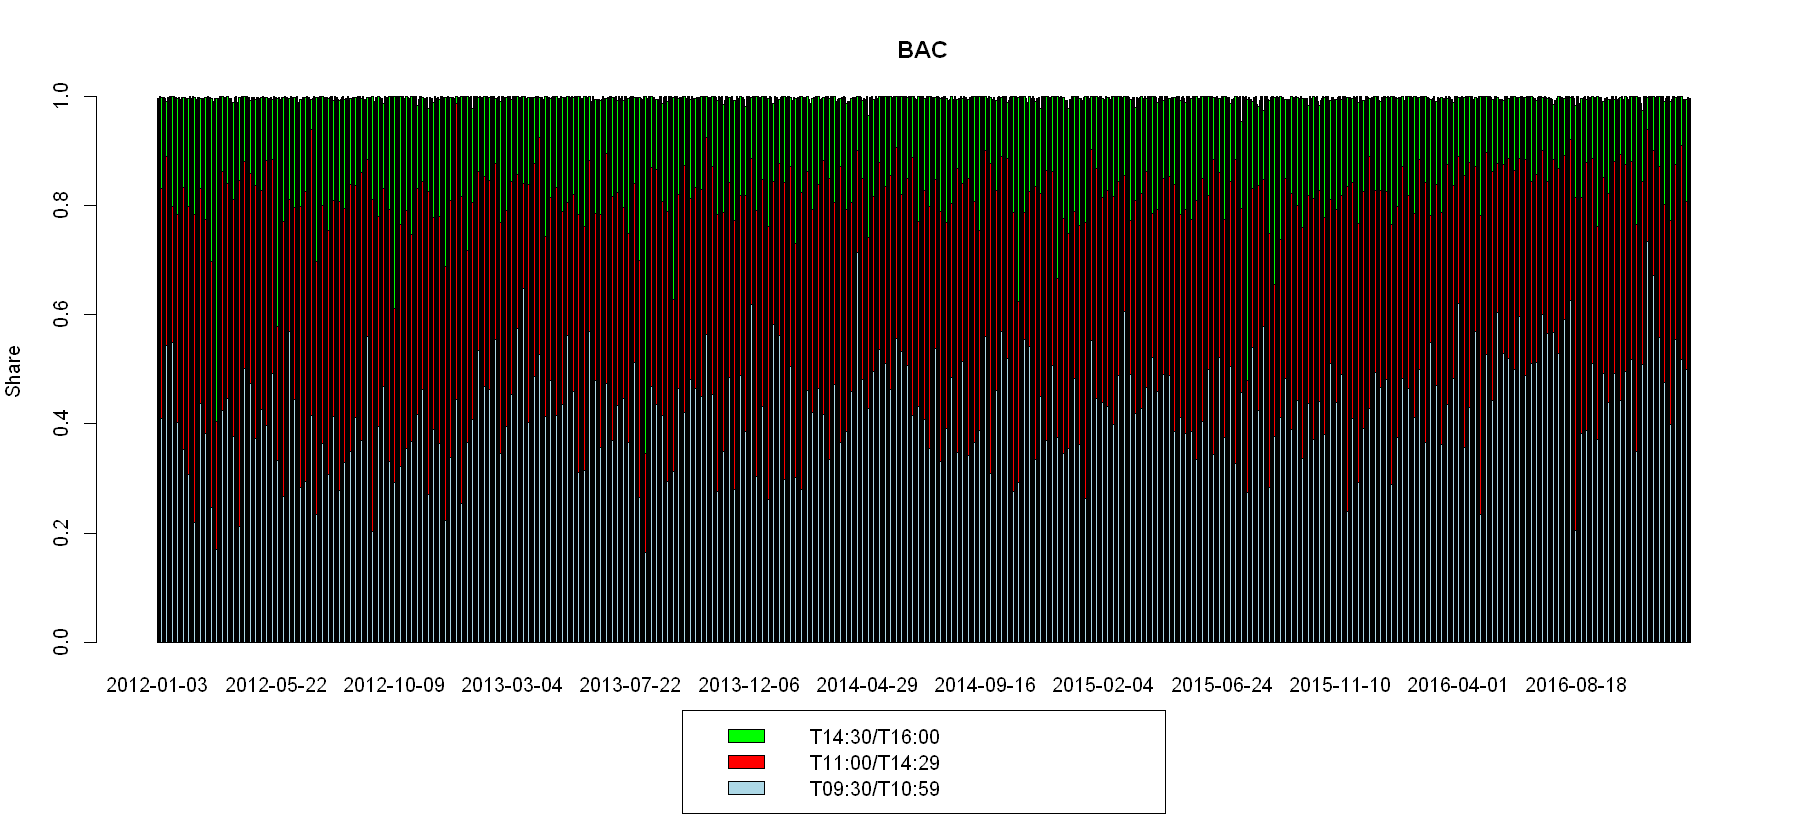

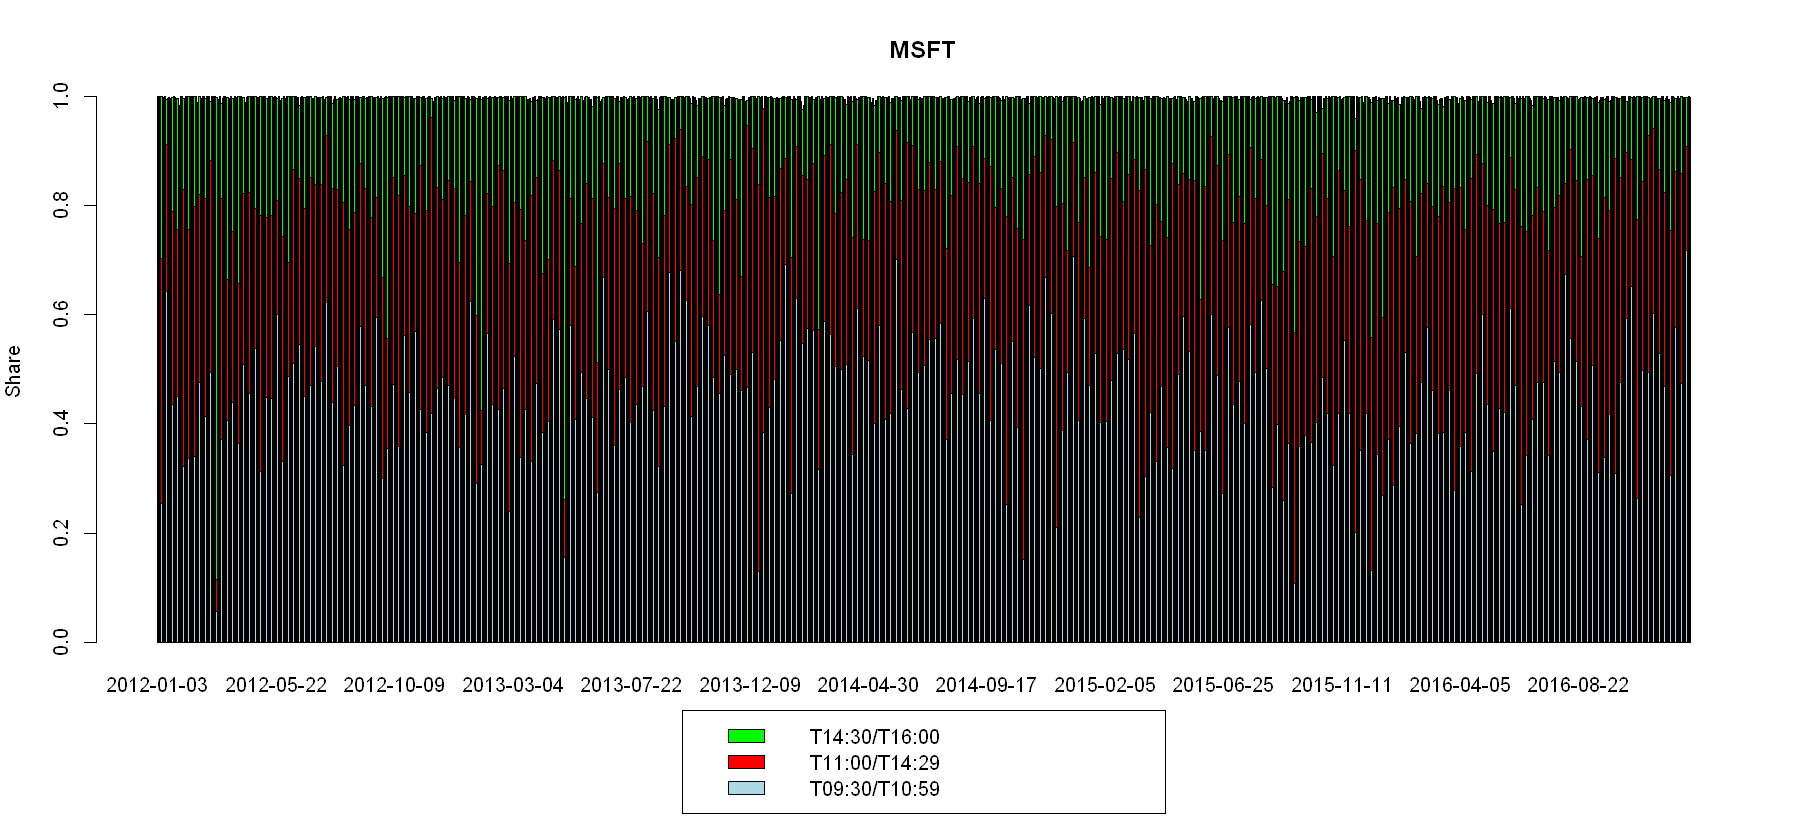

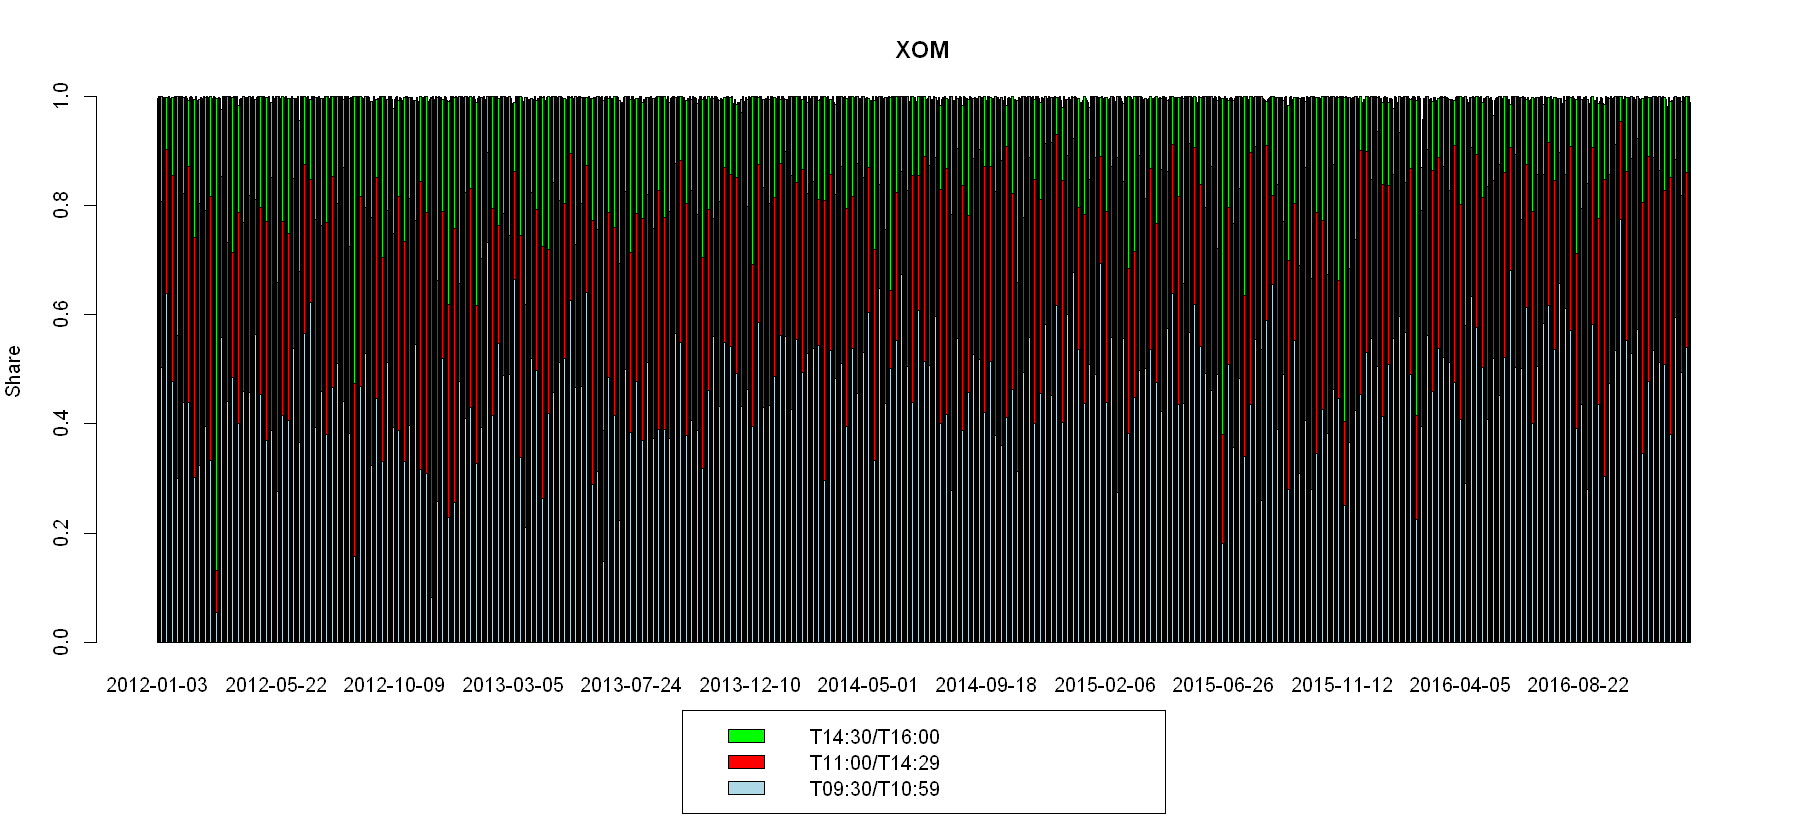

In [25]:
#Plotting
options(repr.plot.width = 15, repr.plot.height = 7)
par(mar = c(8, 4, 4, 2)) #Making a space for the legend
for (i in 1:3) {
    barplot(na.omit(percentage_shares_from_prices[[i]]), col = c("lightblue", "red", "green"), space = 0, main = stock_names[i], ylab = "Share", legend = T, args.legend = list(x = "bottom", inset = -0.3)) #Omitting 2 NAs that emerged in XOM after merging
}

As can be seen, the plots look very similar. However, this time they do not always sum up to one for every day. This is caused by the fact that the returns between the periods are disregarded. Nevertheless, the conclusions derived in the previous exercise likely remain unaffected. We can verify it by calculating the average shares once again.

In [26]:
#Average share of intrady RV for each sub-period (calculated from raw prices)
for (i in 1:3) { #Looping through the stocks
    print(stock_names[i])
    for (j in 1:3) { #Looping through the sub-periods
        print(paste(sub_periods[j], ": ", mean(percentage_shares_from_prices[[i]][, j], na.rm = T)))
    }
}

[1] "BAC"
[1] "T09:30/T10:59 :  0.430930095930397"
[1] "T11:00/T14:29 :  0.388140736481859"
[1] "T14:30/T16:00 :  0.176234779924587"
[1] "MSFT"
[1] "T09:30/T10:59 :  0.451527613954206"
[1] "T11:00/T14:29 :  0.353249831755431"
[1] "T14:30/T16:00 :  0.190739426240135"
[1] "XOM"
[1] "T09:30/T10:59 :  0.454940178027377"
[1] "T11:00/T14:29 :  0.348266178114511"
[1] "T14:30/T16:00 :  0.191639093451097"


### 9.

Let us begin with calculating the Bipower Variation using raw prices.

In [27]:
#Calculating Bipower Variation from prices
bpv <- vector("list", 3)
for (i in 1:3) {
    bpv[[i]] <- rBPCov(hw3_data_restricted[[i]], makeReturns = T)
}

Similarly, we compute MedRV estimator.

In [28]:
#Calculating MedRV from prices
medrv <- vector("list", 3)
for (i in 1:3) {
    medrv[[i]] <- rMedRVar(hw3_data_restricted[[i]], makeReturns = T)
}

Below, we plot the comparison of the previously calculated measures with the Realized Variance.

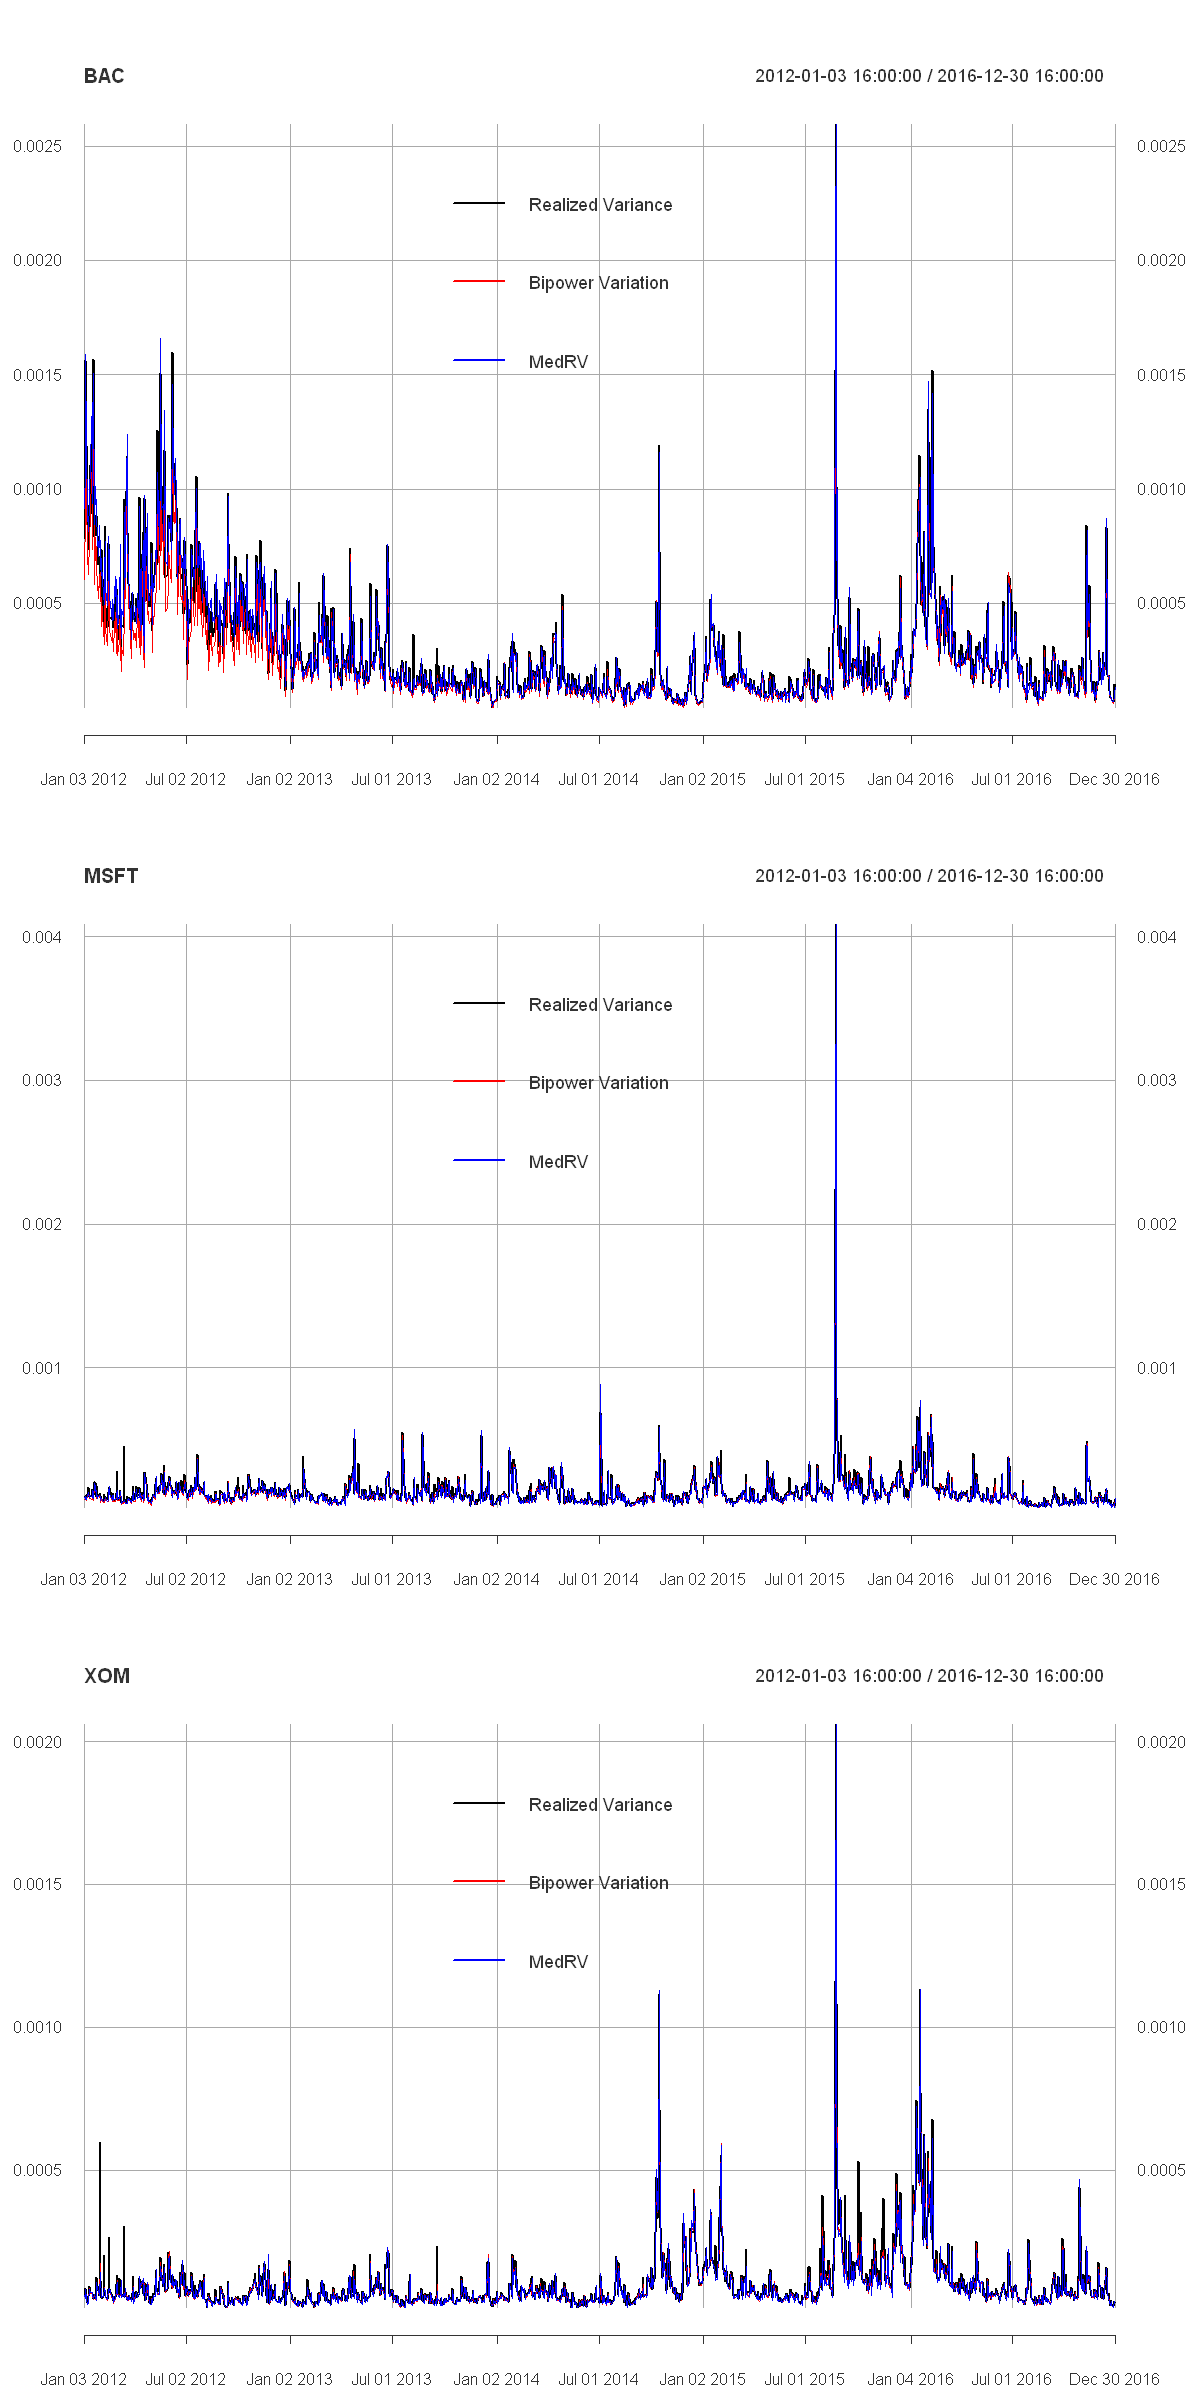

In [29]:
#Plotting the comparison of RV, BPV, MedRv
options(repr.plot.width = 10, repr.plot.height = 20)
par(mfrow = c(3, 1))
for (i in 1:3) { #Looping through the tickers
    plot_holder <- plot(real_var_from_prices[[i]], main = stock_names[i])
    plot_holder <- lines(bpv[[i]], col = "red")
    plot_holder <- lines(medrv[[i]], col = "blue")
    plot_holder <- addLegend("top", on = 1, legend.names = c("Realized Variance", "Bipower Variation", "MedRV"), col = c("black", "red", "blue"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}

As expected, the Bipower Variation estimates Realized Variance quite precisely. However, we can see an exception in the beginning of the BAC series where we can clearly distinguish between the two measures. The MedRV estimator seems to estimate RV fairly well but we can observe some deviations. Let us now calculate the jumps by substracting the Bipower Variation from Realized Variance.

In [30]:
#Calculating the jumps
jumps <- vector("list", 3)
for (i in 1:3) {
    jumps[[i]] <- real_var_from_prices[[i]] - bpv[[i]]
}

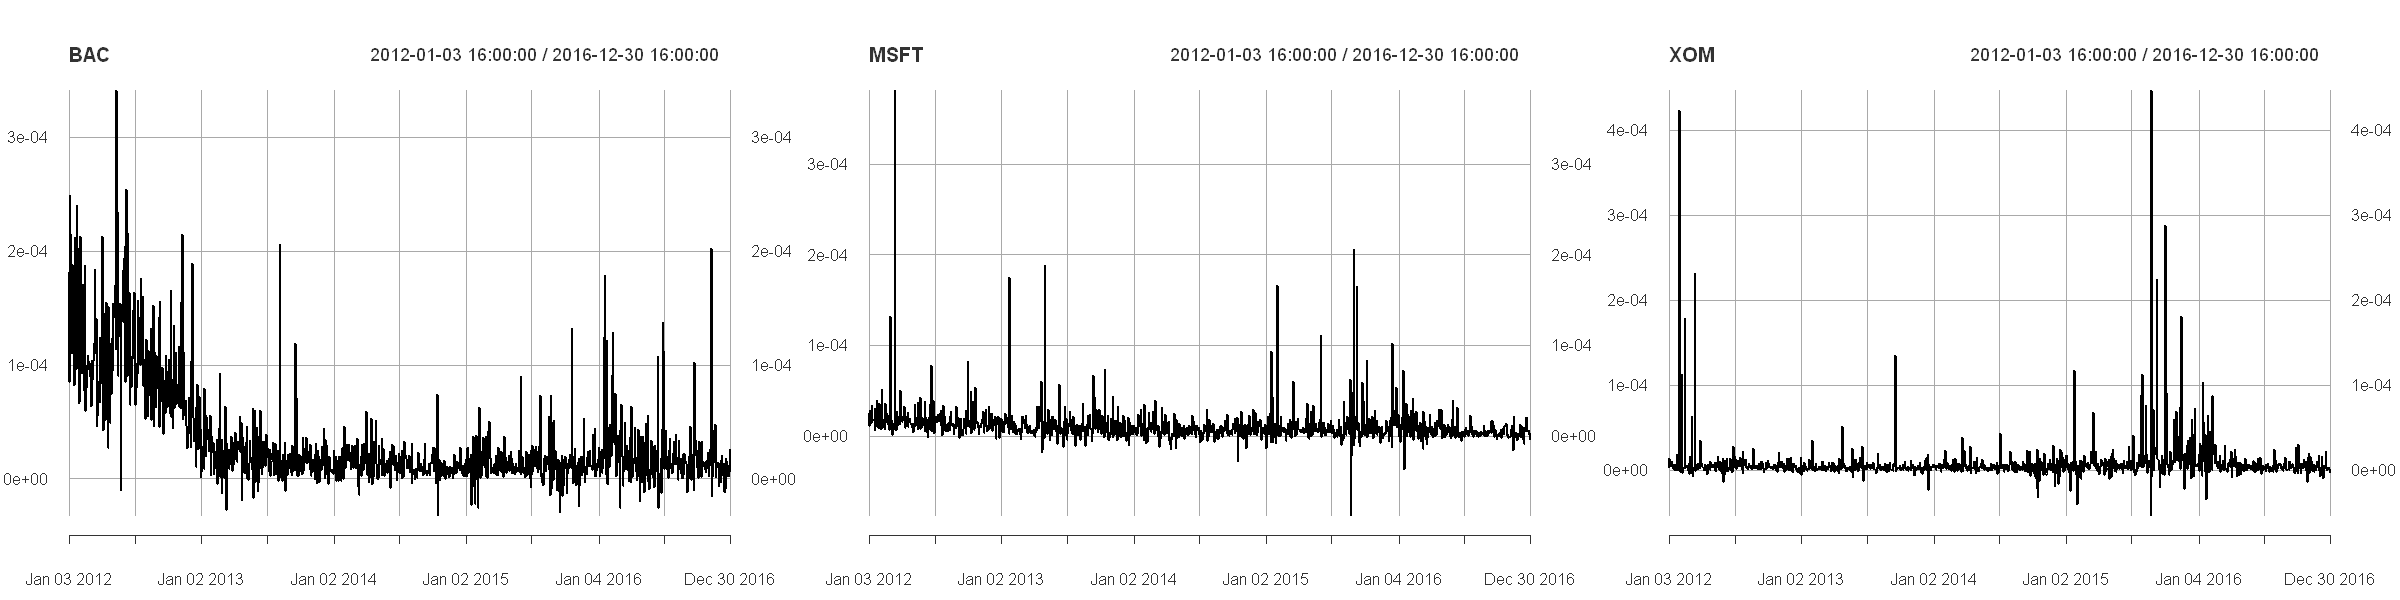

In [31]:
#Plotting the jumps
options(repr.plot.width = 20, repr.plot.height = 5)
par(mfrow = c(1, 3))
for (i in 1:3) {
    print(plot(jumps[[i]], main = stock_names[i]))
}

As the plots indicate, there appear to be some jumps, especially for the BAC stock. In the next step, we assess their significance.

In [32]:
#Testing jump significance and retaining only significant jumps
jumps_signif <- vector("list", 3)
for (i in 1:3) {
    jump_test <- BNSjumpTest(hw3_data_restricted[[i]], IVestimator = "BV", IQestimator = "TP", makeReturns = T) #Temporarily storing the results of the jump test
    jumps_signif[[i]] <- jumps[[i]] * ifelse(jump_test[, "p.value"] <= 0.05, 1, 0) #Keeping only singificant jumps (95% conf. level)
}

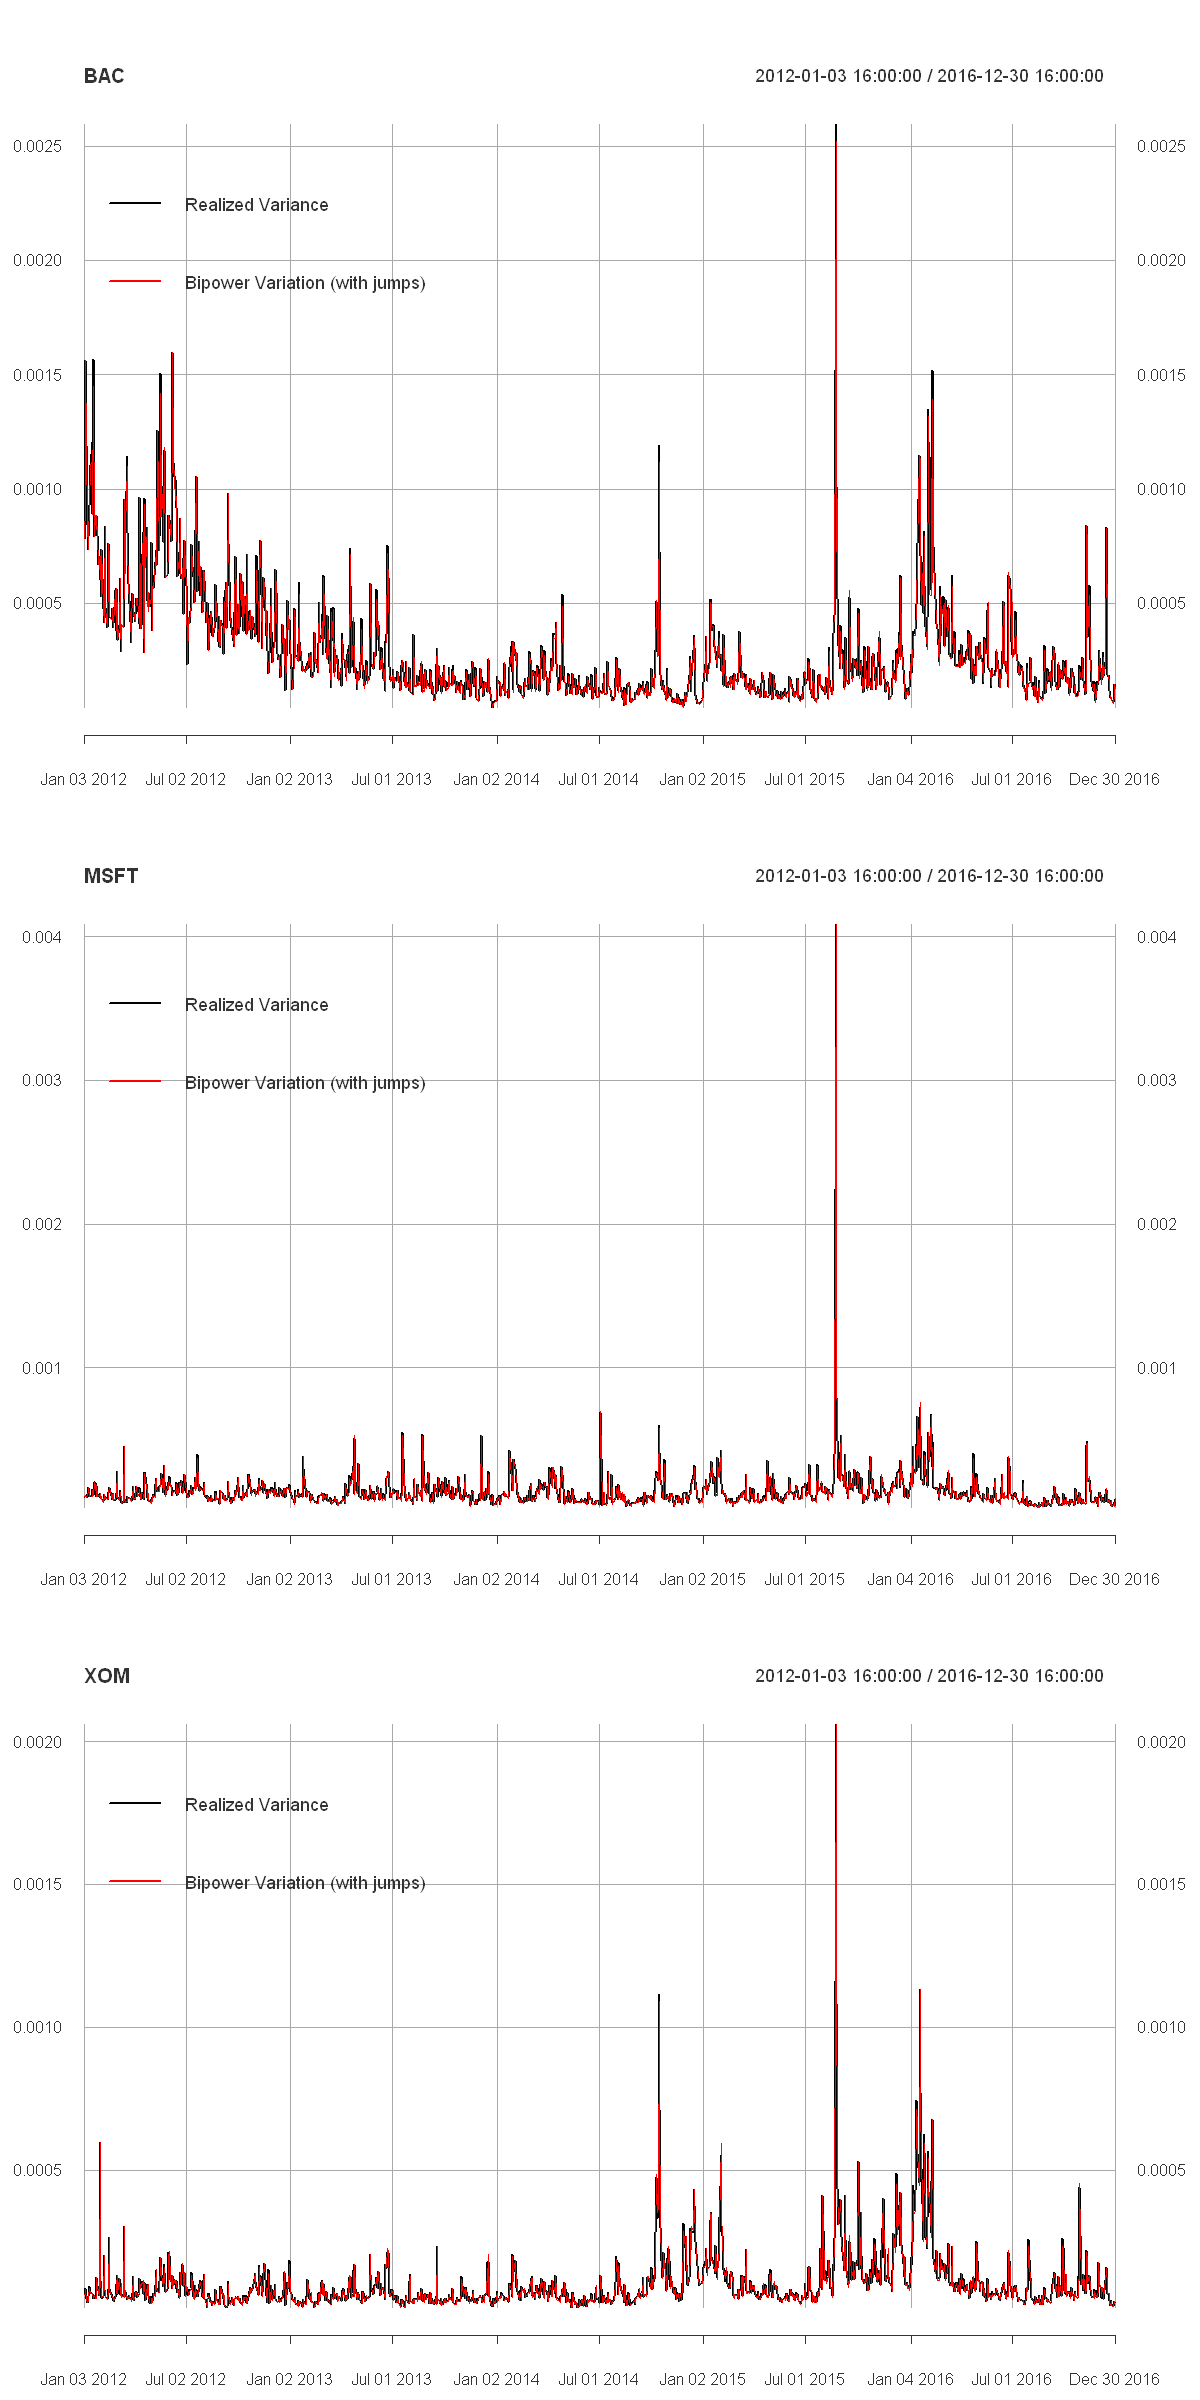

In [33]:
#Plotting RV vs BPV with jumps
options(repr.plot.width = 10, repr.plot.height = 20)
par(mfrow = c(3, 1))
for (i in 1:3) {
    plot_holder <- plot(real_var_from_prices[[i]], main = stock_names[i])
    plot_holder <- lines(bpv[[i]] + jumps_signif[[i]], col = "red")
    plot_holder <- addLegend("topleft", on = 1, legend.names = c("Realized Variance", "Bipower Variation (with jumps)"), col = c("black", "red"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}

The charts above capture the comparison between Realized Variance and Bipower Variation without jumps. As can be seen, the series are now almost indistinguishable. The greatest improvement can be observed for the BAC stock.

### 10.

In this section, we try to find an appropriate ARMA model for each stock. Subsequently, we estimate GARCH(1, 1) and compare the estimated volatility with Realized Volatility. Firstly, we calculate the daily returns as a sum of the previously derived intraday returns for each day.

In [34]:
#Calculating daily returns
daily_returns <- vector("list", 3) #Empty list for the daily returns
for (i in 1:3) {
    daily_returns[[i]] <- to.daily(apply.daily(na.omit(hw3_data_final[[i]]), sum), OHLC = F) #to.daily removes the time stamp
}

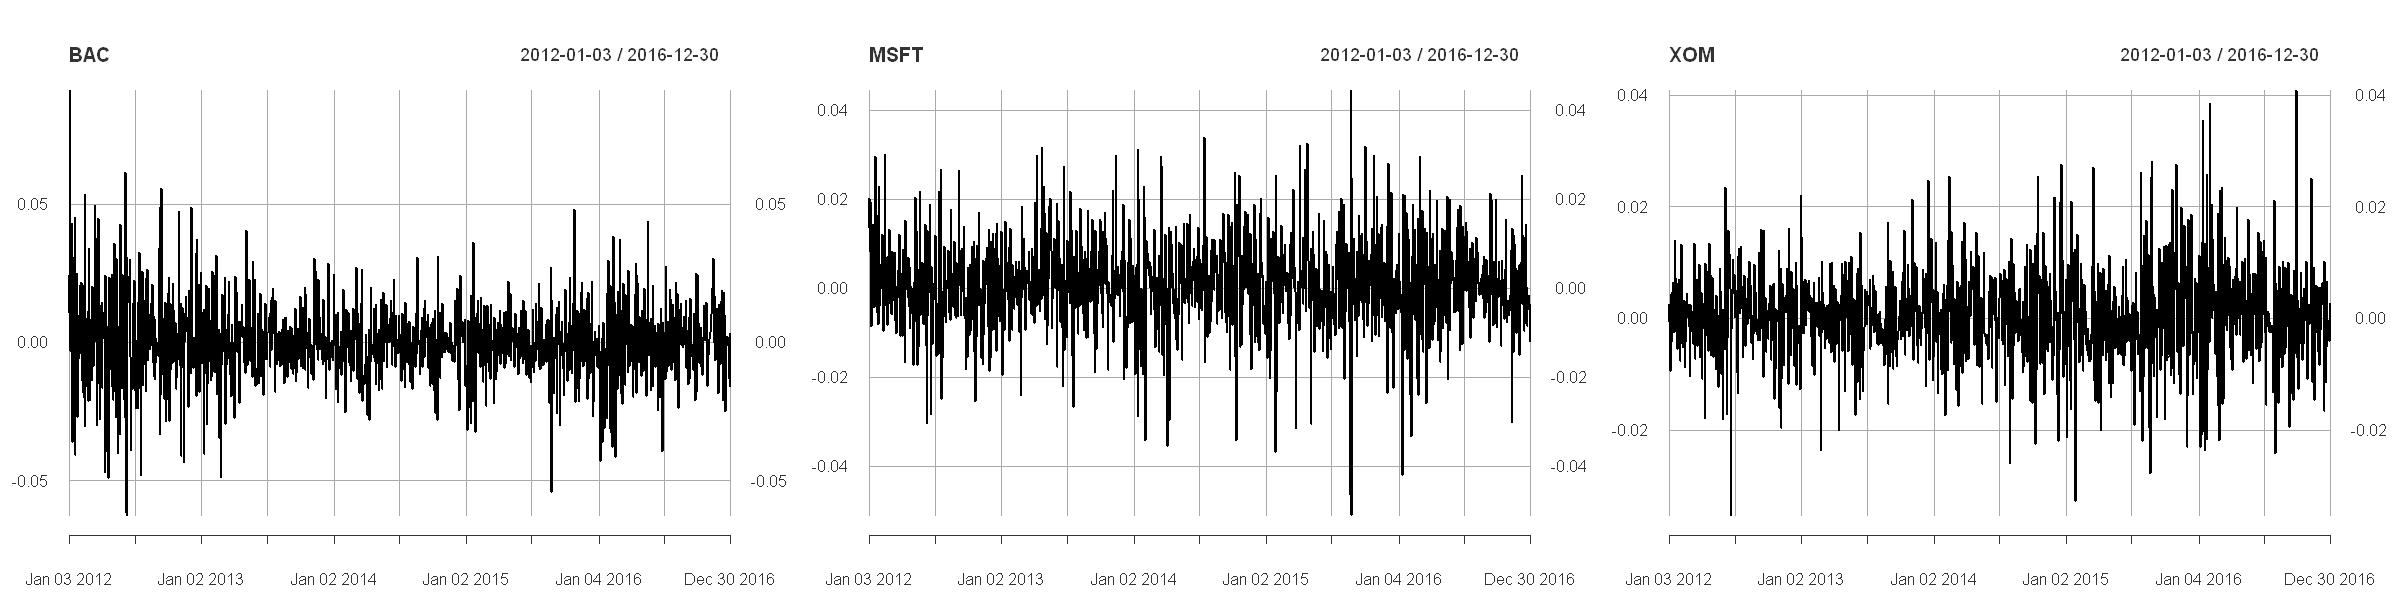

In [35]:
#Plotting the daily returns
options(repr.plot.width = 20, repr.plot.height = 5)
par(mfrow = c(1, 3))
for (i in 1:3) {
    print(plot(daily_returns[[i]], main = stock_names[i]))
}

As can be seen from the plots, the series of returns for each stock seem to be mean-stationary. However, we can observe some variance clustering. We will test whether the series are stationary using the Augmented Dickey-Fuller test.

In [36]:
#Augmented Dickey-Fuller Test
for (i in 1:3) {
    print(stock_names[i])
    print(adf.test(daily_returns[[i]]))
}

[1] "BAC"


Warning message in adf.test(daily_returns[[i]]):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  daily_returns[[i]]
Dickey-Fuller = -10.234, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary

[1] "MSFT"


Warning message in adf.test(daily_returns[[i]]):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  daily_returns[[i]]
Dickey-Fuller = -10.432, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary

[1] "XOM"


Warning message in adf.test(daily_returns[[i]]):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  daily_returns[[i]]
Dickey-Fuller = -11.875, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary



As the results suggest, the null hypothesis of the presence of the unit root is rejected in favor of the alternative of stationarity for all three stocks. Therefore, we can proceed with the inspection of the Autocorrelation Function and Partial-Autocorrelation Function.

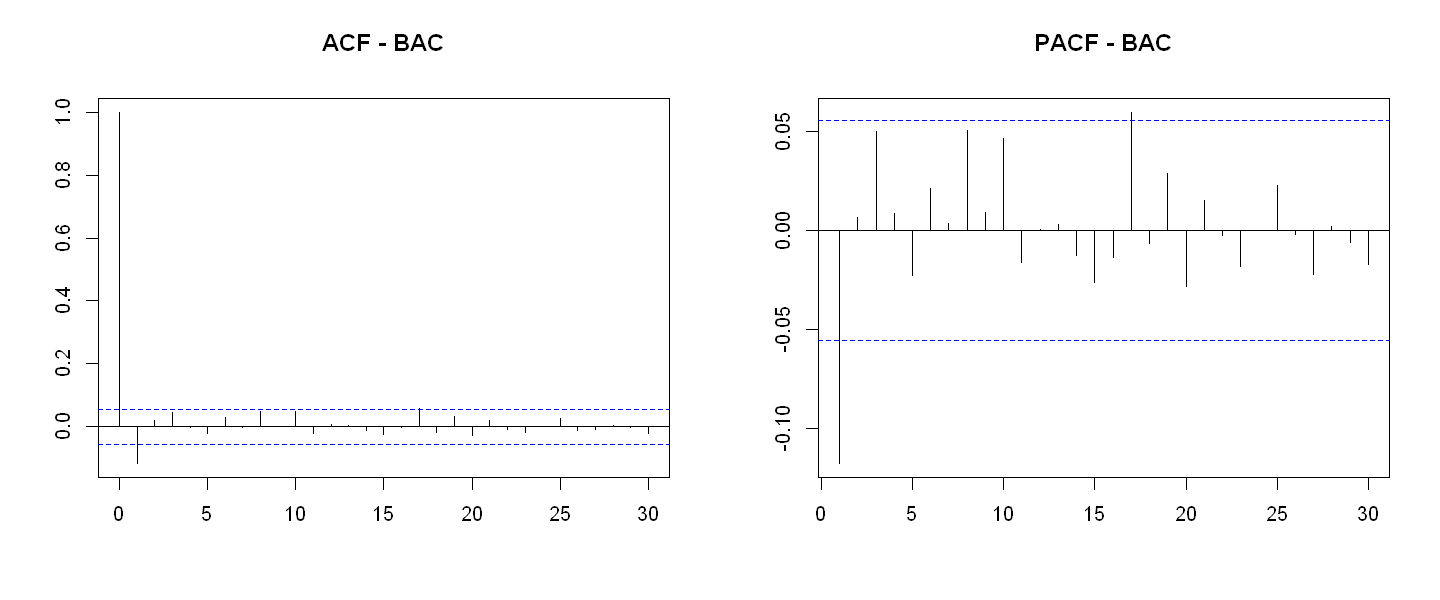

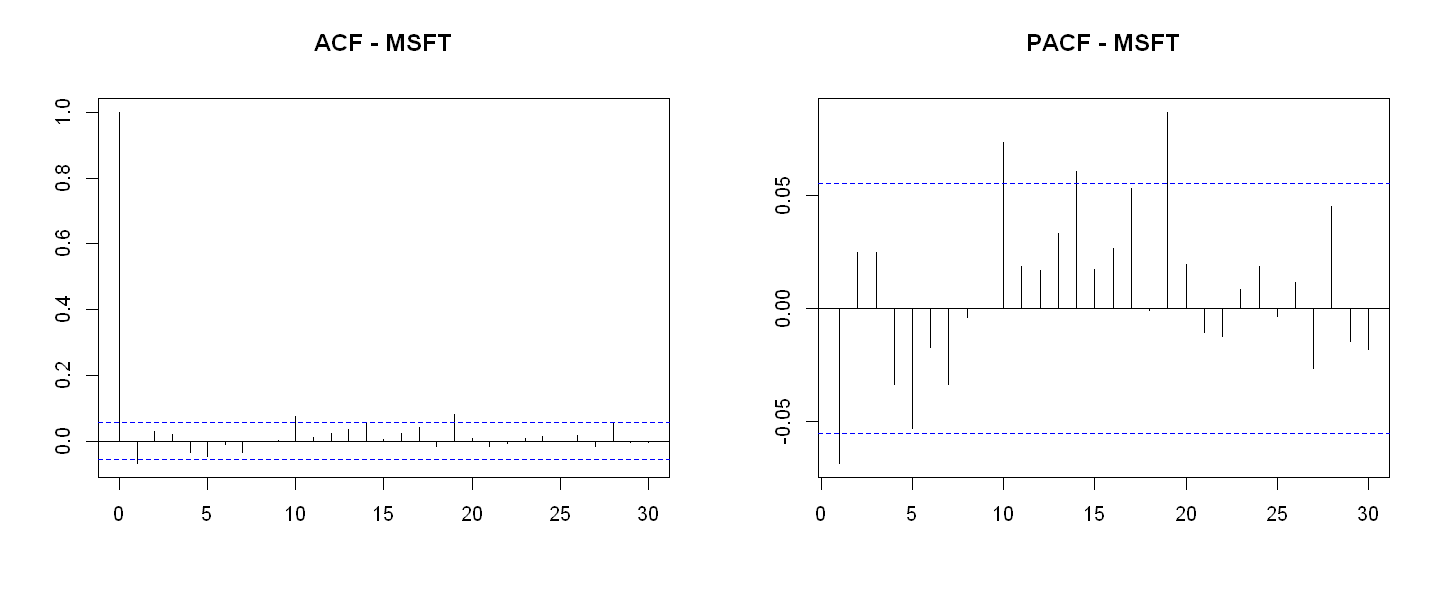

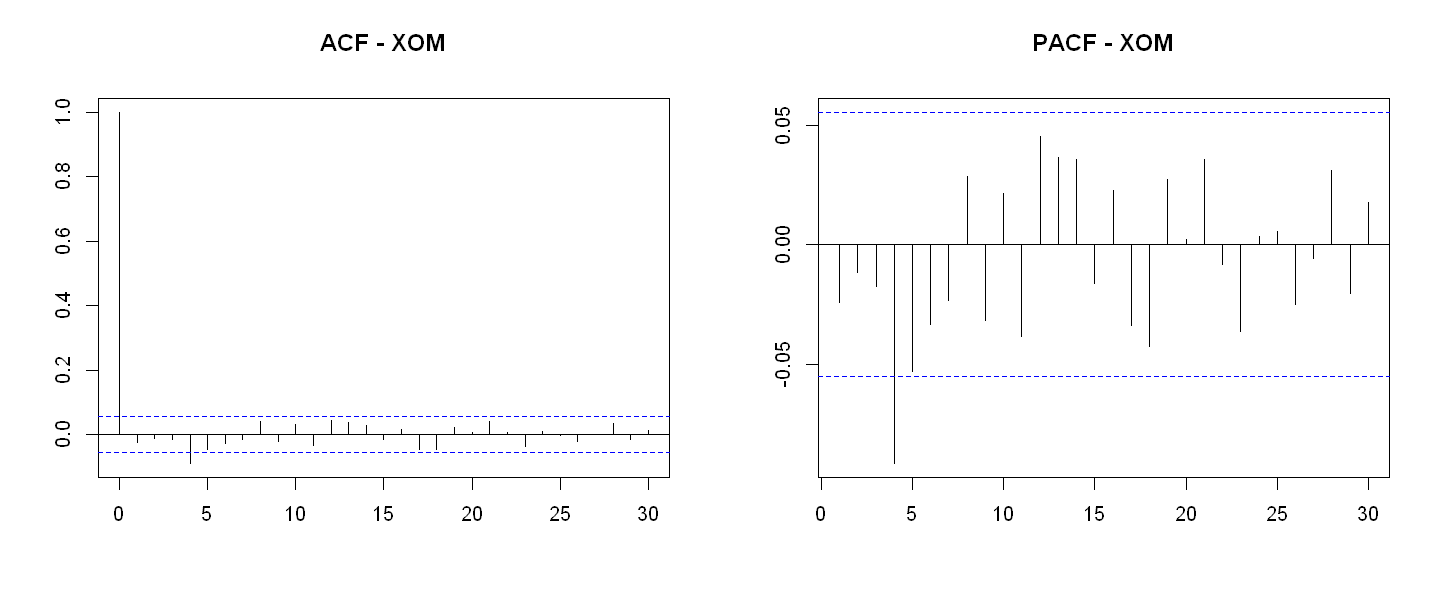

In [37]:
#ACF and PACF
options(repr.plot.width = 12, repr.plot.height = 5)
par(mfrow = c(1, 2))
for (i in 1:3) {
    acf(daily_returns[[i]], xlab = "", ylab = "", main = paste("ACF", "-", stock_names[i]))
    pacf(daily_returns[[i]], xlab = "", ylab = "", main = paste("PACF", "-", stock_names[i]))
}

The ACF and PACF suggest that there are some significant dependencies. We perform a Ljung-Box test to confirm our suspicions.

In [38]:
#Ljung-Box test
for (i in 1:3) {
    print(stock_names[i])
    for (lag_order in c(4, 8, 12)) {
        print(Box.test(daily_returns[[i]], type = "Ljung-Box", lag = lag_order)$p.value)
    }
}

[1] "BAC"
[1] 0.0003758492
[1] 0.001467492
[1] 0.004343892
[1] "MSFT"
[1] 0.0566545
[1] 0.08872023
[1] 0.04157217
[1] "XOM"
[1] 0.02095421
[1] 0.02249072
[1] 0.02410091


The results of the test indicate that there are some significant autocorrelations for all stocks. Instead of inspecting them separately, we can utilize the ``auto.arima`` function which finds the optimal ARMA model based on information criteria. Its output needs to of course be treated with caution.

In [39]:
#Finding the optimal ARMA model
for (i in 1:3) {
    print(stock_names[i])
    for (inf_crit in c("aic","aicc","bic")) {
        auto_model <- auto.arima(daily_returns[[i]], stationary = T, ic = inf_crit) 
        print(paste(inf_crit, ": ", "ARMA(", auto_model$arma[1], ",", auto_model$arma[2], ")", sep = ""), quote = F)
    }
}

[1] "BAC"
[1] aic: ARMA(3,0)
[1] aicc: ARMA(3,0)
[1] bic: ARMA(3,0)
[1] "MSFT"
[1] aic: ARMA(1,2)
[1] aicc: ARMA(1,2)
[1] bic: ARMA(0,0)
[1] "XOM"
[1] aic: ARMA(0,0)
[1] aicc: ARMA(0,0)
[1] bic: ARMA(0,0)


We will try to estimate the suggested models and then inspect whether we successfully eliminated the dependecies. In case of XOM, we will not utilize a mean model and hope to remove the dependecies with the help of GARCH(1,1). As for the other stocks, we will firstly try to estimate ARMA(1, 0) since we want the model to be as parsimonious as possible.

In [40]:
#Estimating ARMA
orders <- matrix(c(1, 0, 0, 1, 0, 0), ncol = 2) #Specifing the order for both stocks
for (i in 1:2) {
    print(stock_names[i])
    arma_model <- Arima(daily_returns[[i]], order = orders[, i])
    for (lag_order in c(4, 8, 12)) {
        print(Box.test(arma_model$residuals, type = "Ljung-Box", lag = lag_order)$p.value)
    }
}


[1] "BAC"
[1] 0.5105124
[1] 0.4626663
[1] 0.5347959
[1] "MSFT"
[1] 0.5194485
[1] 0.3775272
[1] 0.1370475


The results suggest that we successfully removed the dependencies up to the 12th lag. There are possibly some dependencies of higher order (especially for MSFT), but we hope to model them with GARCH(1, 1).

In [41]:
#Estimating GARCH(1, 1)
garch_models <- vector("list", 3) #Empty vector for the estimated volatilities
garchspecBACandMSFT <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)), #Saving the specifications since they are shared among the two stocks
                        mean.model = list(armaOrder = c(1, 0), include.mean = TRUE, archm = TRUE, archpow = 1))
garchspecXOM <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)), #Saving the specifications for XOM
                        mean.model = list(armaOrder = c(0, 0), include.mean = TRUE, archm = TRUE, archpow = 1))

for (i in 1:3) {
    if (i == 3) {
        garchspec <- garchspecXOM
    } else {
        garchspec <- garchspecBACandMSFT
    }
    garch_models[[i]] <- ugarchfit(garchspec, daily_returns[[i]]) #Estimating and storing the results
}

Now we will inspect how well the models fit the data and whether we need to make any adjustments.

In [47]:
#Inspecting the results of GARCH estimation (BAC)
garch_models[[1]]



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.000026    0.001522 -0.01734 0.986166
ar1    -0.078064    0.029223 -2.67137 0.007554
archm   0.015815    0.122331  0.12928 0.897137
omega   0.000002    0.000003  0.65776 0.510692
alpha1  0.043733    0.021773  2.00863 0.044576
beta1   0.946313    0.024839 38.09722 0.000000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.000026    0.004972 -0.005309 0.995764
ar1    -0.078064    0.045686 -1.708732 0.087501
archm   0.015815    0.351853  0.044947 0.964149
omega   0.000002    0.000026  0.069867 0.944300
alpha1  0.043733    0.219423  0.199311 0.842019
beta1   0.946313    0.245905  3.848292 0.000119



As can be seen, the results of the specification tests are satisfactory. Only the ARCH test shows some significant ARCH effects at the 3rd lag but only at the 10% significance level.

In [48]:
#Inspecting the results of GARCH estimation (MSFT)
garch_models[[2]]


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.000400    0.004222 -0.094778 0.924491
ar1    -0.043444    0.031070 -1.398285 0.162027
archm   0.114662    0.410544  0.279293 0.780020
omega   0.000044    0.000016  2.718399 0.006560
alpha1  0.092933    0.027966  3.323137 0.000890
beta1   0.503741    0.160408  3.140379 0.001687

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.000400    0.004946 -0.080908 0.935515
ar1    -0.043444    0.028190 -1.541109 0.123290
archm   0.114662    0.477775  0.239992 0.810337
omega   0.000044    0.000021  2.067087 0.038726
alpha1  0.092933    0.037208  2.497703 0.012500
beta1   0.503741    0.205969  2.445715 0.0

In case of MSFT, the results are very satisfactory, the model seems to remove all the dependecies.

In [49]:
#Inspecting the results of GARCH estimation (XOM)
garch_models[[3]]


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.001737    0.001297  -1.3396  0.18038
archm   0.269172    0.166036   1.6212  0.10498
omega   0.000005    0.000000  14.2691  0.00000
alpha1  0.092552    0.009660   9.5810  0.00000
beta1   0.836237    0.014532  57.5454  0.00000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.001737    0.001279  -1.3583 0.174354
archm   0.269172    0.159510   1.6875 0.091509
omega   0.000005    0.000000  11.2853 0.000000
alpha1  0.092552    0.004991  18.5431 0.000000
beta1   0.836237    0.013173  63.4812 0.000000

LogLikelihood : 4278.807 

Information Criteria
------------------------------------
                

Similarly, the results for XOM suggest that we do not need to adjust the model specifications any further. Therefore, we can estimate volatility for all three models and compare it to Realized Volatility.

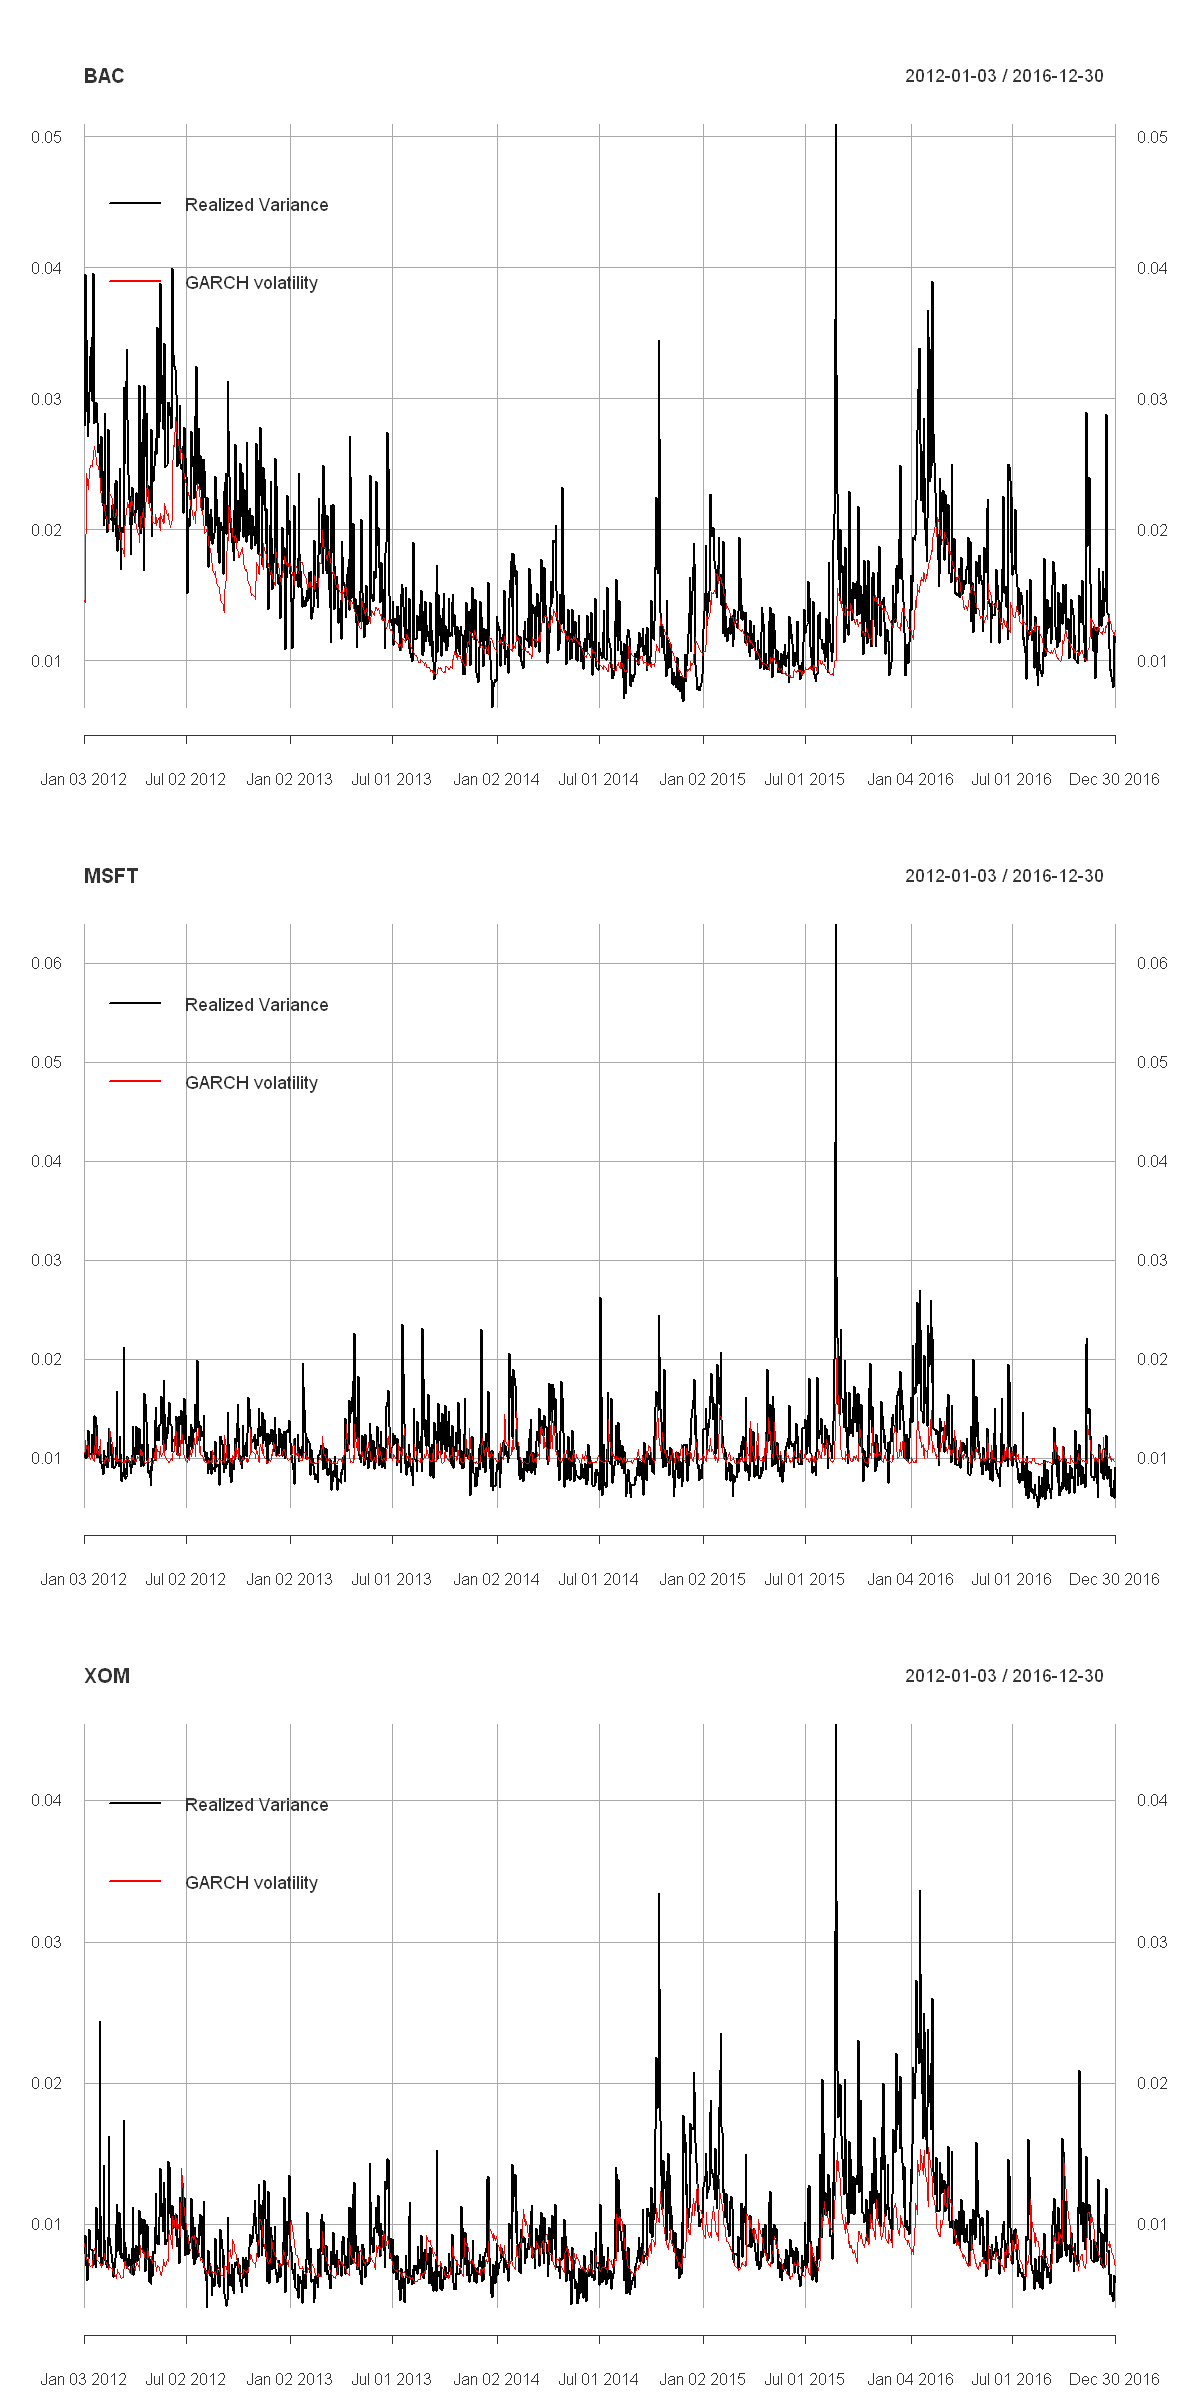

In [51]:
#Plotting estimated GARCH volatility vs Realized Volatility
options(repr.plot.width = 10, repr.plot.height = 20)
par(mfrow = c(3, 1))
for (i in 1:3) {
    plot_holder <- plot(sqrt(to.daily(real_var_from_returns[[i]], OHLC = F)), main = stock_names[i])
    plot_holder <- lines(sigma(garch_models[[i]]), col = "red")
    plot_holder <- addLegend("topleft", on = 1, legend.names = c("Realized Variance", "GARCH volatility"), col = c("black", "red"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}

As can be seen, the GARCH estimated volatility somewhat follows the Realized Variance, however, the fit is not the greatest. The estimates are a bit shifted in time which is intuitive given the nature of the model. If we take a look at the stock BAC, we can see that in the beginning of the series, it does a very poor job at estimating the Realized Variance but later the fit is improved.

### Problem 2

#### A)

In this problem, we repeat the previous analysis with 5 minutes data. Therefore, we need to convert the 1 minute prices first. For this purpose we use the xts function ``to.minutes5()``.

In [52]:
#Converting from 1 min data to 5 min data
hw3_data_5min <- vector("list", 3) #Empty vector for the results.
for (i in 1:3) {
    hw3_data_5min[[i]] <- to.minutes5(hw3_data_restricted[[i]], OHLC = F)
}

To make sure that everything went smoothly, we check the head of the original and new series. As can be seen, our data now starts at 2012-01-03 09:34:00 with a 5 min frequency. The starting point should be arbitrary and thus should not have and effect on our analysis. Therefore, we can proceed.

In [53]:
head(hw3_data_restricted[[1]])
head(hw3_data_5min[[1]])

Warning message:
"timezone of object (UTC) is different than current timezone ()."


                      [,1]
2012-01-03 09:30:00 5.3773
2012-01-03 09:31:00 5.3773
2012-01-03 09:32:00 5.3960
2012-01-03 09:33:00 5.4147
2012-01-03 09:34:00 5.4240
2012-01-03 09:35:00 5.4334

Warning message:
"timezone of object (UTC) is different than current timezone ()."


                      [,1]
2012-01-03 09:34:00 5.4240
2012-01-03 09:39:00 5.4334
2012-01-03 09:44:00 5.4334
2012-01-03 09:49:00 5.4334
2012-01-03 09:54:00 5.4240
2012-01-03 09:59:00 5.4240

We can skip the first two tasks since our data is already loaded and restricted. Therefore, we will calculate the returns.

#### 3.

In [54]:
#Calculating intraday returns
hw3_data_5min_returns <- vector("list", 3) #Empty vector for final data
for (i in 1:3) { #Looping through the stocks
    days <- split(hw3_data_5min[[i]], f = "days") #Splitting the series into days
    intraday_returns <- lapply(X = days, FUN = makeReturns_adjusted) #Calculating the returns for each day
    hw3_data_5min_returns[[i]] <- do.call(rbind.xts, intraday_returns) #Concatenating the series
}

#### 4.

In this task we investigate the behavior of the ``rCov()`` function once again. The results should be the same.

In [55]:
#Calculating the Realized Variance from prices
real_var_from_5min_prices <- vector("list", 3) #Empty vector for the results
for (i in 1:3) {#Looping through the tickers
    real_var_from_5min_prices[[i]] <- rCov(hw3_data_5min[[i]], makeReturns = TRUE)
}
#Calculating the Realized Variance from returns
real_var_from_5min_returns <- vector("list", 3) #Empty vector for the results
for (i in 1:3) {#Looping through the tickers
    real_var_from_5min_returns[[i]] <- rCov(na.omit(hw3_data_5min_returns[[i]]), makeReturns = FALSE) #Have to omit NAs in order for the function to work
}

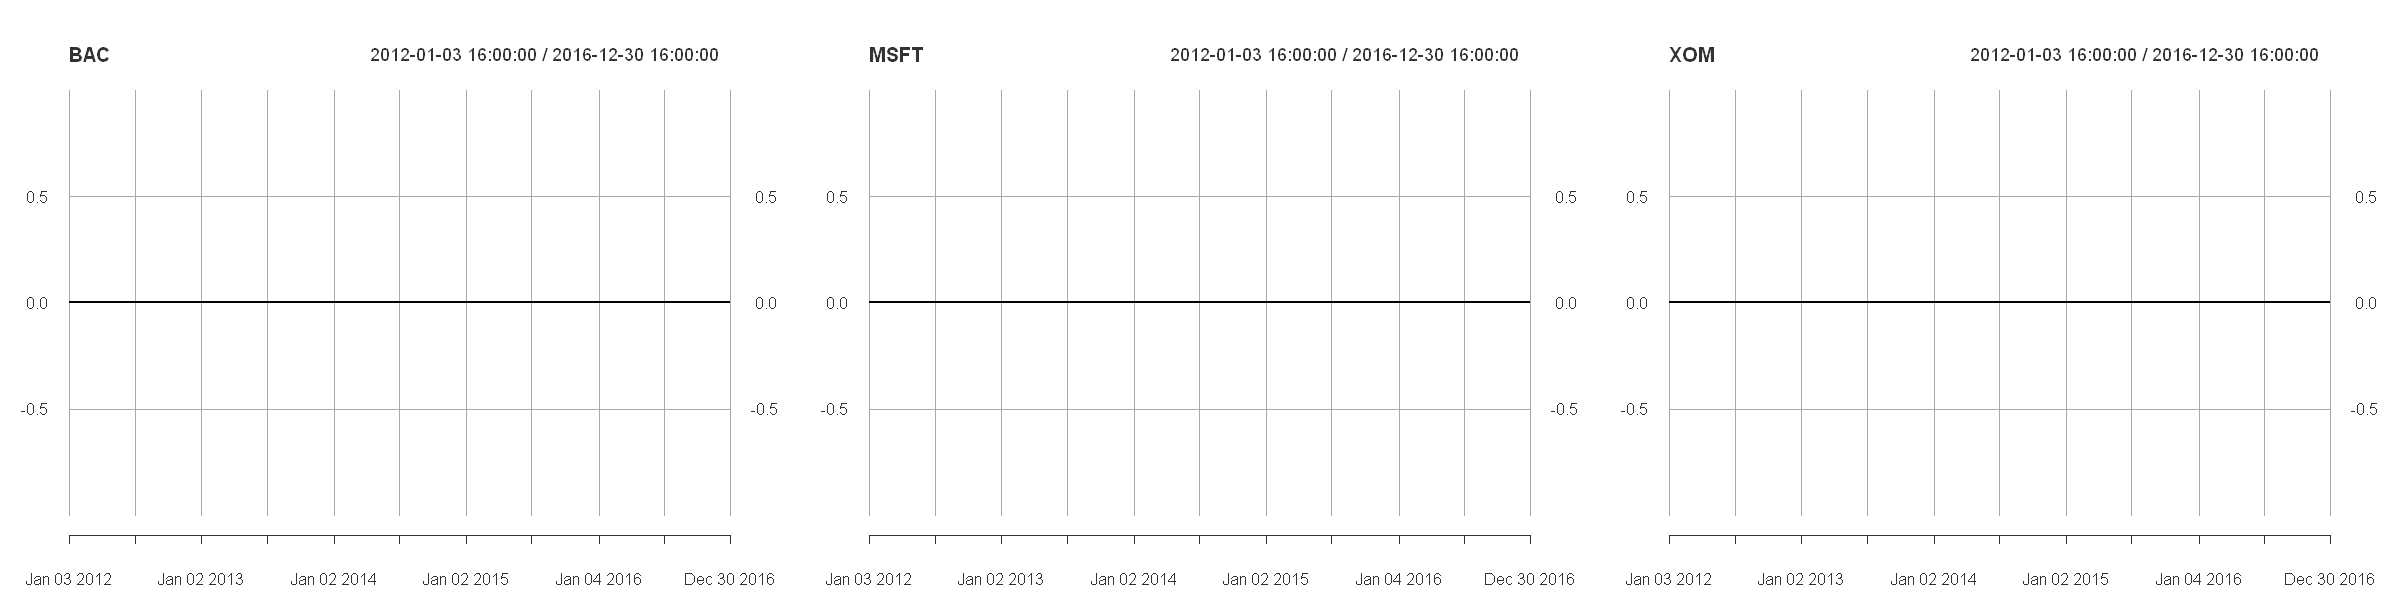

In [56]:
#Plotting the differences
options(repr.plot.width = 20, repr.plot.height = 5) #Enlarging the plot
par(mfrow = c(1, 3))
for (i in 1:3) {
    print(plot(real_var_from_5min_prices[[i]] - real_var_from_5min_returns[[i]], main = stock_names[i]))
}

As can be seen, there are no differences between the series which is a satisfactory result.

#### 5.

Calculating Realized Variance for the subperiods.

In [57]:
#Calculating Realized Variance for the sub-periods
real_var_subsets_5min <- vector("list", 3) #Empty vector for the results
for (i in 1:3) { #Looping through the tickers
    real_var_subsets_indiv <- vector("list", 3) #Empty list for the results for each ticker
    for (j in 1:3) { #Looping through the sub-periods
        real_var_subsets_indiv[[j]] <- rCov(na.omit(hw3_data_5min_returns[[i]][sub_periods[j]]), makeReturns = FALSE) #Calculating RV from the subset
    }
    real_var_subsets_5min[[i]] <- real_var_subsets_indiv #Storing the results
}

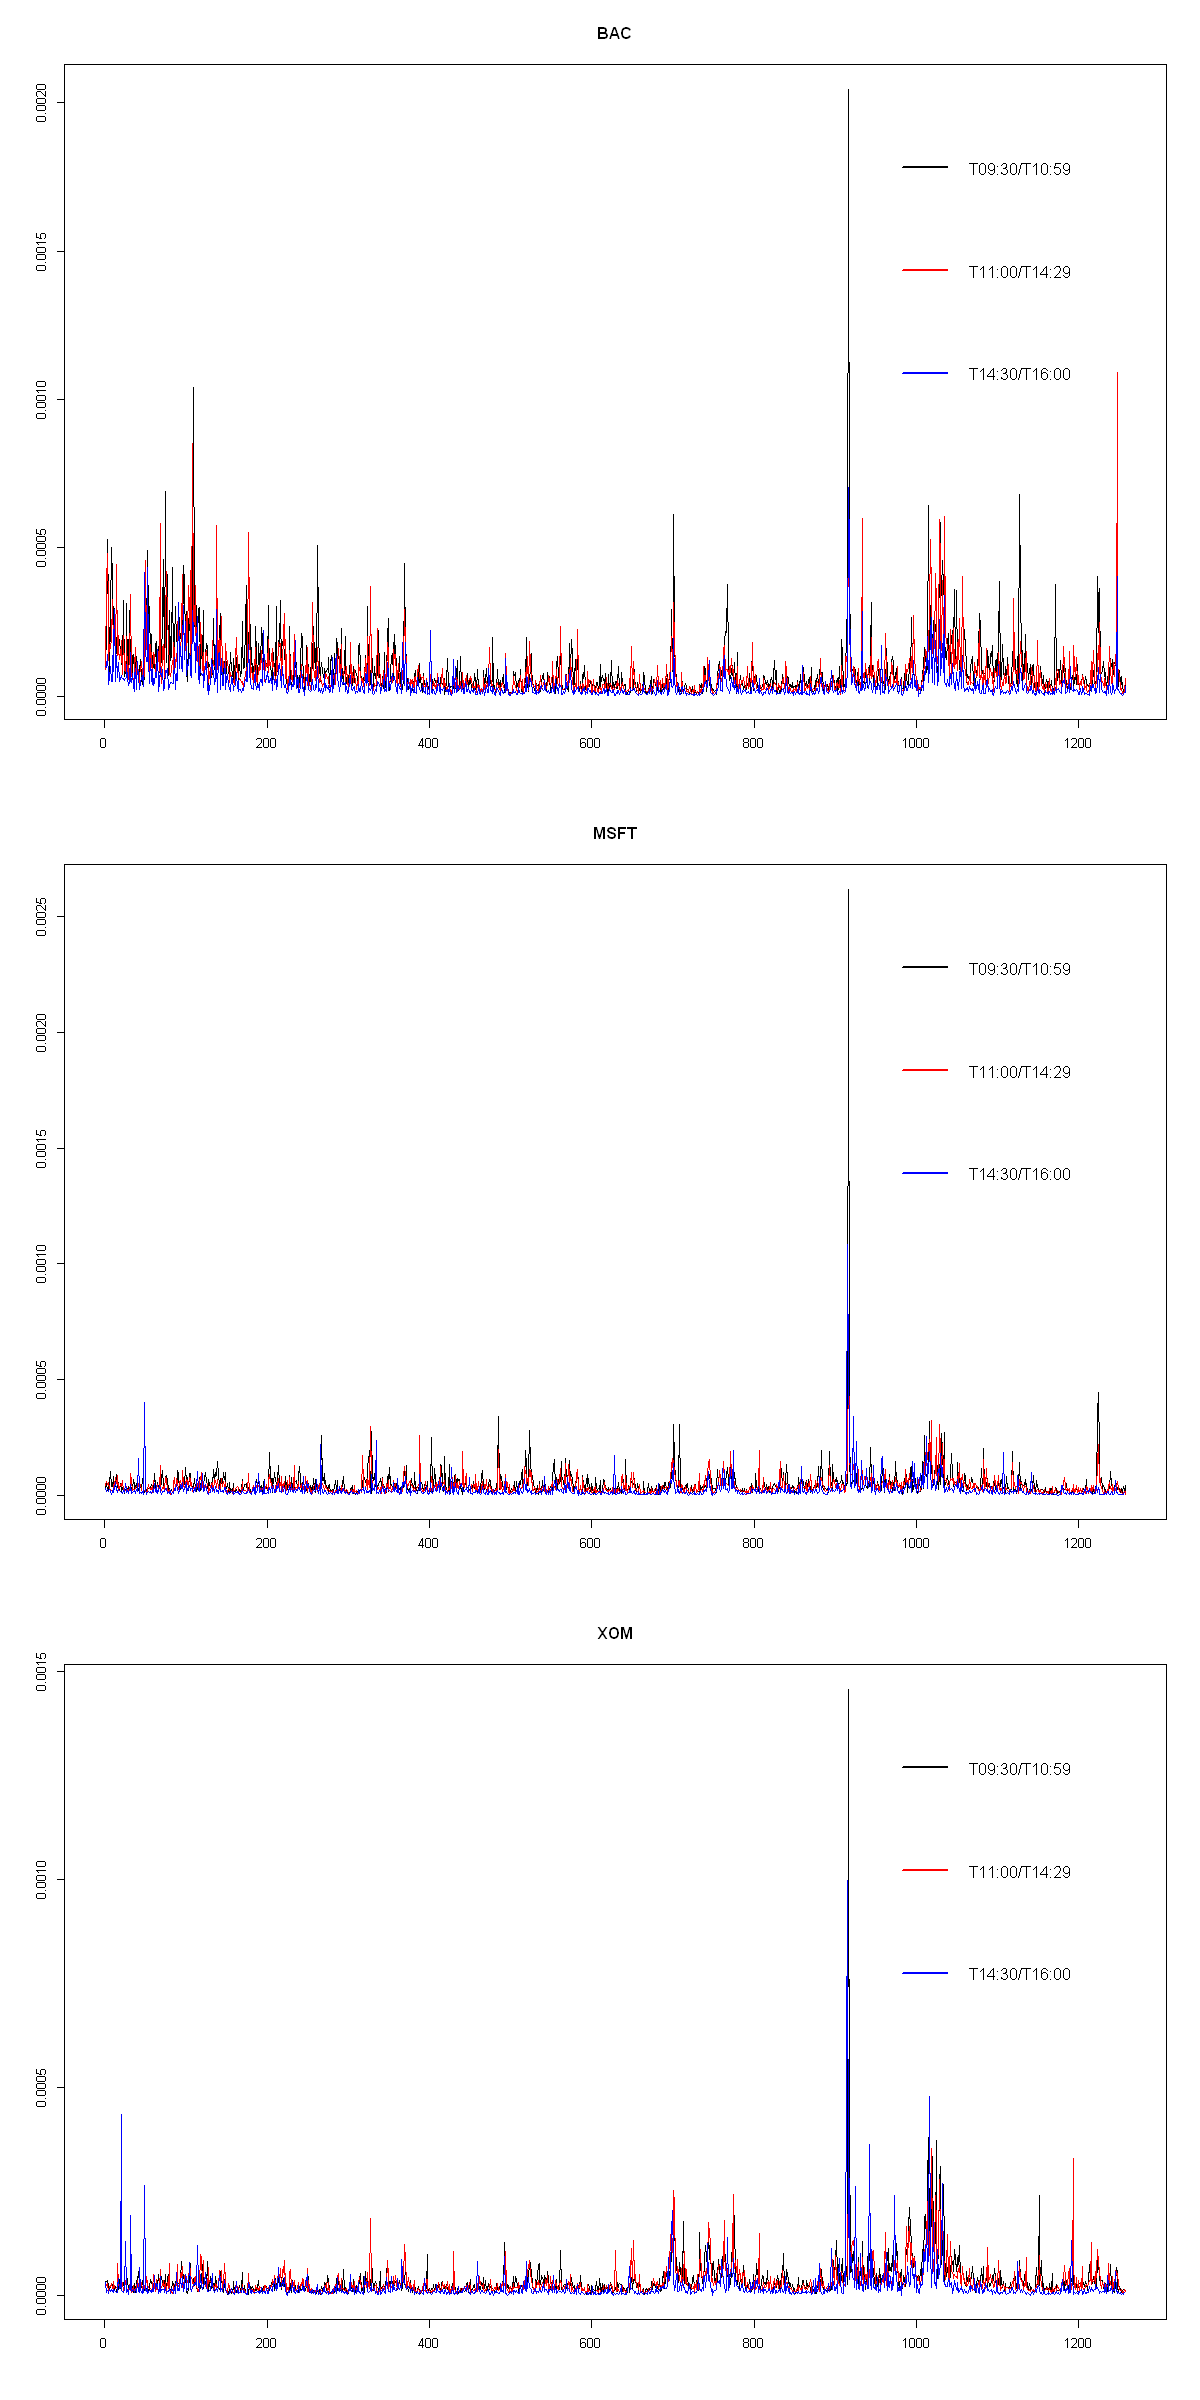

In [58]:
#Plotting
options(repr.plot.width = 10, repr.plot.height = 20)
par(mfrow = c(3, 1)) #Setting up the grid
for (i in 1:3) { #Looping through the tickers
    plot(as.numeric(real_var_subsets_5min[[i]][[1]]), type = "l", xlab = "", ylab = "", main = stock_names[i])
    lines(as.numeric(real_var_subsets_5min[[i]][[2]]), col = "red")
    lines(as.numeric(real_var_subsets_5min[[i]][[3]]), col = "blue")
    legend("topright", sub_periods, col = c("black", "red", "blue"), lty = 1, bty = "n", cex = 1.2, lwd = 2)
}

At the first glance, the plots seem to be identical to those in the previous Problem. We will inspect this further when comparing the results. Once again, we can see that the Realized Variance of BAC seems to be systematically lower in the afternoon.

#### 6.

Summing intraday RV and comparing to daily RV

In [59]:
#Calculating the sum of intraday RV
sum_intraday_RV_5min <- vector("list", 3) #Empty list for sums of intraday RV
for (i in 1:3) { #Looping through the tickers
    time_removed <- lapply(real_var_subsets_5min[[i]], to.daily, OHLC = F) #Removing the time stamp from each subset for easier handling
    subsets_merged <- merge.xts(time_removed[[1]], time_removed[[2]], time_removed[[3]]) #Merging the subsets into a single xts object
    sum_intraday_RV_5min[[i]] <- apply.daily(subsets_merged, sum) #Summing RV for each day
}
#Removing the time stamp from daily RV for easier plotting
daily_RV_5mins <- lapply(real_var_from_5min_returns, to.daily, OHLC = F)

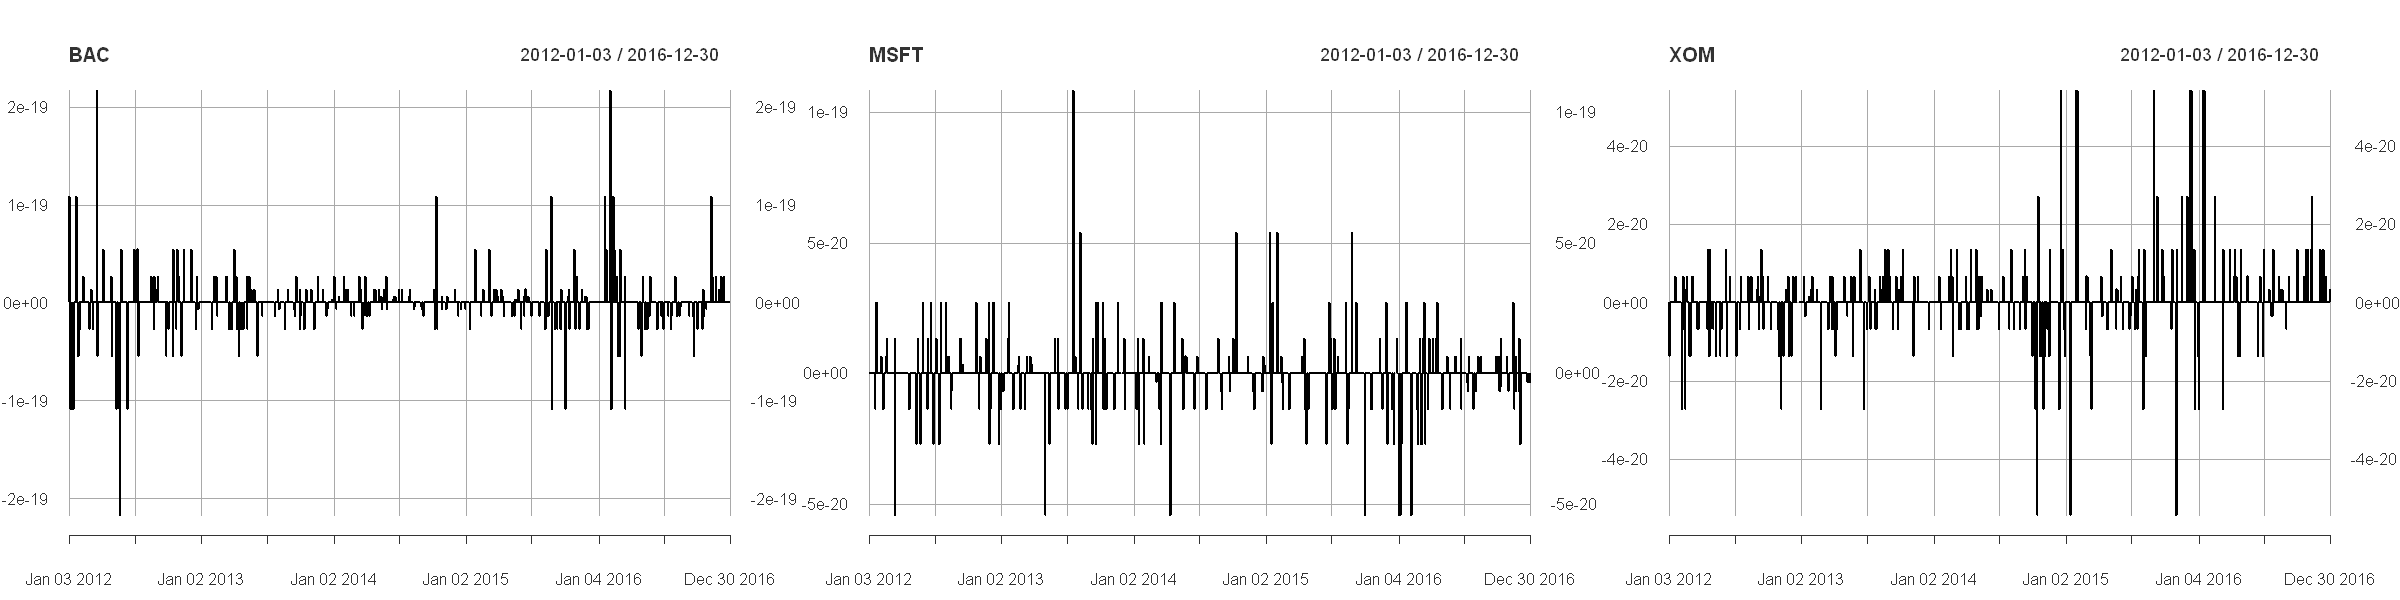

In [60]:
#Plotting the difference
options(repr.plot.width = 20, repr.plot.height = 5) #Enlarging the plot
par(mfrow = c(1, 3)) #Setting up the grid
for (i in 1:3) { #Looping through the tickers
    print(plot(daily_RV_5mins[[i]] - sum_intraday_RV_5min[[i]], main = stock_names[i]))
}

Again, there are some negligible differences.

#### 7.

Calculating the contribution of each subperiod to daily RV

In [61]:
#Calculating the percentage share of each intrady RV in daily RV
percentage_shares_5min <- vector("list", 3) #Empty vector for the results
for (i in 1:3) { #Looping through the tickers
    time_removed <- lapply(real_var_subsets_5min[[i]], to.daily, OHLC = F) #Removing the time stamp from each subset for easier handling
    percentage_shares_list <- lapply(time_removed, function(x) {x / daily_RV_5mins[[i]]}) #Calculating the shares for each subset
    percentage_shares_5min[[i]] <- merge.xts(percentage_shares_list[[1]], percentage_shares_list[[2]], percentage_shares_list[[3]]) #Merging the results into a single xts object (3 shares per day)
    names(percentage_shares_5min[[i]]) <- sub_periods #Renaming the series for plotting
}

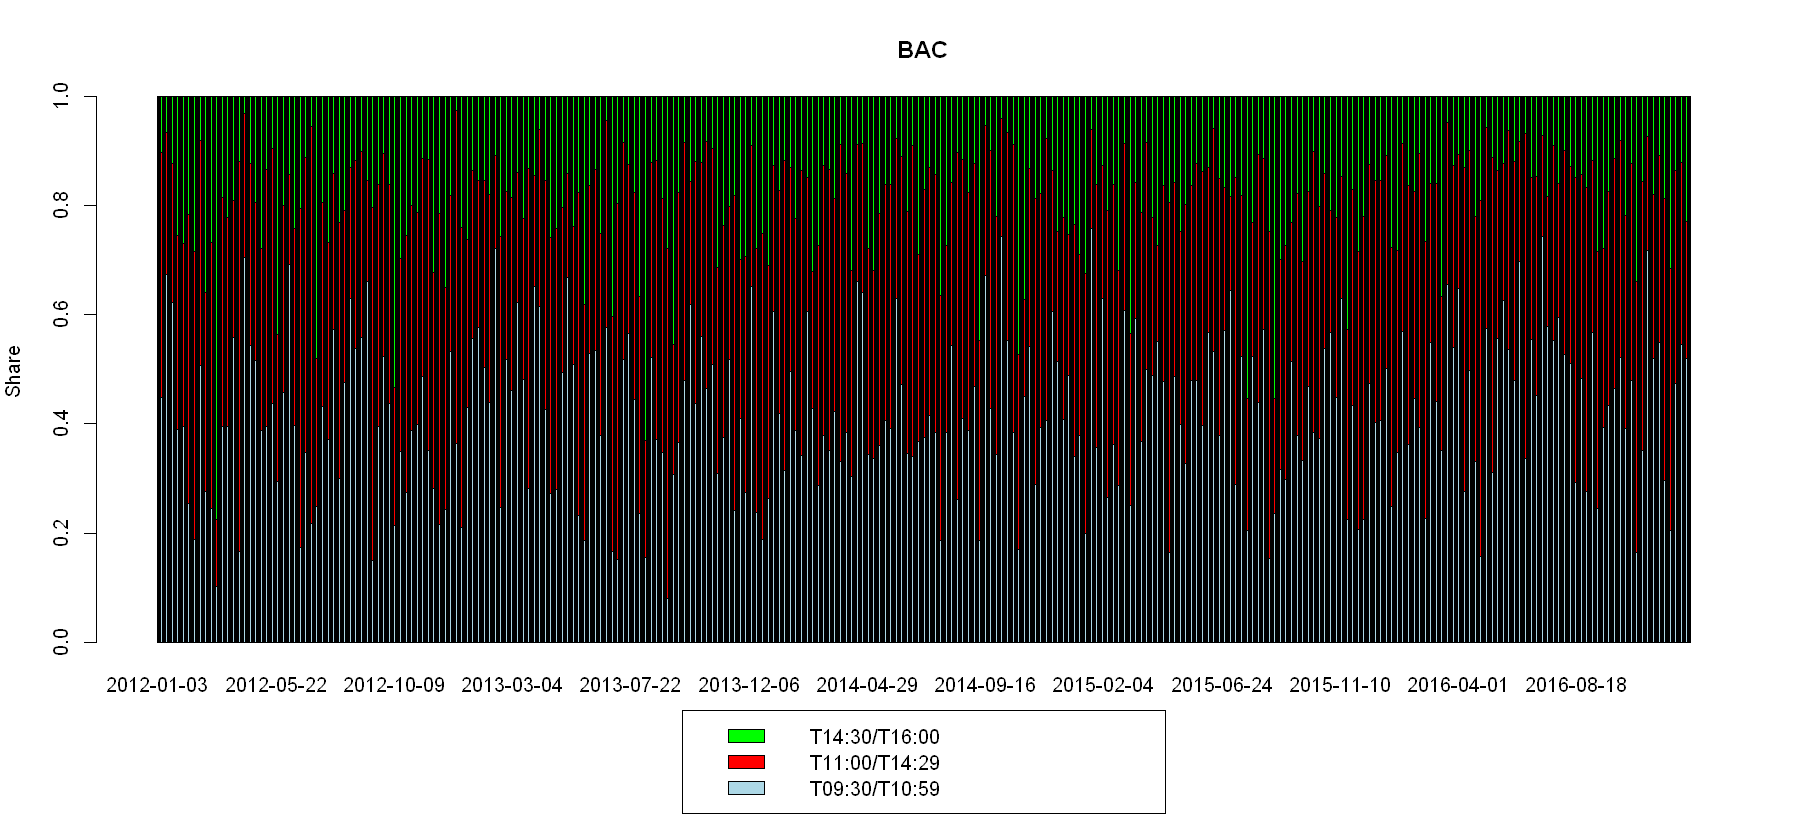

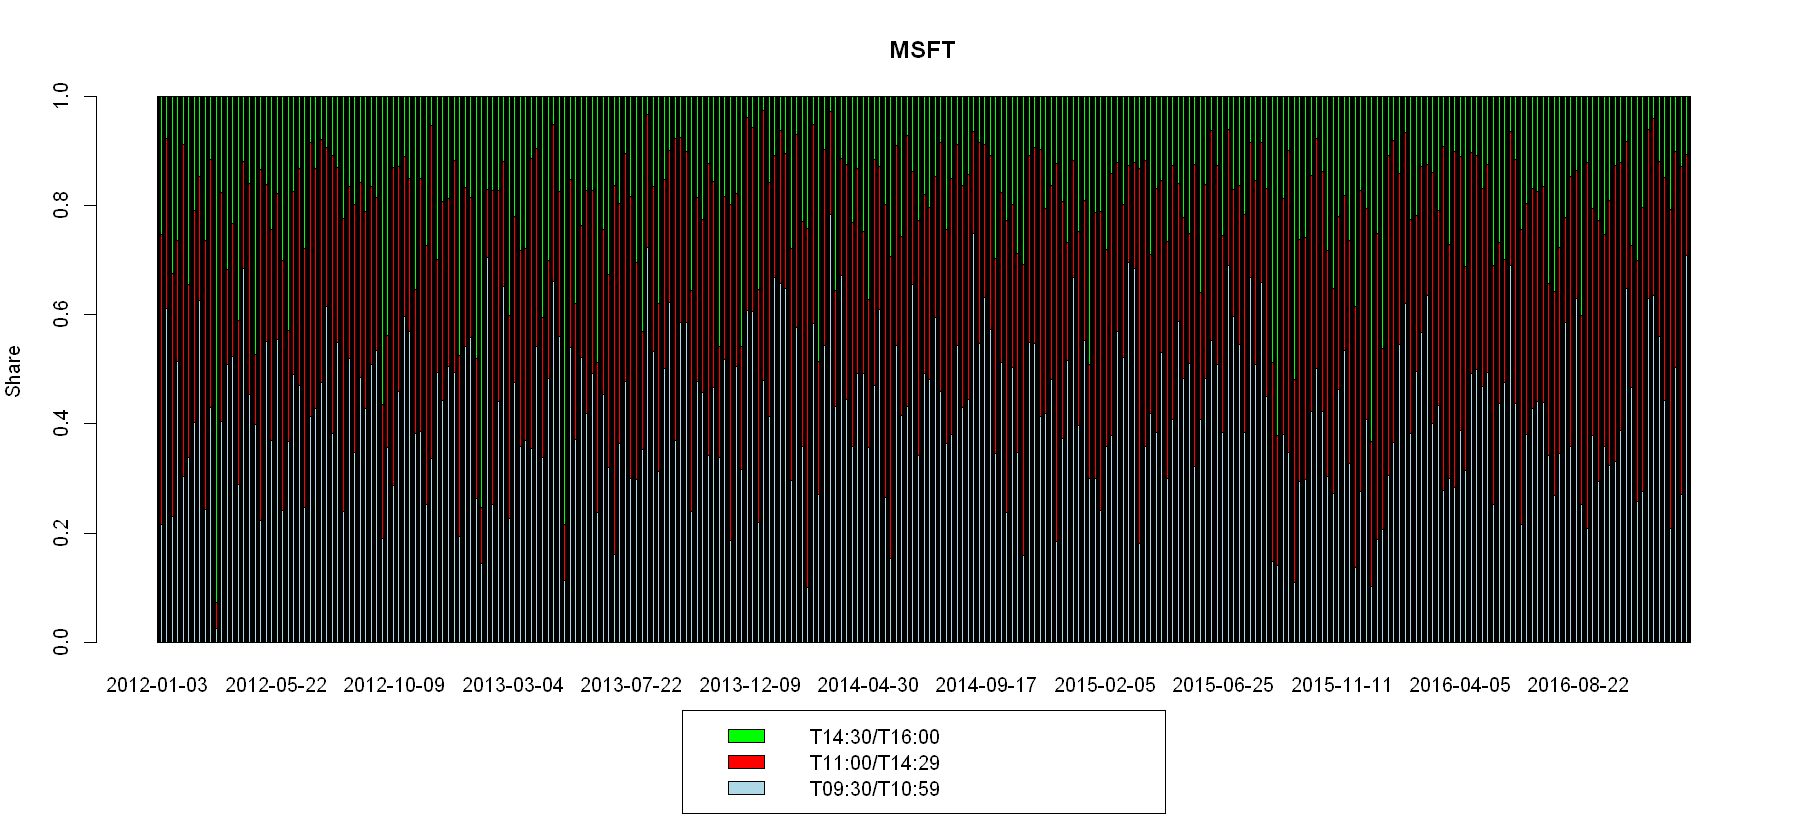

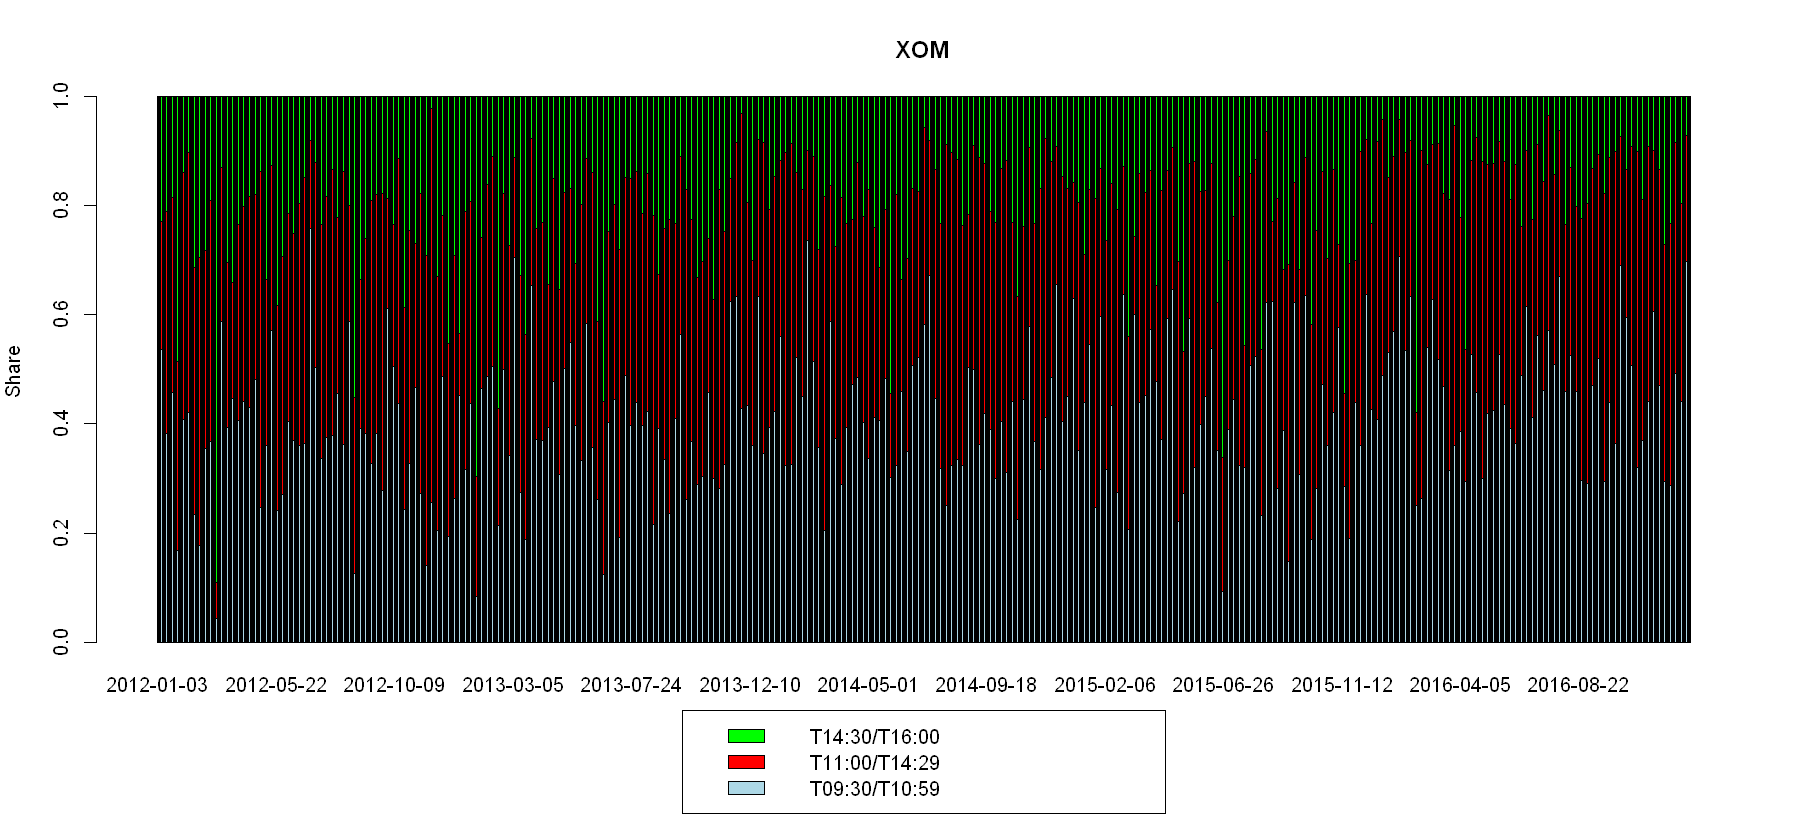

In [62]:
#Plotting
options(repr.plot.width = 15, repr.plot.height = 7)
par(mar = c(8, 4, 4, 2)) #Making a space for the legend
for (i in 1:3) { #Looping through the tickers
    barplot(na.omit(percentage_shares_5min[[i]]), col = c("lightblue", "red", "green"), space = 0, main = stock_names[i], ylab = "Share", legend = T, args.legend = list(x = "bottom", inset = -0.3)) #Omitting 2 NAs that emerged in XOM after merging
}

In [63]:
#Average share of intrady RV for each sub-period
for (i in 1:3) { #Looping through the stocks
    print(stock_names[i])
    for (j in 1:3) { #Looping through the sub-periods
        print(paste(sub_periods[j], ": ", mean(percentage_shares_5min[[i]][, j], na.rm = T)))
    }
}

[1] "BAC"
[1] "T09:30/T10:59 :  0.433544442955942"
[1] "T11:00/T14:29 :  0.38243813170991"
[1] "T14:30/T16:00 :  0.184017425334148"
[1] "MSFT"
[1] "T09:30/T10:59 :  0.423086555210627"
[1] "T11:00/T14:29 :  0.371485357176018"
[1] "T14:30/T16:00 :  0.205755202402549"
[1] "XOM"
[1] "T09:30/T10:59 :  0.407417527030115"
[1] "T11:00/T14:29 :  0.381900350163376"
[1] "T14:30/T16:00 :  0.211017603893781"


Not surprisingly, 5 minutes data tell the same story as 1 minute data. The last period has the greatest share of daily Realized Variance. There are some small numerical differences, but the ordering remains identical.

#### 8.

We repeat the procedure in 5, 6, and 7 for raw prices.

In [64]:
#Checking the number of observations for each sub-period within each day
for (i in 1:3) { #Looping through the tickers
    for (j in 1:3) { #Looping throught the sub-periods
        days_holder <- split(hw3_data_5min[[i]][sub_periods[j]], "days") #Splitting the sub-periods by days 
        for (k in days_holder) { #For each day
            if (length(k) == 1) { #If there is only a single day
                index_to_remove <- which(index(hw3_data_5min[[i]]) == as.POSIXct(index(k), tz = "UTC")) #Extract the index to remove
                hw3_data_5min[[i]] <- hw3_data_5min[[i]][-index_to_remove] #Remove the specific observation
                print(paste("Removed observation", index(k), "from sub-period", sub_periods[j], "from ticker", stock_names[i])) #Print what was removed
            }
        }
    }
}

In [65]:
#Calculating Realized Variance for the sub-periods
real_var_subsets_from_prices_5min <- vector("list", 3) #Empty vector for the results
for (i in 1:3) { #Looping through the tickers
    real_var_subsets_from_prices_5min_indiv <- vector("list", 3) #Empty list for the results for each ticker
    for (j in 1:3) { #Looping through the sub-periods
        real_var_subsets_from_prices_5min_indiv[[j]] <- rCov(hw3_data_5min[[i]][sub_periods[j]], makeReturns = TRUE) #Calculating RV on the subset
    }
    real_var_subsets_from_prices_5min[[i]] <- real_var_subsets_from_prices_5min_indiv #Storing the results
}

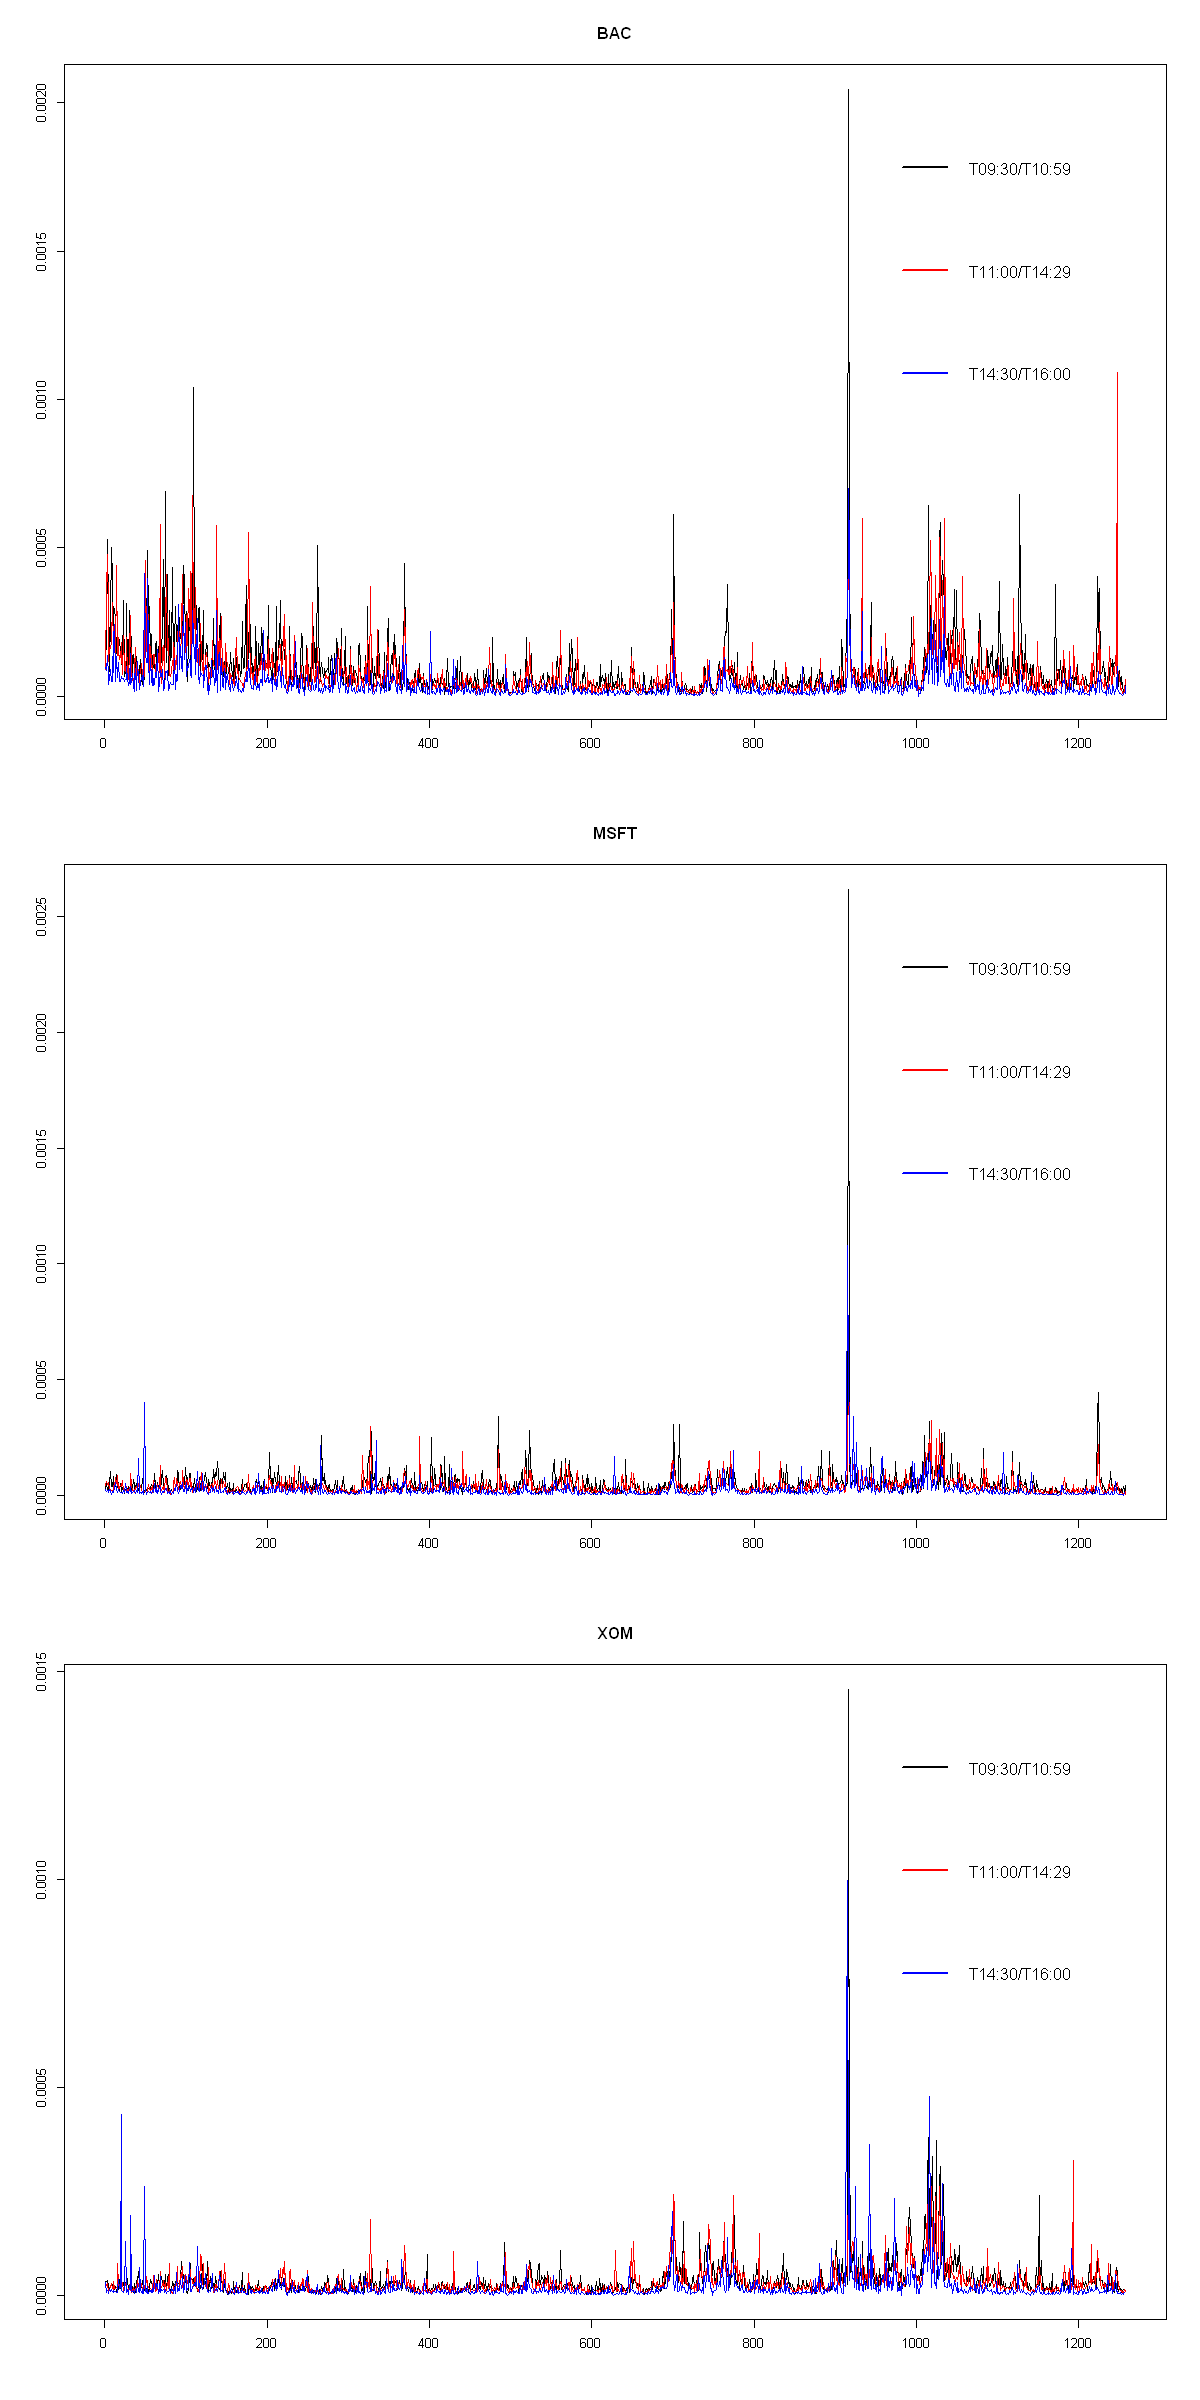

In [66]:
#Plotting
options(repr.plot.width = 10, repr.plot.height = 20)
par(mfrow = c(3, 1)) #Setting up the grid
for (i in 1:3) { #Looping through the tickers
    plot(as.numeric(real_var_subsets_from_prices_5min[[i]][[1]]), type = "l", xlab = "", ylab = "", main = stock_names[i])
    lines(as.numeric(real_var_subsets_from_prices_5min[[i]][[2]]), col = "red")
    lines(as.numeric(real_var_subsets_from_prices_5min[[i]][[3]]), col = "blue")
    legend("topright", sub_periods, col = c("black", "red", "blue"), lty = 1, bty = "n", cex = 1.2, lwd = 2)
}

In [67]:
#Calculating the sum of intraday RV from prices
sum_intraday_RV_from_prices_5min <- vector("list", 3) #Empty list for sums of intraday RV
for (i in 1:3) { #Looping through the tickers
    time_removed <- lapply(real_var_subsets_from_prices_5min[[i]], to.daily, OHLC = F) #Removing the time stamp from each subset for easier handling
    subsets_merged <- merge.xts(time_removed[[1]], time_removed[[2]], time_removed[[3]]) #Merging the subsets into a single xts object
    sum_intraday_RV_from_prices_5min[[i]] <- apply.daily(subsets_merged, sum) #Summing RV for each day
}
#Removing the time stamp from daily RV for easier plotting
daily_RV_from_prices_5min <- lapply(real_var_from_5min_prices, to.daily, OHLC = F)

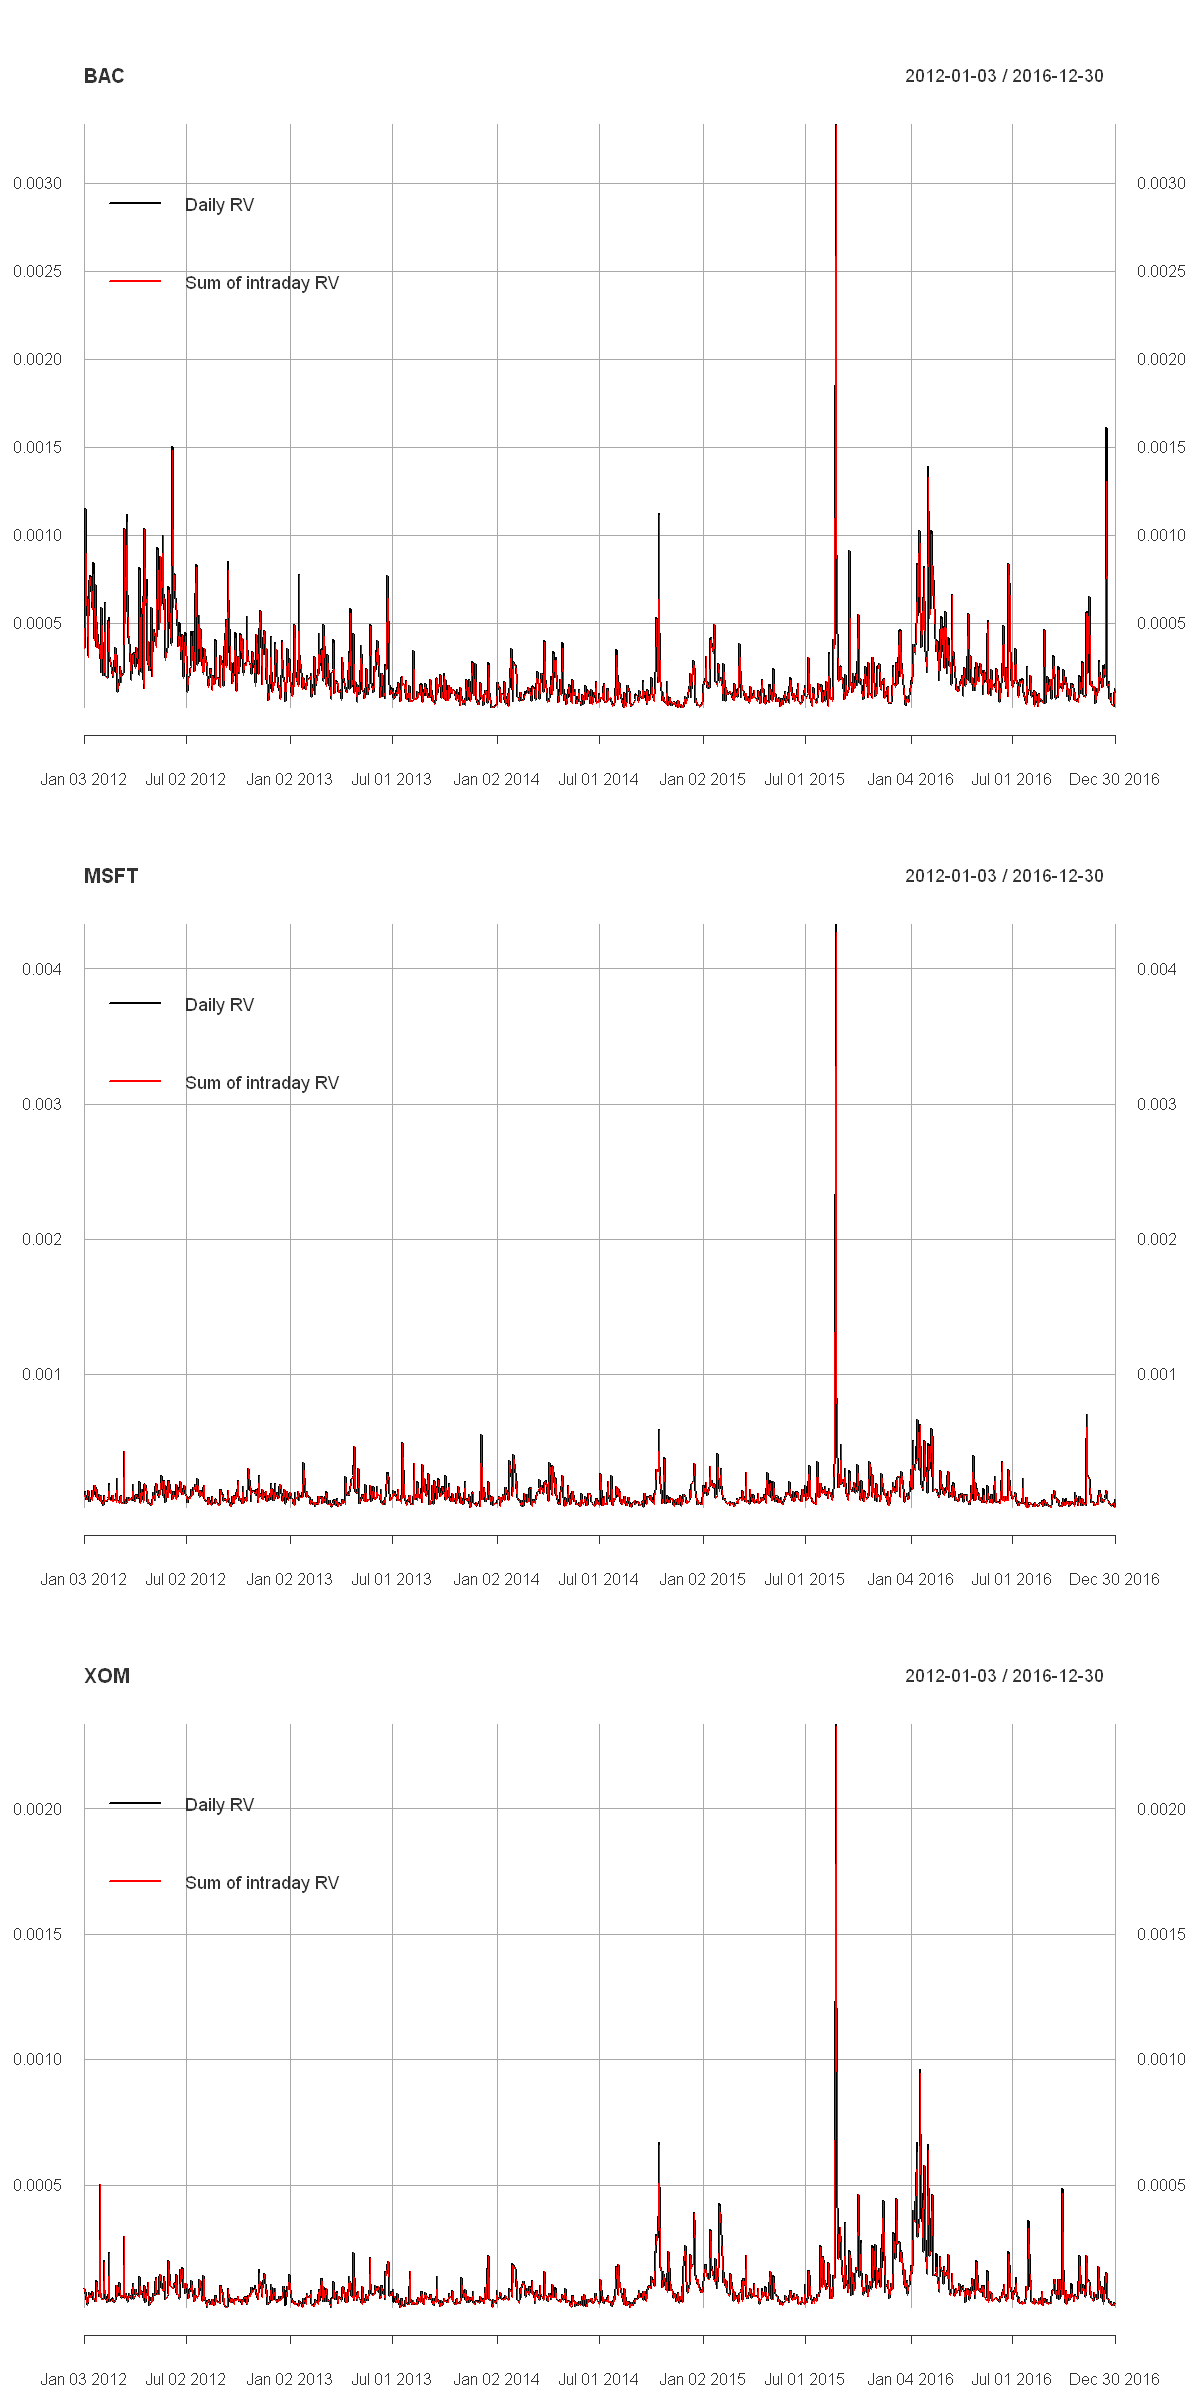

In [68]:
#Plotting
par(mfrow = c(3, 1)) #Setting up the grid
for (i in 1:3) { #Looping through the tickers
    plot_holder <- plot(daily_RV_from_prices_5min[[i]], main = stock_names[i])
    plot_holder <- lines(sum_intraday_RV_from_prices_5min[[i]], col = "red")
    plot_holder <- addLegend("topleft", on = 1, legend.names = c("Daily RV", "Sum of intraday RV"), col = c("black", "red"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}

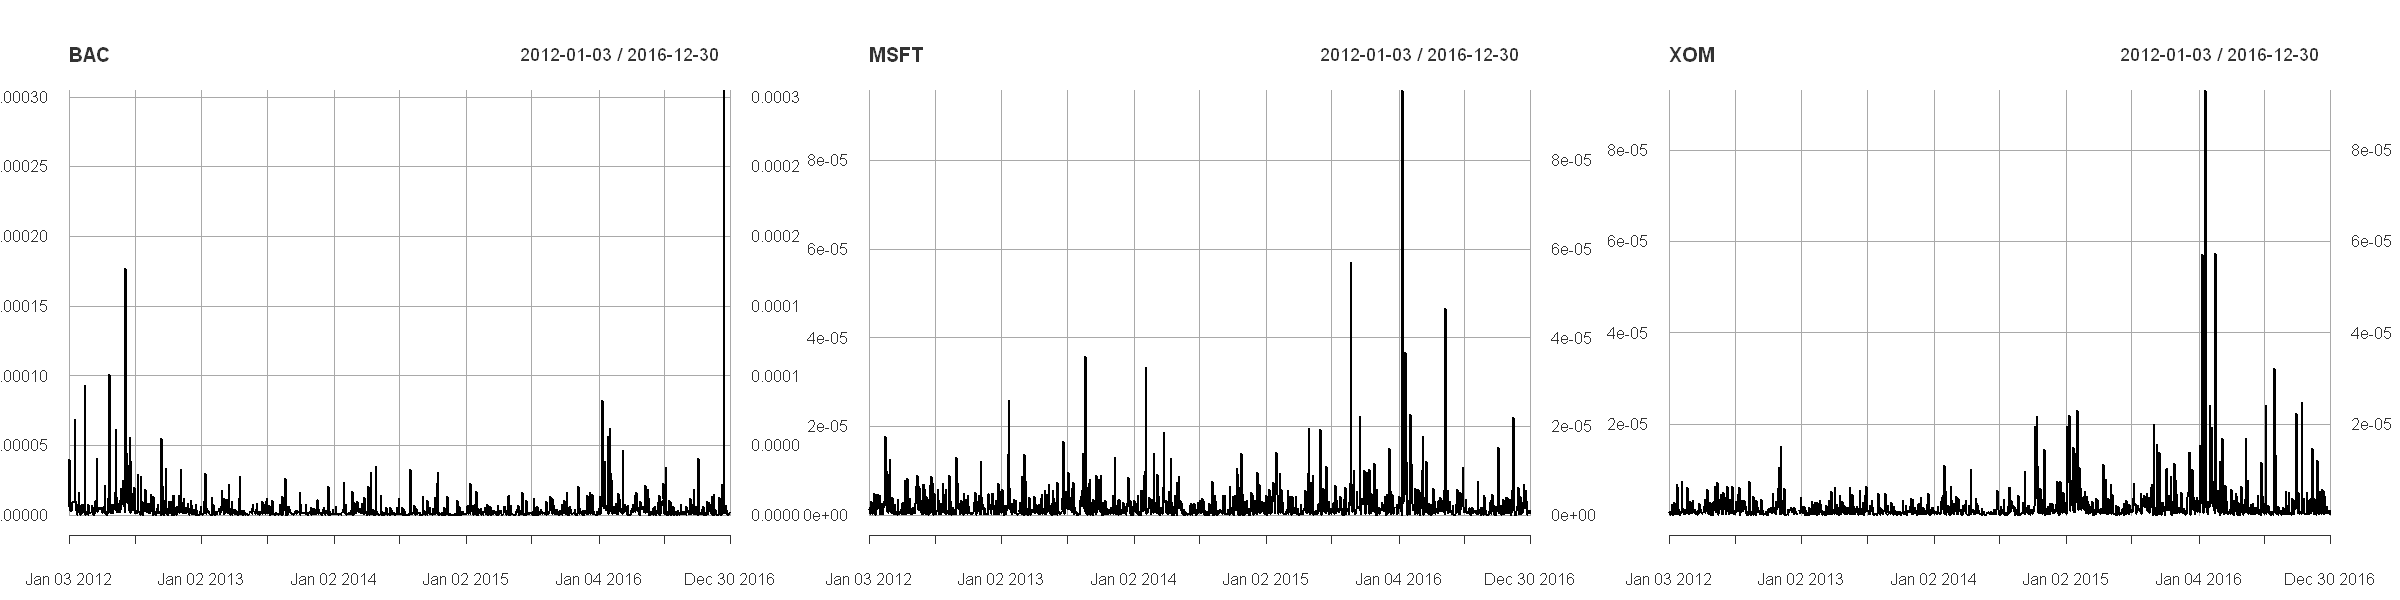

In [69]:
#Plotting the difference
options(repr.plot.width = 20, repr.plot.height = 5)
par(mfrow = c(1, 3)) #Setting up the grid
for (i in 1:3) { #Looping through the tickers
    print(plot(daily_RV_from_prices_5min[[i]] - sum_intraday_RV_from_prices_5min[[i]], main = stock_names[i]))
}

As for 1 minute prices, there are some differences caused by the reversed order of subsetting and calculating returns.

In [70]:
#Calculating the percentage share of each intrady RV in daily RV from prices
percentage_shares_from_prices_5min <- vector("list", 3) #Empty vector for the results
for (i in 1:3) { #Looping through the tickers
    time_removed <- lapply(real_var_subsets_from_prices_5min[[i]], to.daily, OHLC = F) #Removing the time stamp from each subset for easier handling
    percentage_shares_list <- lapply(time_removed, function(x) {x / daily_RV_from_prices_5min[[i]]}) #Calculating the shares for each subset
    percentage_shares_from_prices_5min[[i]] <- merge.xts(percentage_shares_list[[1]], percentage_shares_list[[2]], percentage_shares_list[[3]]) #Merging the results into a single xts object (3 shares per day)
    names(percentage_shares_from_prices_5min[[i]]) <- sub_periods #Renaming the series for plotting
}

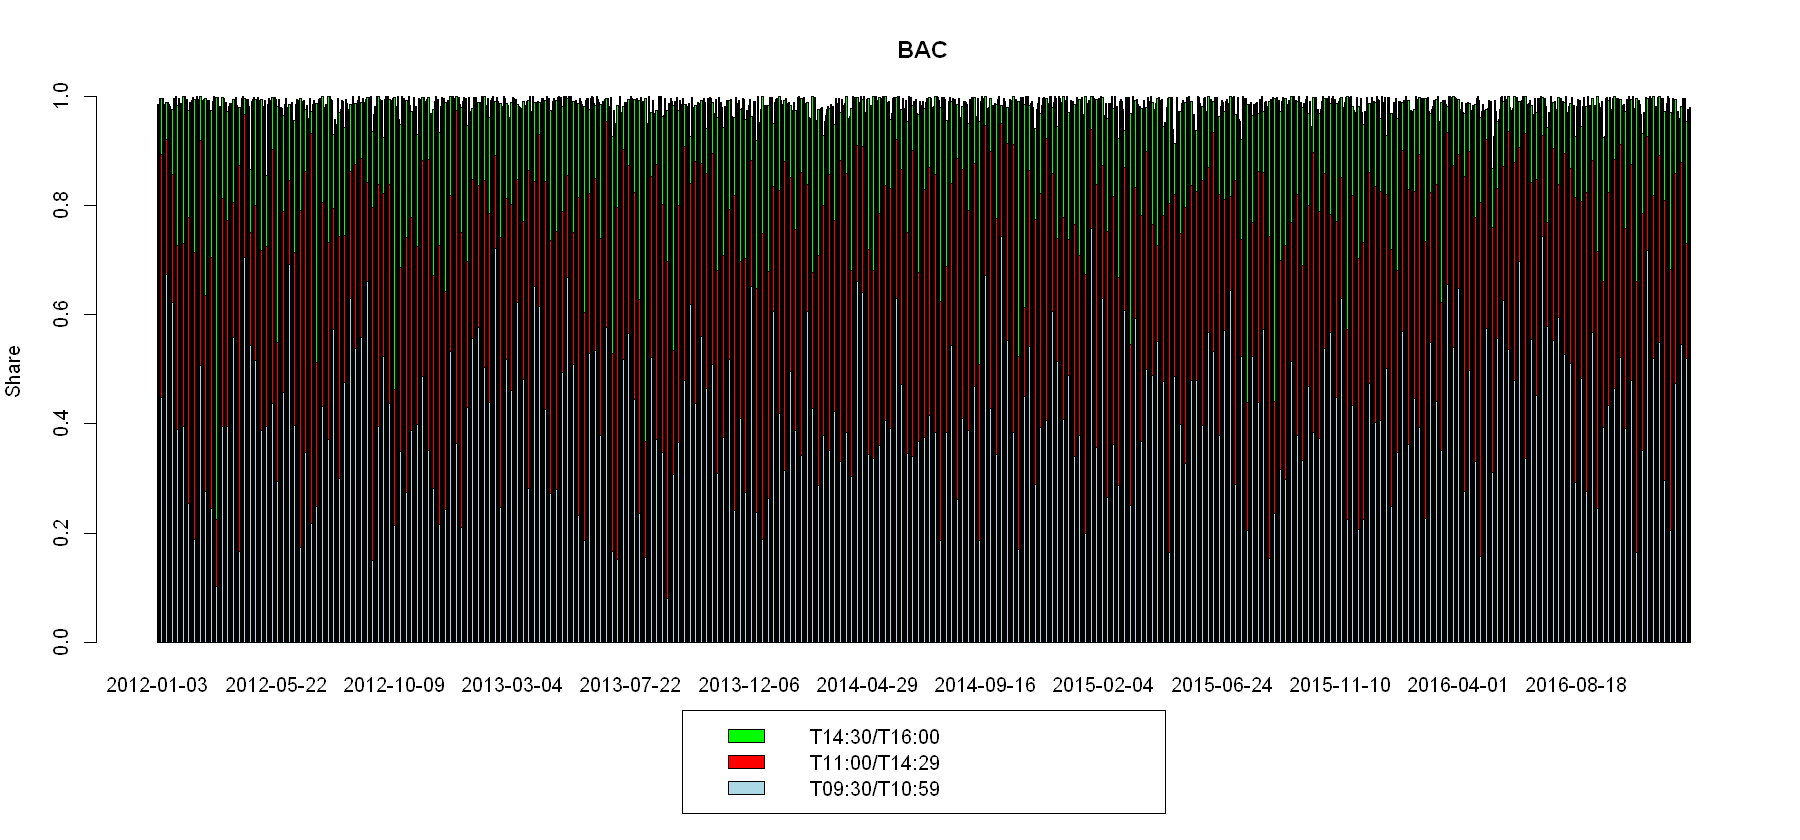

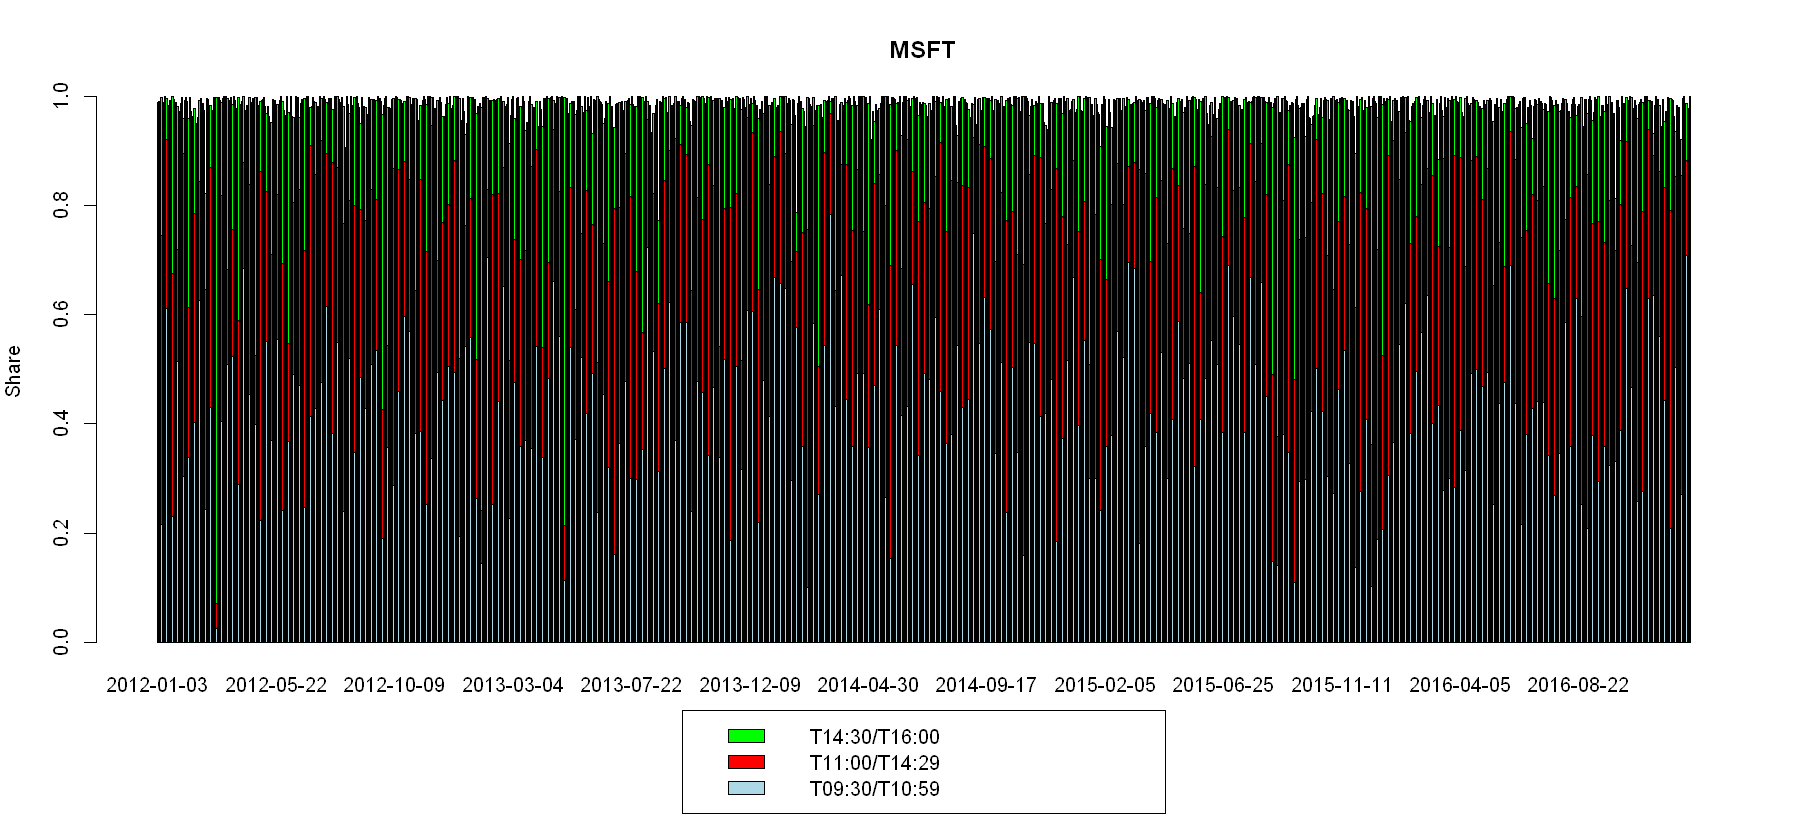

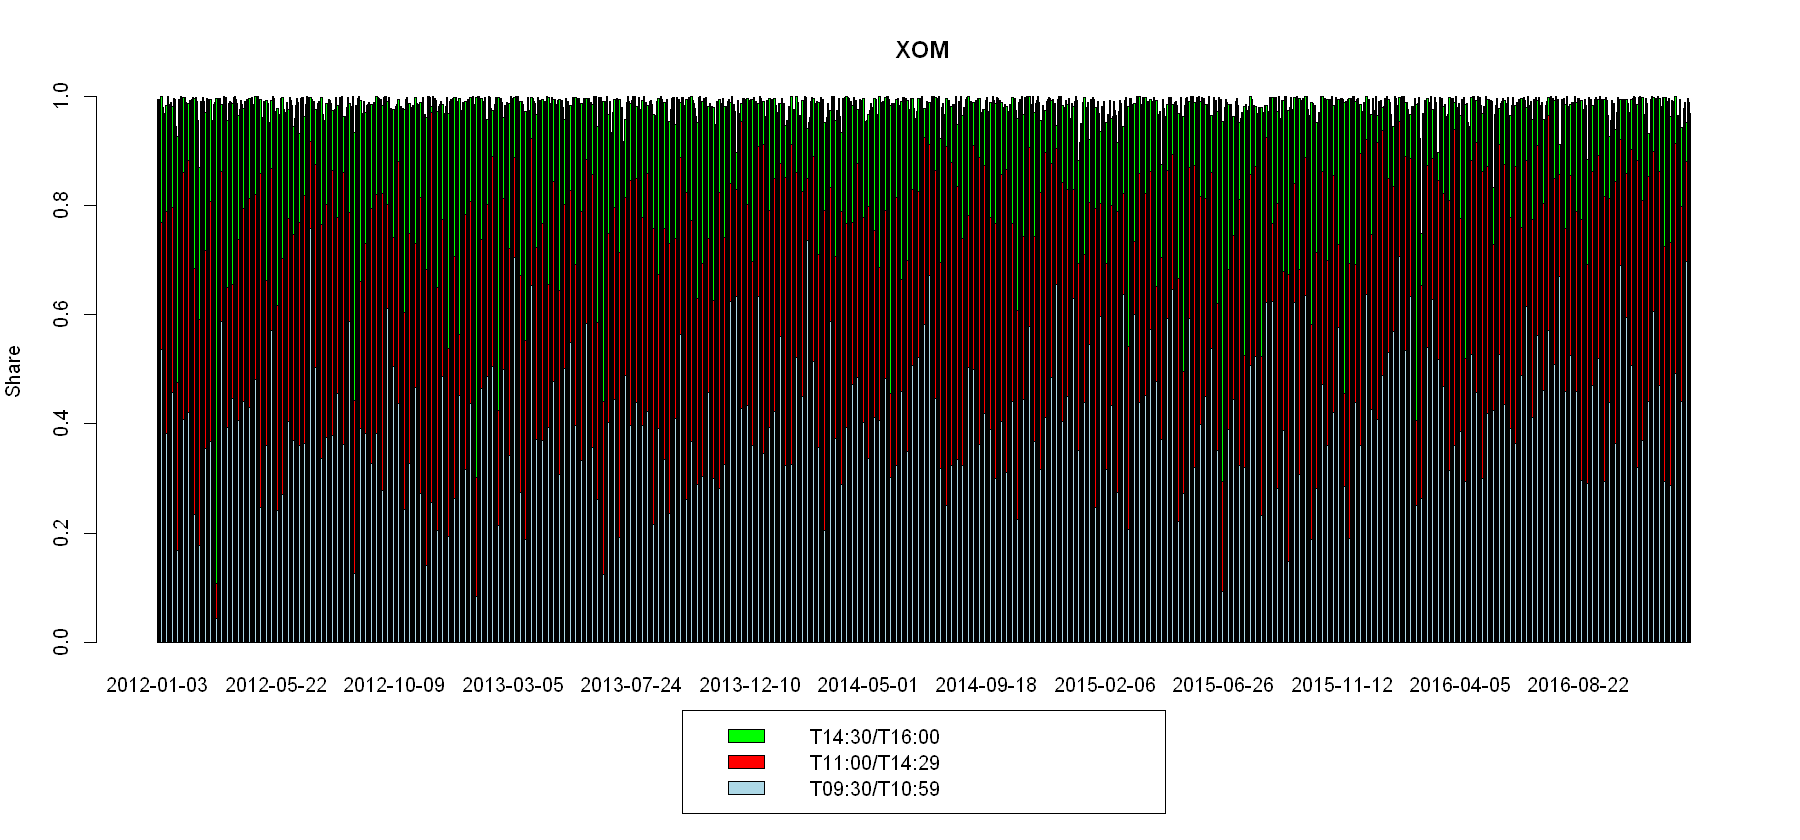

In [71]:
#Plotting
options(repr.plot.width = 15, repr.plot.height = 7)
par(mar = c(8, 4, 4, 2)) #Making a space for the legend
for (i in 1:3) {
    barplot(na.omit(percentage_shares_from_prices_5min[[i]]), col = c("lightblue", "red", "green"), space = 0, main = stock_names[i], ylab = "Share", legend = T, args.legend = list(x = "bottom", inset = -0.3)) #Omitting 2 NAs that emerged in XOM after merging
}

In [72]:
#Average share of intrady RV for each sub-period (calculated from raw prices)
for (i in 1:3) { #Looping through the stocks
    print(stock_names[i])
    for (j in 1:3) { #Looping through the sub-periods
        print(paste(sub_periods[j], ": ", mean(percentage_shares_from_prices_5min[[i]][, j], na.rm = T)))
    }
}

[1] "BAC"
[1] "T09:30/T10:59 :  0.433544442955942"
[1] "T11:00/T14:29 :  0.369022777395488"
[1] "T14:30/T16:00 :  0.175260197938928"
[1] "MSFT"
[1] "T09:30/T10:59 :  0.423086555210627"
[1] "T11:00/T14:29 :  0.357258176538115"
[1] "T14:30/T16:00 :  0.197430665545301"
[1] "XOM"
[1] "T09:30/T10:59 :  0.407417527030115"
[1] "T11:00/T14:29 :  0.367492765928767"
[1] "T14:30/T16:00 :  0.202365587030903"


As can be seen, the conclusions are unchanged. However, for 5 minutes prices, the gaps in the barplots are much more pronounced. This is likely due to the fact that the disregared between-periods returns account for a larger share of the daily returns.

#### 9.

As in the previous problem, we calculate the Bipower Variation and the MedRV estimator.

In [73]:
#Calculating Bipower Variation from prices
bpv_5min <- vector("list", 3)
for (i in 1:3) {
    bpv_5min[[i]] <- rBPCov(hw3_data_5min[[i]], makeReturns = T)
}
#Calculating MedRV from prices
medrv_5min <- vector("list", 3)
for (i in 1:3) {
    medrv_5min[[i]] <- rMedRVar(hw3_data_5min[[i]], makeReturns = T)
}

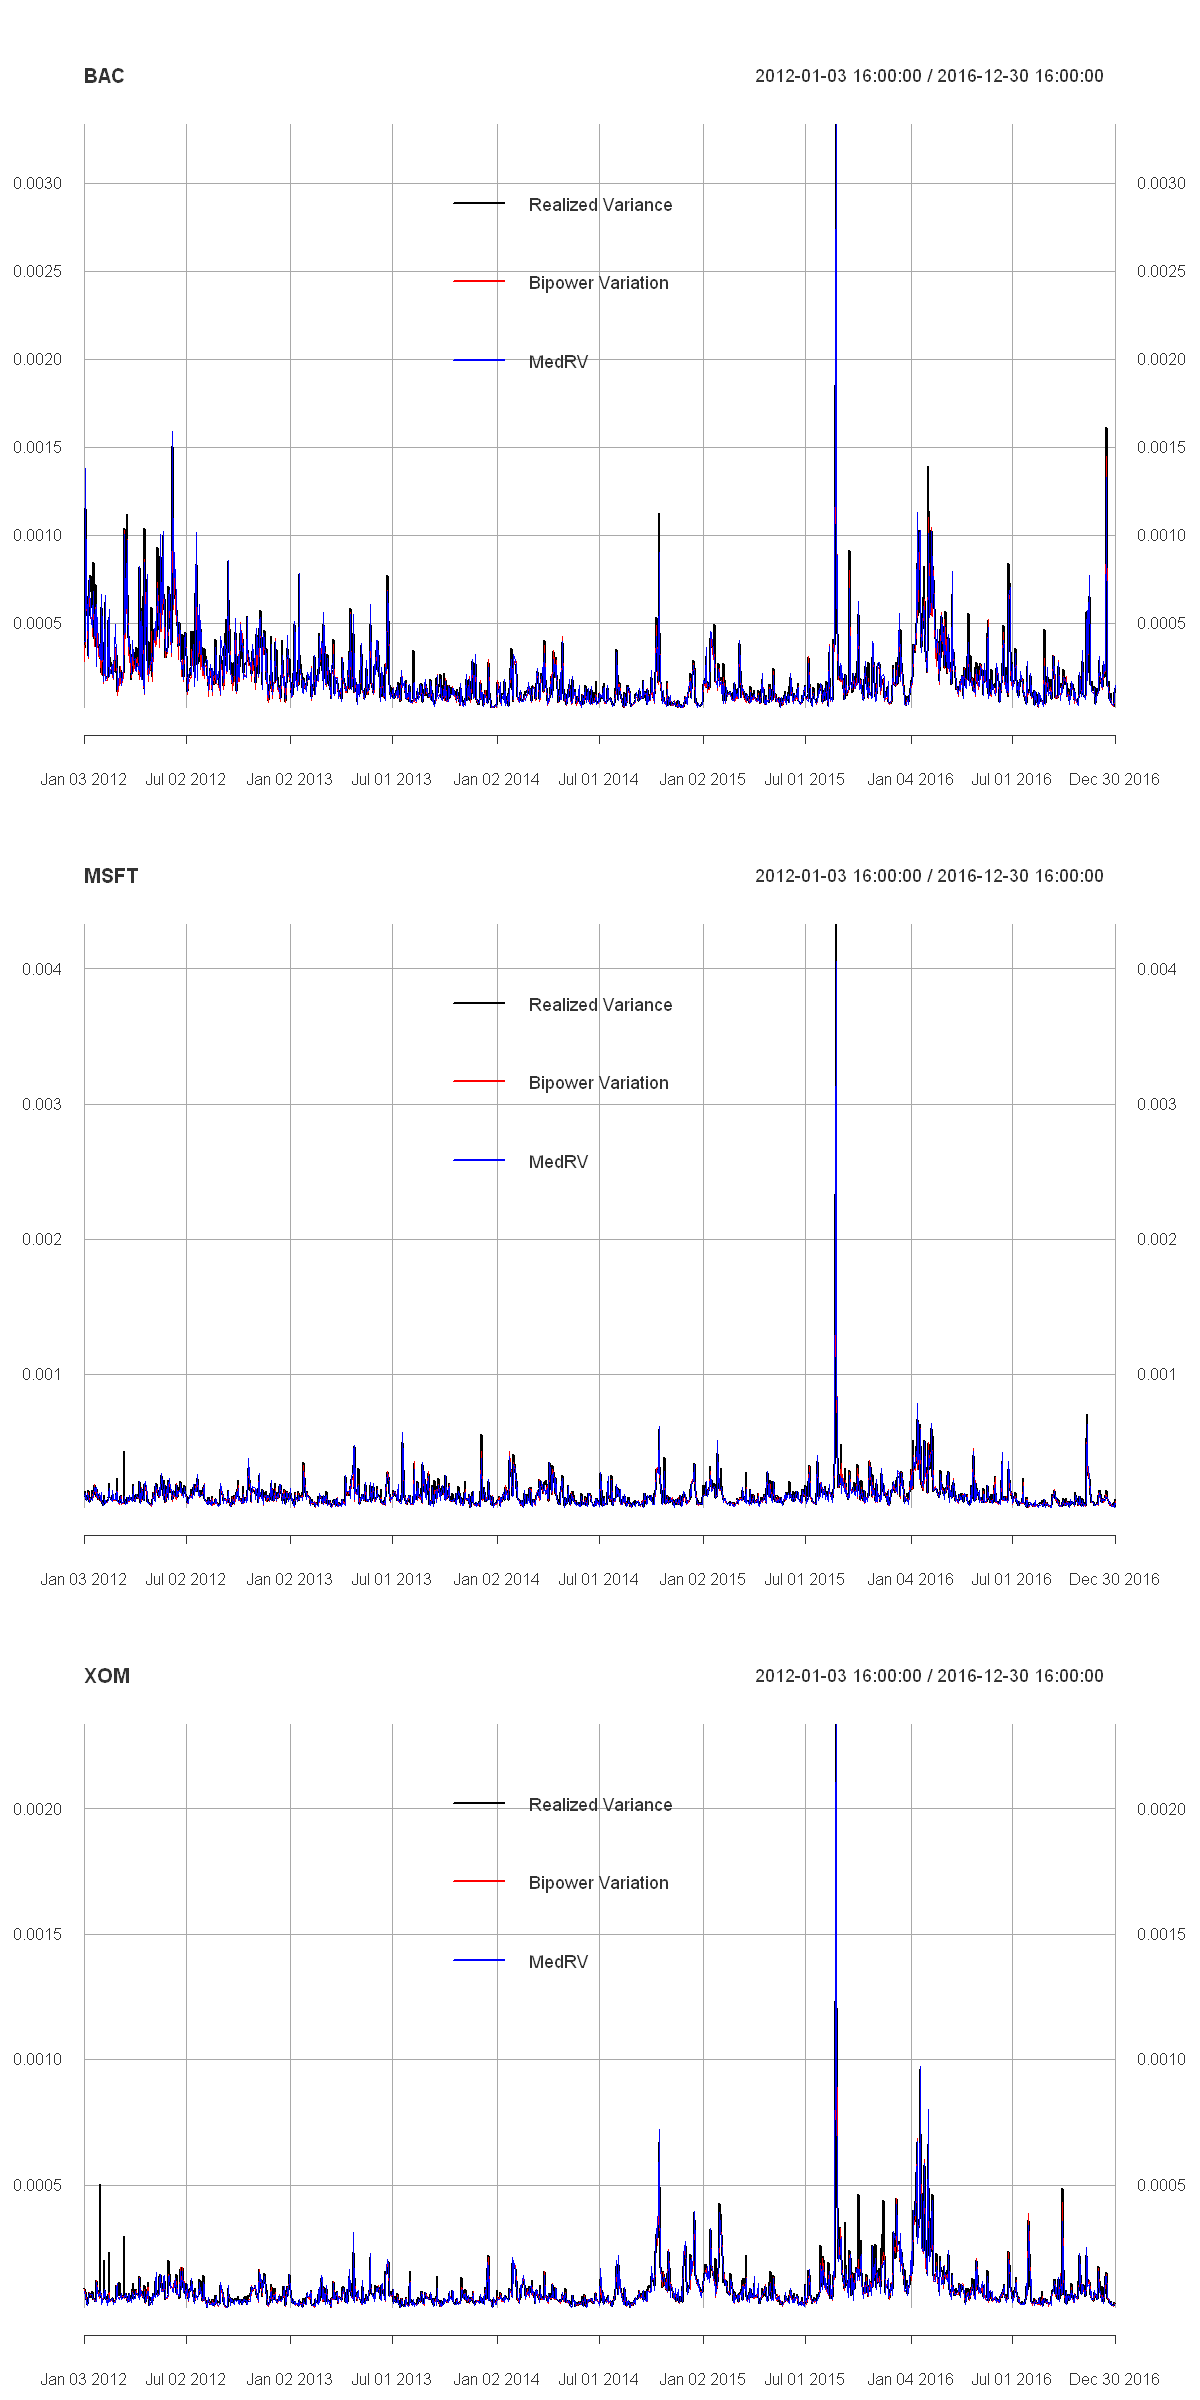

In [74]:
#Plotting the comparison of RV, BPV, MedRv
options(repr.plot.width = 10, repr.plot.height = 20)
par(mfrow = c(3, 1))
for (i in 1:3) { #Looping through the tickers
    plot_holder <- plot(real_var_from_5min_prices[[i]], main = stock_names[i])
    plot_holder <- lines(bpv_5min[[i]], col = "red")
    plot_holder <- lines(medrv_5min[[i]], col = "blue")
    plot_holder <- addLegend("top", on = 1, legend.names = c("Realized Variance", "Bipower Variation", "MedRV"), col = c("black", "red", "blue"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}

From the plots it seems that the Bipower Variation estimates the Realized Variance more precisely when using 5 minutes prices. The same likely applies to the MedRV estimator. There are some occasional differences between the series but they are less pronounced than for 1 minute prices. We could attribute this fact to the decreased presence of noise in the 5 minutes prices. We can support our suspicions by calculating the jumps.

In [75]:
#Calculating the jumps
jumps_5min <- vector("list", 3)
for (i in 1:3) {
    jumps_5min[[i]] <- real_var_from_5min_prices[[i]] - bpv_5min[[i]]
}

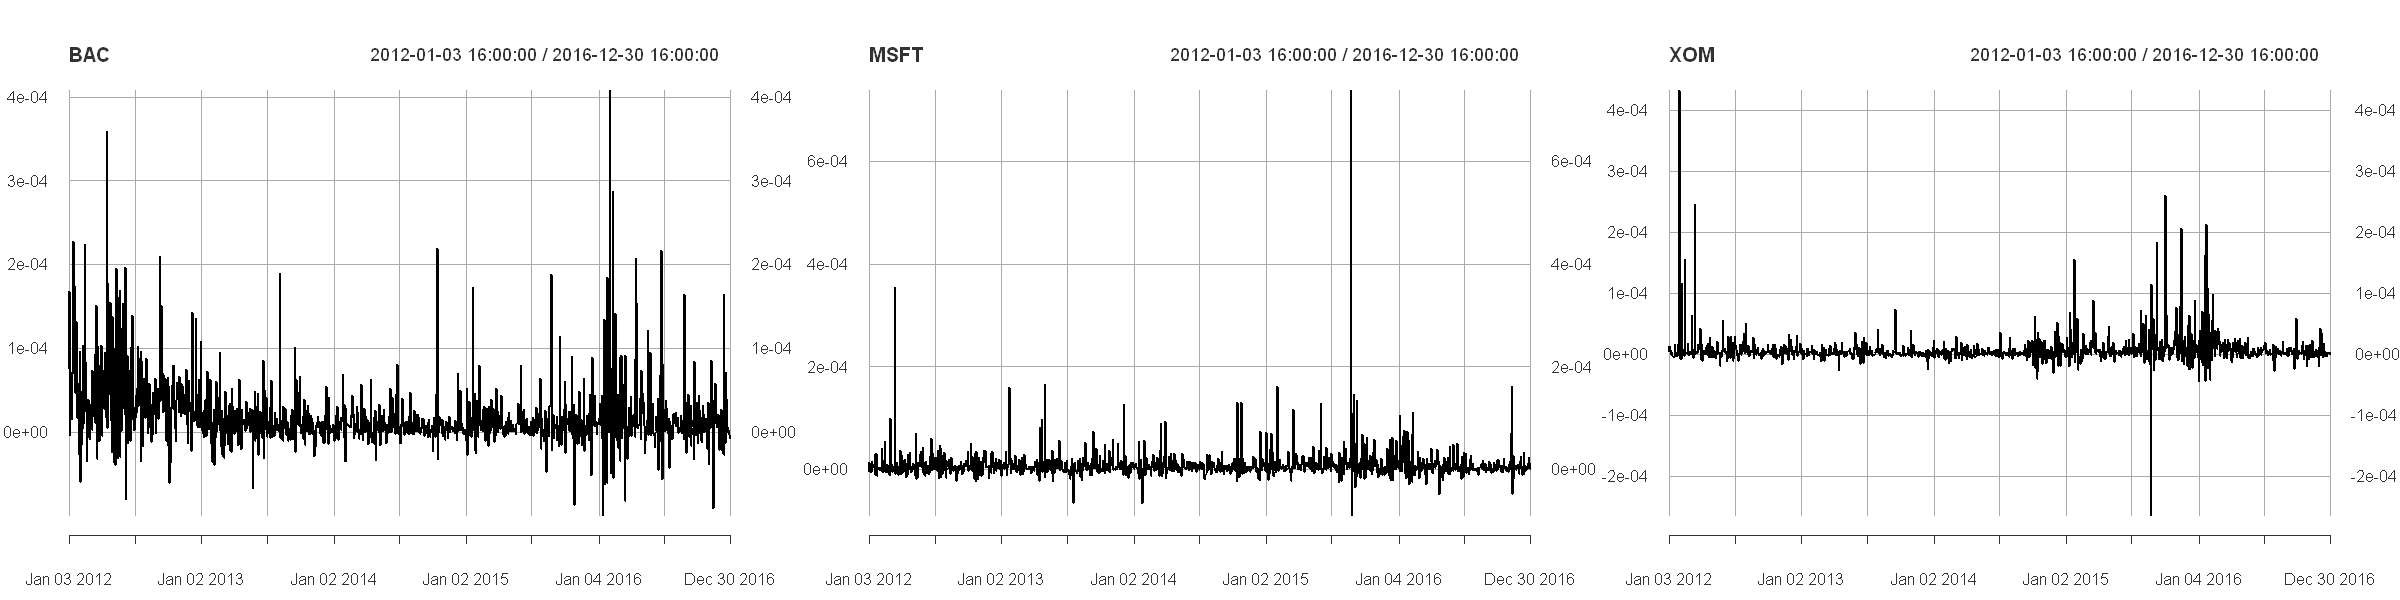

In [76]:
#Plotting the jumps
options(repr.plot.width = 20, repr.plot.height = 5)
par(mfrow = c(1, 3))
for (i in 1:3) {
    print(plot(jumps_5min[[i]], main = stock_names[i]))
}

In [77]:
#Testing jump significance and retaining only significant jumps
jumps_signif_5min <- vector("list", 3)
for (i in 1:3) {
    jump_test <- BNSjumpTest(hw3_data_5min[[i]], IVestimator = "BV", IQestimator = "TP", makeReturns = T) #Temporarily storing the results of the jump test
    jumps_signif_5min[[i]] <- jumps_5min[[i]] * ifelse(jump_test[, "p.value"] <= 0.05, 1, 0) #Keeping only singificant jumps (95% conf. level)
}

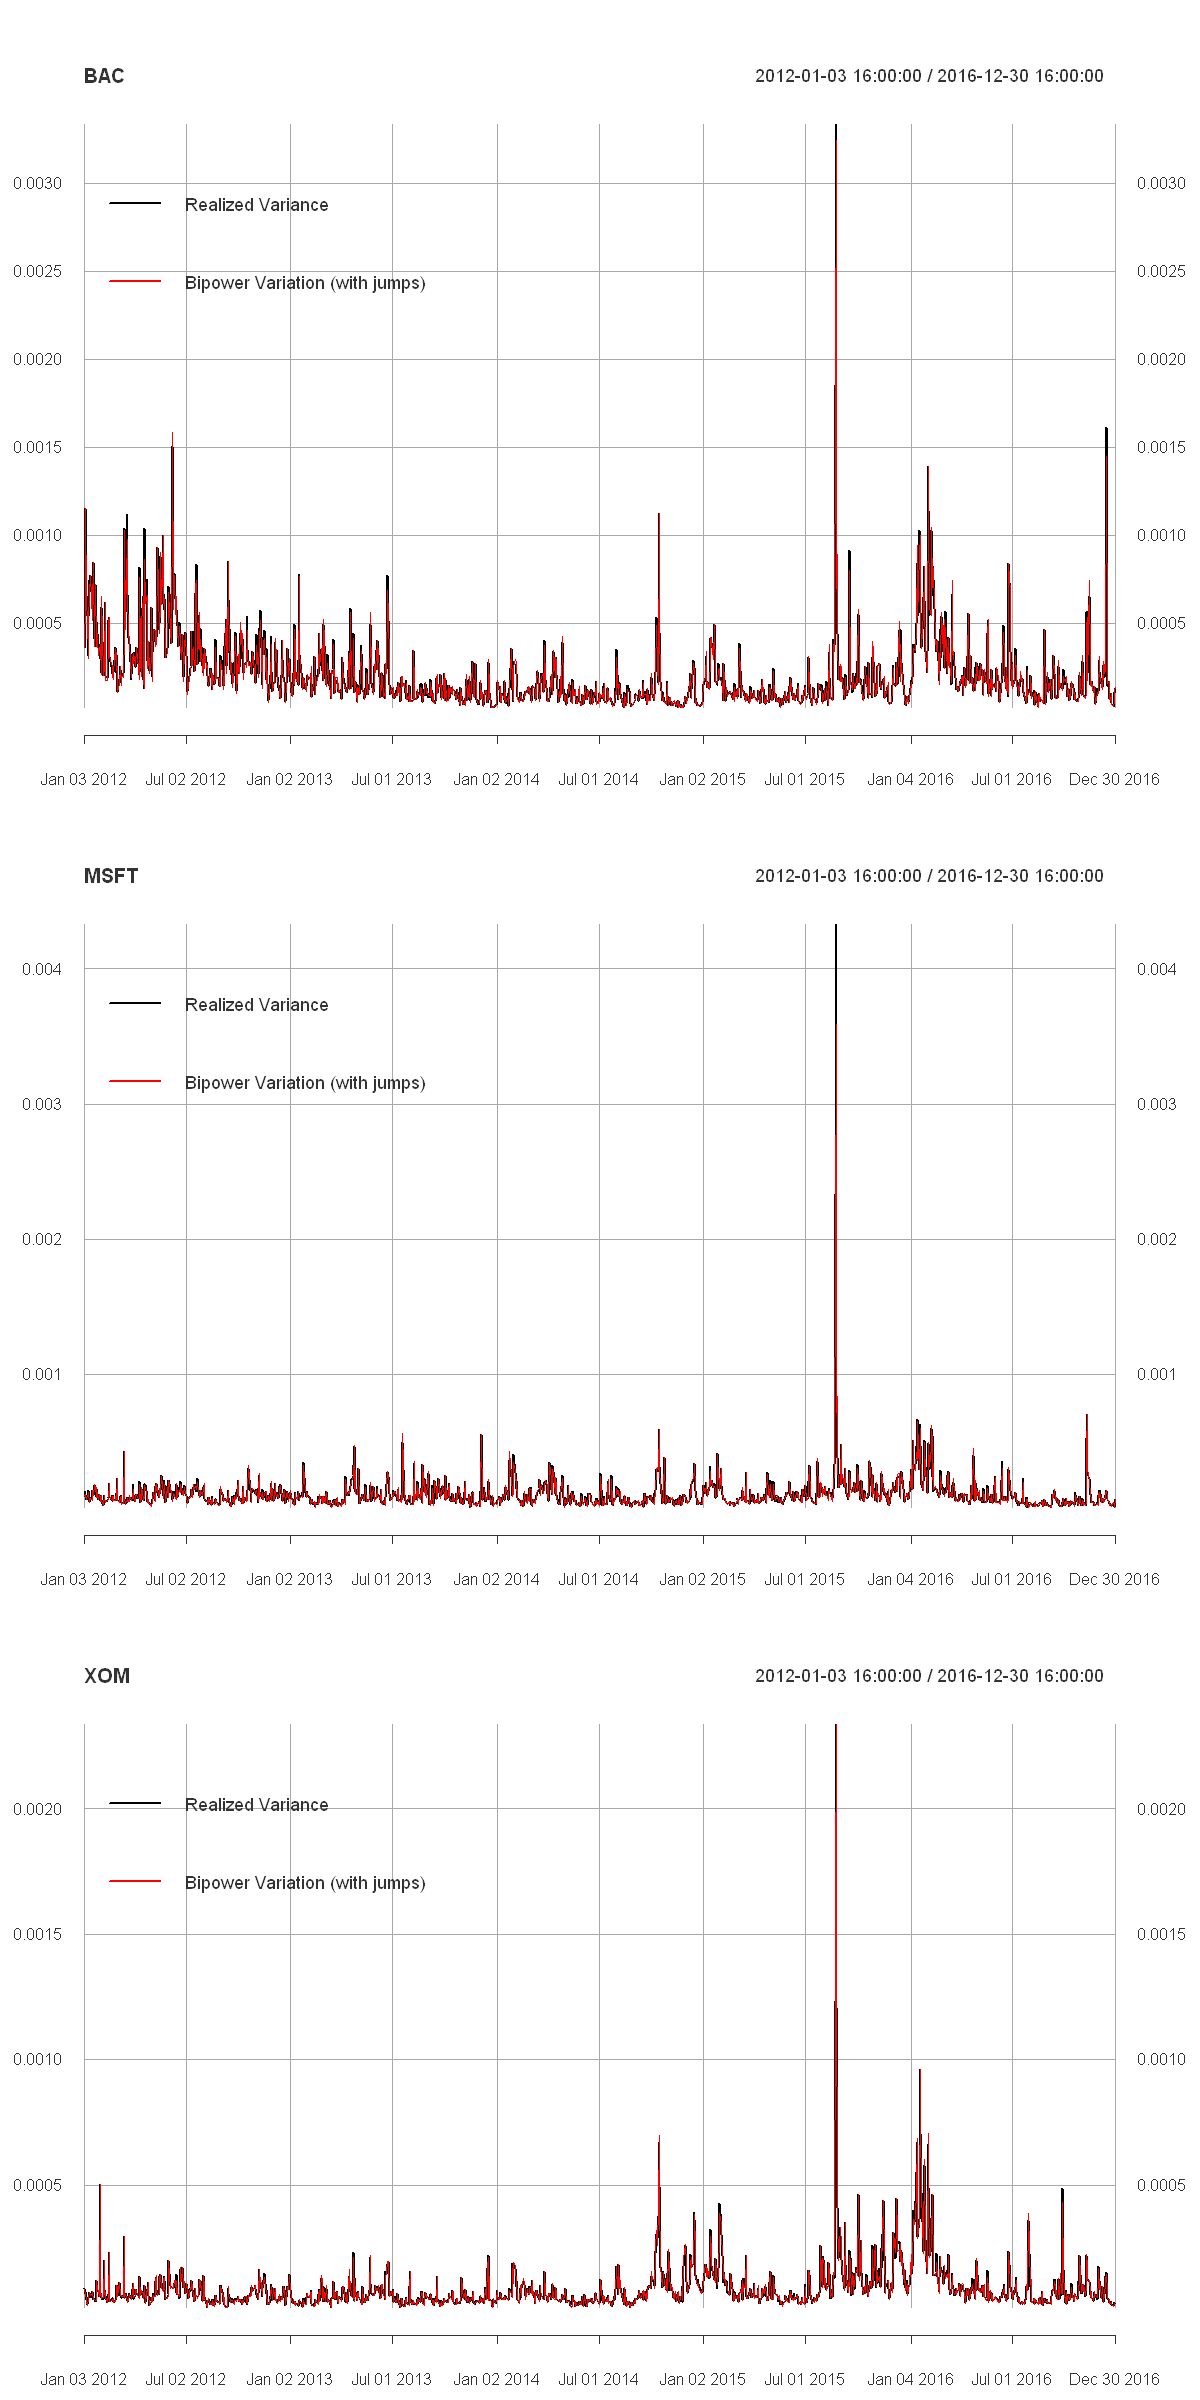

In [78]:
#Plotting RV vs BPV with jumps
options(repr.plot.width = 10, repr.plot.height = 20)
par(mfrow = c(3, 1))
for (i in 1:3) {
    plot_holder <- plot(real_var_from_5min_prices[[i]], main = stock_names[i])
    plot_holder <- lines(bpv_5min[[i]] + jumps_signif_5min[[i]], col = "red")
    plot_holder <- addLegend("topleft", on = 1, legend.names = c("Realized Variance", "Bipower Variation (with jumps)"), col = c("black", "red"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}

As before, the series seem to be even less distinguishable now.

#### 10.

In the last section, we find an appropriate ARMA model for the stocks and then estimate GARCH(1, 1).

In [79]:
#Calculating daily returns
daily_returns_5min <- vector("list", 3) #Empty list for the daily returns
for (i in 1:3) {
    daily_returns_5min[[i]] <- to.daily(apply.daily(na.omit(hw3_data_5min_returns[[i]]), sum), OHLC = F) #to.daily removes the time stamp
}

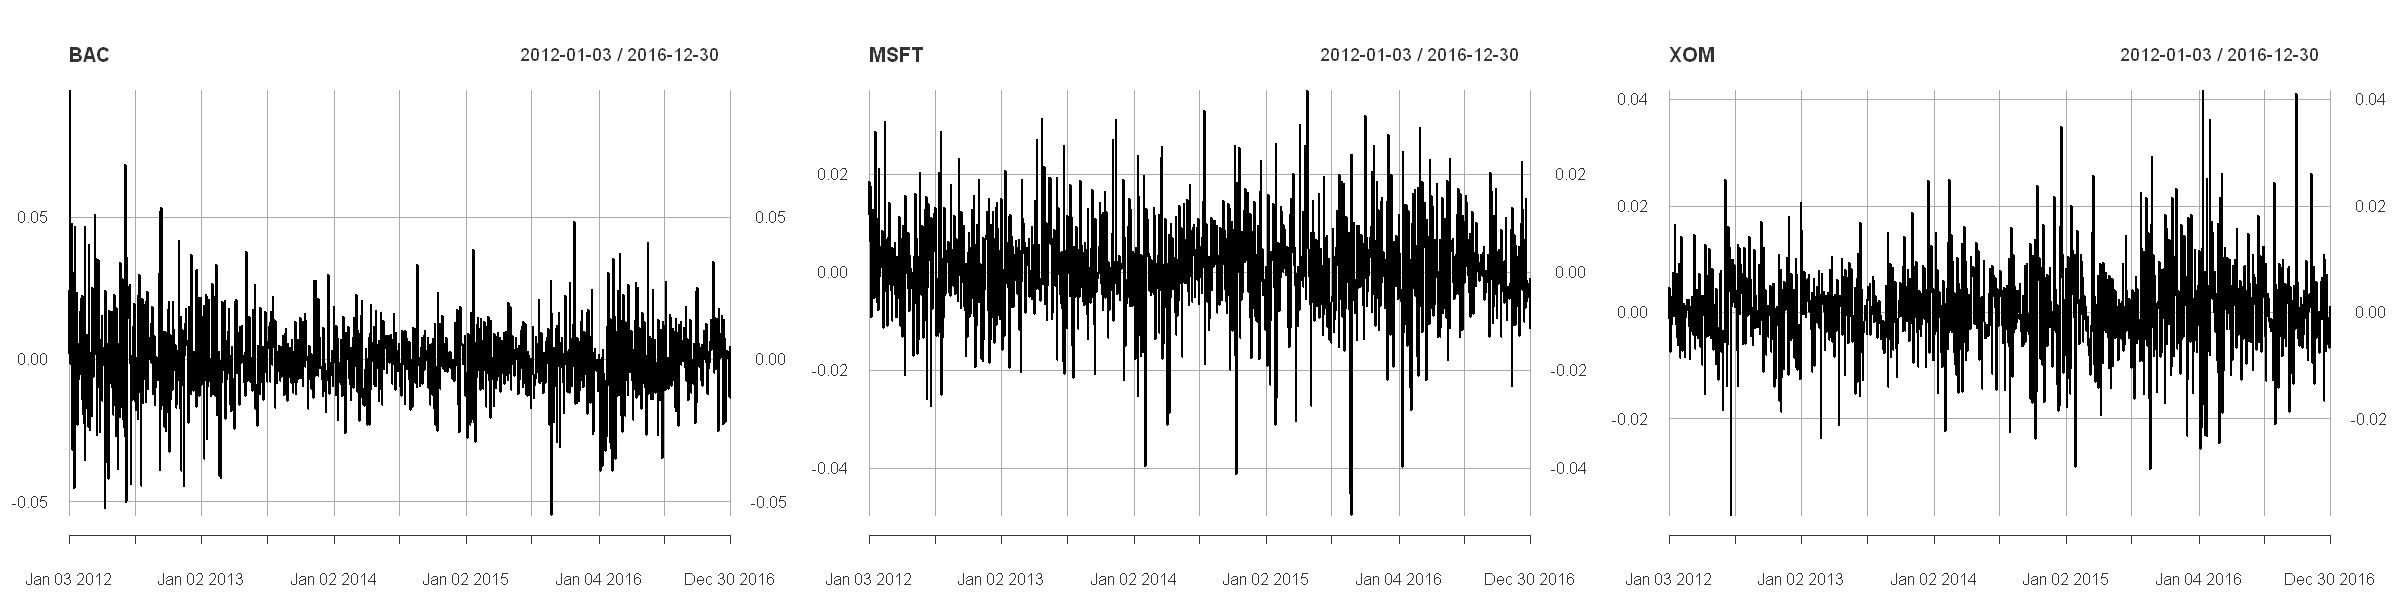

In [80]:
#Plotting the daily returns
options(repr.plot.width = 20, repr.plot.height = 5)
par(mfrow = c(1, 3))
for (i in 1:3) {
    print(plot(daily_returns_5min[[i]], main = stock_names[i]))
}

In [81]:
#Augmented Dickey-Fuller Test
for (i in 1:3) {
    print(stock_names[i])
    print(adf.test(daily_returns_5min[[i]]))
}

[1] "BAC"


Warning message in adf.test(daily_returns_5min[[i]]):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  daily_returns_5min[[i]]
Dickey-Fuller = -10.421, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary

[1] "MSFT"


Warning message in adf.test(daily_returns_5min[[i]]):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  daily_returns_5min[[i]]
Dickey-Fuller = -10.394, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary

[1] "XOM"


Warning message in adf.test(daily_returns_5min[[i]]):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  daily_returns_5min[[i]]
Dickey-Fuller = -12.377, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary



The plots look unrecognizable from their 1 minute counterparts. They also appear to be stationary.

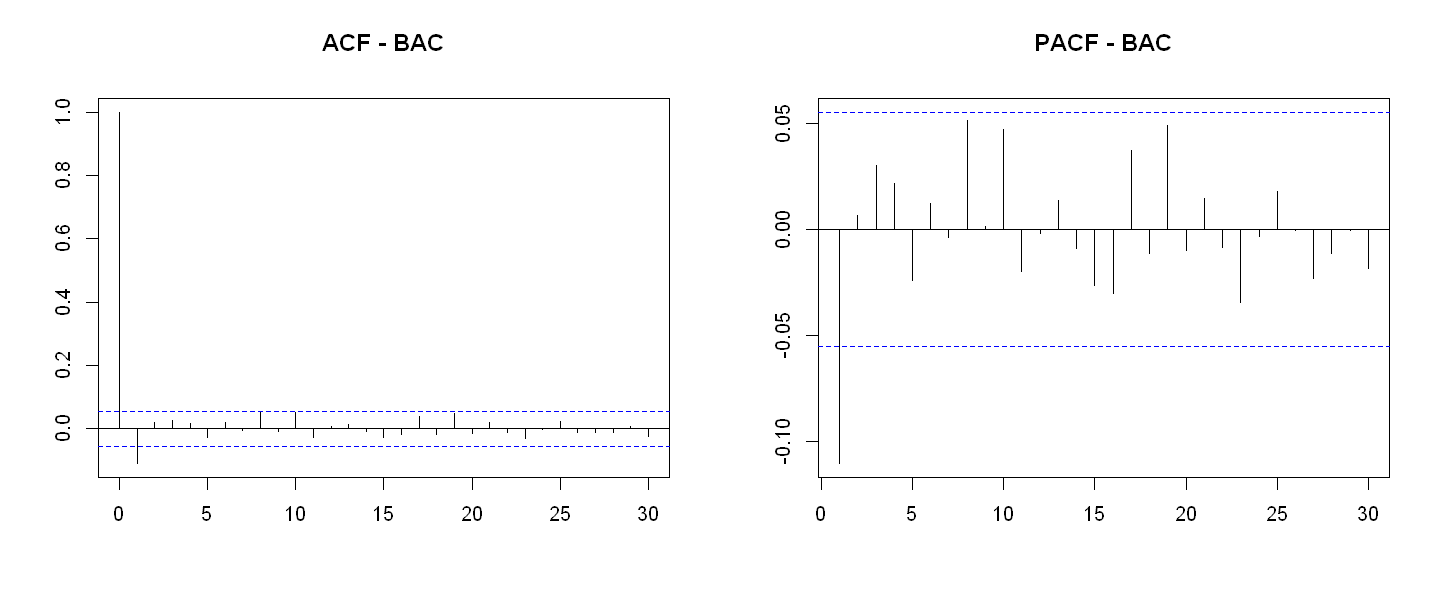

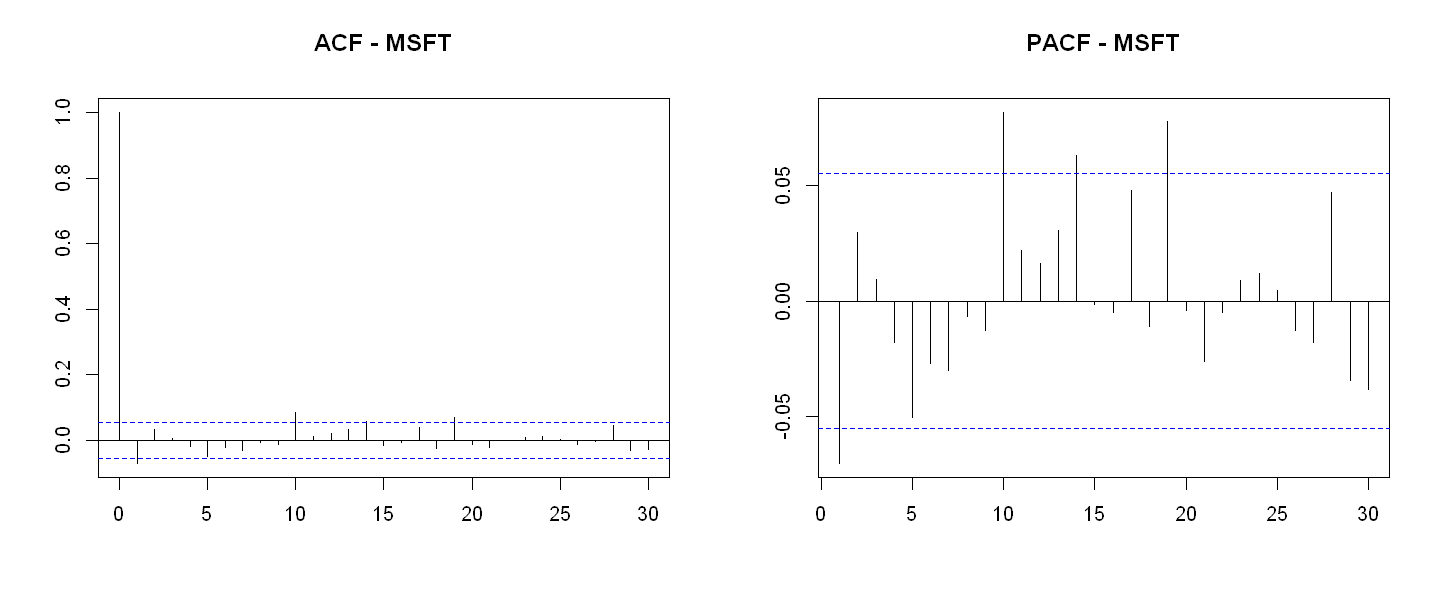

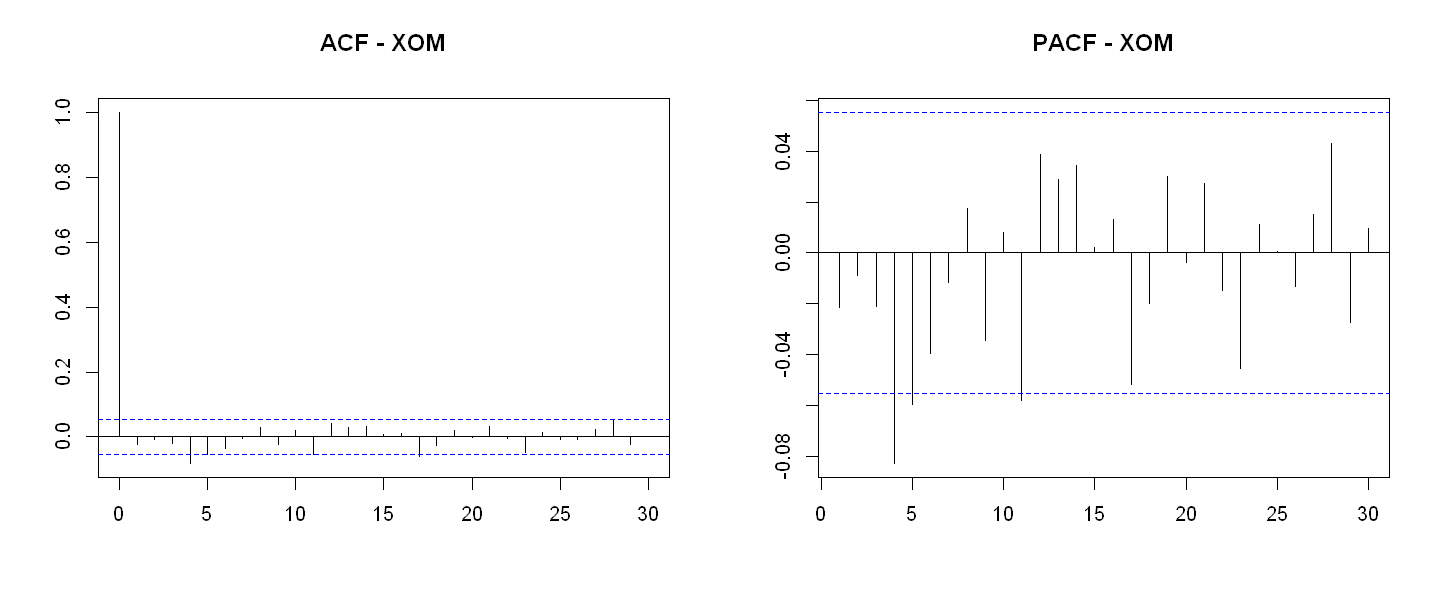

In [82]:
#ACF and PACF
options(repr.plot.width = 12, repr.plot.height = 5)
par(mfrow = c(1, 2))
for (i in 1:3) {
    acf(daily_returns_5min[[i]], xlab = "", ylab = "", main = paste("ACF", "-", stock_names[i]))
    pacf(daily_returns_5min[[i]], xlab = "", ylab = "", main = paste("PACF", "-", stock_names[i]))
}

In [83]:
#Ljung-Box test
for (i in 1:3) {
    print(stock_names[i])
    for (lag_order in c(4, 8, 12)) {
        print(Box.test(daily_returns_5min[[i]], type = "Ljung-Box", lag = lag_order)$p.value)
    }
}

[1] "BAC"
[1] 0.001927349
[1] 0.005340293
[1] 0.01053468
[1] "MSFT"
[1] 0.08667671
[1] 0.1237829
[1] 0.02880805
[1] "XOM"
[1] 0.04569317
[1] 0.04182944
[1] 0.02879336


In [84]:
#Finding the optimal ARMA model
for (i in 1:3) {
    print(stock_names[i])
    for (inf_crit in c("aic","aicc","bic")) {
        auto_model <- auto.arima(daily_returns_5min[[i]], stationary = T, ic = inf_crit) 
        print(paste(inf_crit, ": ", "ARMA(", auto_model$arma[1], ",", auto_model$arma[2], ")", sep = ""), quote = F)
    }
}

[1] "BAC"
[1] aic: ARMA(4,2)
[1] aicc: ARMA(4,2)
[1] bic: ARMA(3,0)
[1] "MSFT"
[1] aic: ARMA(2,0)
[1] aicc: ARMA(2,0)
[1] bic: ARMA(0,0)
[1] "XOM"
[1] aic: ARMA(0,0)
[1] aicc: ARMA(0,0)
[1] bic: ARMA(0,0)


As can be seen, the results are very similar to those obtained with 1 minute prices. The ACFs and PACFs look almost identical and we have some significant dependecies for all stocks. However, the output of the ``auto.arima`` function is quite different. Nevertheless, we will try to use the same models as in the previous problem and assess their adequacy.

In [85]:
#Estimating ARMA
orders <- matrix(c(1, 0, 0, 1, 0, 0), ncol = 2) #Specifing the order for both stocks
for (i in 1:2) {
    print(stock_names[i])
    arma_model <- Arima(daily_returns_5min[[i]], order = orders[, i])
    for (lag_order in c(4, 8, 12)) {
        print(Box.test(arma_model$residuals, type = "Ljung-Box", lag = lag_order)$p.value)
    }
}

[1] "BAC"
[1] 0.7893541
[1] 0.6476389
[1] 0.6655176
[1] "MSFT"
[1] 0.7823502
[1] 0.5118291
[1] 0.1158099


The results suggest that the models should be sufficient to remove the dependencies. The GARCH estimation follows.

In [86]:
#Estimating GARCH(1, 1)
garch_models_5min <- vector("list", 3) #Empty vector for the models' outputs
garchspecBACandMSFT <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)), #Saving the specifications since they are shared among the two stocks
                        mean.model = list(armaOrder = c(1, 0), include.mean = TRUE, archm = TRUE, archpow = 1))
garchspecXOM <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)), #Saving the specifications for XOM
                        mean.model = list(armaOrder = c(0, 0), include.mean = TRUE, archm = TRUE, archpow = 1))

for (i in 1:3) {
    if (i == 3) {
        garchspec <- garchspecXOM
    } else {
        garchspec <- garchspecBACandMSFT
    }
    garch_models_5min[[i]] <- ugarchfit(garchspec, daily_returns_5min[[i]]) #Estimating and storing the results
}

Now we will inspect how well the models fit the data and whether we need to make any adjustments.

In [87]:
#Inspecting the results (BAC)
garch_models_5min[[1]]


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000036    0.001541  0.023042 0.981617
ar1    -0.068252    0.029312 -2.328418 0.019890
archm  -0.011090    0.127649 -0.086877 0.930769
omega   0.000002    0.000002  1.142909 0.253077
alpha1  0.047356    0.014769  3.206478 0.001344
beta1   0.942135    0.016917 55.690186 0.000000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000036    0.002029  0.017495 0.986042
ar1    -0.068252    0.039593 -1.723848 0.084735
archm  -0.011090    0.160440 -0.069121 0.944893
omega   0.000002    0.000009  0.204501 0.837962
alpha1  0.047356    0.097698  0.484721 0.627874
beta1   0.942135    0.107165  8.791468 0.0

For the BAC stock it seems that there are still some significant ARCH effects in the residuals. Therefore, we may need to try a different specification.

In [88]:
#Inspecting the results (MSFT)
garch_models_5min[[2]]


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.002319    0.003276  0.70792 0.478995
ar1    -0.056438    0.031100 -1.81472 0.069566
archm  -0.146197    0.330723 -0.44205 0.658451
omega   0.000038    0.000014  2.65724 0.007878
alpha1  0.094110    0.029347  3.20678 0.001342
beta1   0.531882    0.154255  3.44807 0.000565

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.002319    0.003014  0.76949 0.441600
ar1    -0.056438    0.029118 -1.93825 0.052593
archm  -0.146197    0.302245 -0.48370 0.628596
omega   0.000038    0.000016  2.35049 0.018749
alpha1  0.094110    0.034287  2.74478 0.006055
beta1   0.531882    0.168335  3.15965 0.001580

LogLike

The results for MSFT are satisfactory.

In [89]:
#Inspecting the results (XOM)
garch_models_5min[[3]]


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.002542    0.001331  -1.9106 0.056055
archm   0.394623    0.174226   2.2650 0.023512
omega   0.000004    0.000000  10.5087 0.000000
alpha1  0.076156    0.007933   9.5996 0.000000
beta1   0.863786    0.012375  69.8012 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.002542    0.001302  -1.9532 0.050802
archm   0.394623    0.167966   2.3494 0.018802
omega   0.000004    0.000001   6.6740 0.000000
alpha1  0.076156    0.006846  11.1249 0.000000
beta1   0.863786    0.010697  80.7507 0.000000

LogLikelihood : 4309.694 

Information Criteria
------------------------------------
                

Similarly, we do not need to make any adjustments in case of XOM. Therefore, we will now try a different specification for the BAC stock.

In [90]:
#Estimating GARCH(2, 1) for BAC
garchspecBAC_new <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(2, 1)), #Saving the new specifications 
                        mean.model = list(armaOrder = c(1, 0), include.mean = TRUE, archm = TRUE, archpow = 1))

garch_models_5min[[1]] <- ugarchfit(garchspecBAC_new, daily_returns_5min[[1]]) #Estimating and storing the results

In [91]:
#Inspecting the results
garch_models_5min[[1]]


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(2,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000028    0.001508  0.018502 0.985238
ar1    -0.068186    0.029589 -2.304461 0.021197
archm  -0.009942    0.125112 -0.079465 0.936663
omega   0.000002    0.000001  1.542701 0.122903
alpha1  0.049782    0.024285  2.049939 0.040370
alpha2  0.000000    0.019806  0.000004 0.999997
beta1   0.939210    0.014694 63.919978 0.000000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000028    0.001911  0.014600 0.988351
ar1    -0.068186    0.034218 -1.992723 0.046292
archm  -0.009942    0.153129 -0.064925 0.948233
omega   0.000002    0.000005  0.412193 0.680198
alpha1  0.049782    0.044201  1.126277 0.2

Finally, there do not seem to be any significant dependecies left. Therefore, we can proceed with estimating the volatility for all three models and compare it to Realized Volatility.

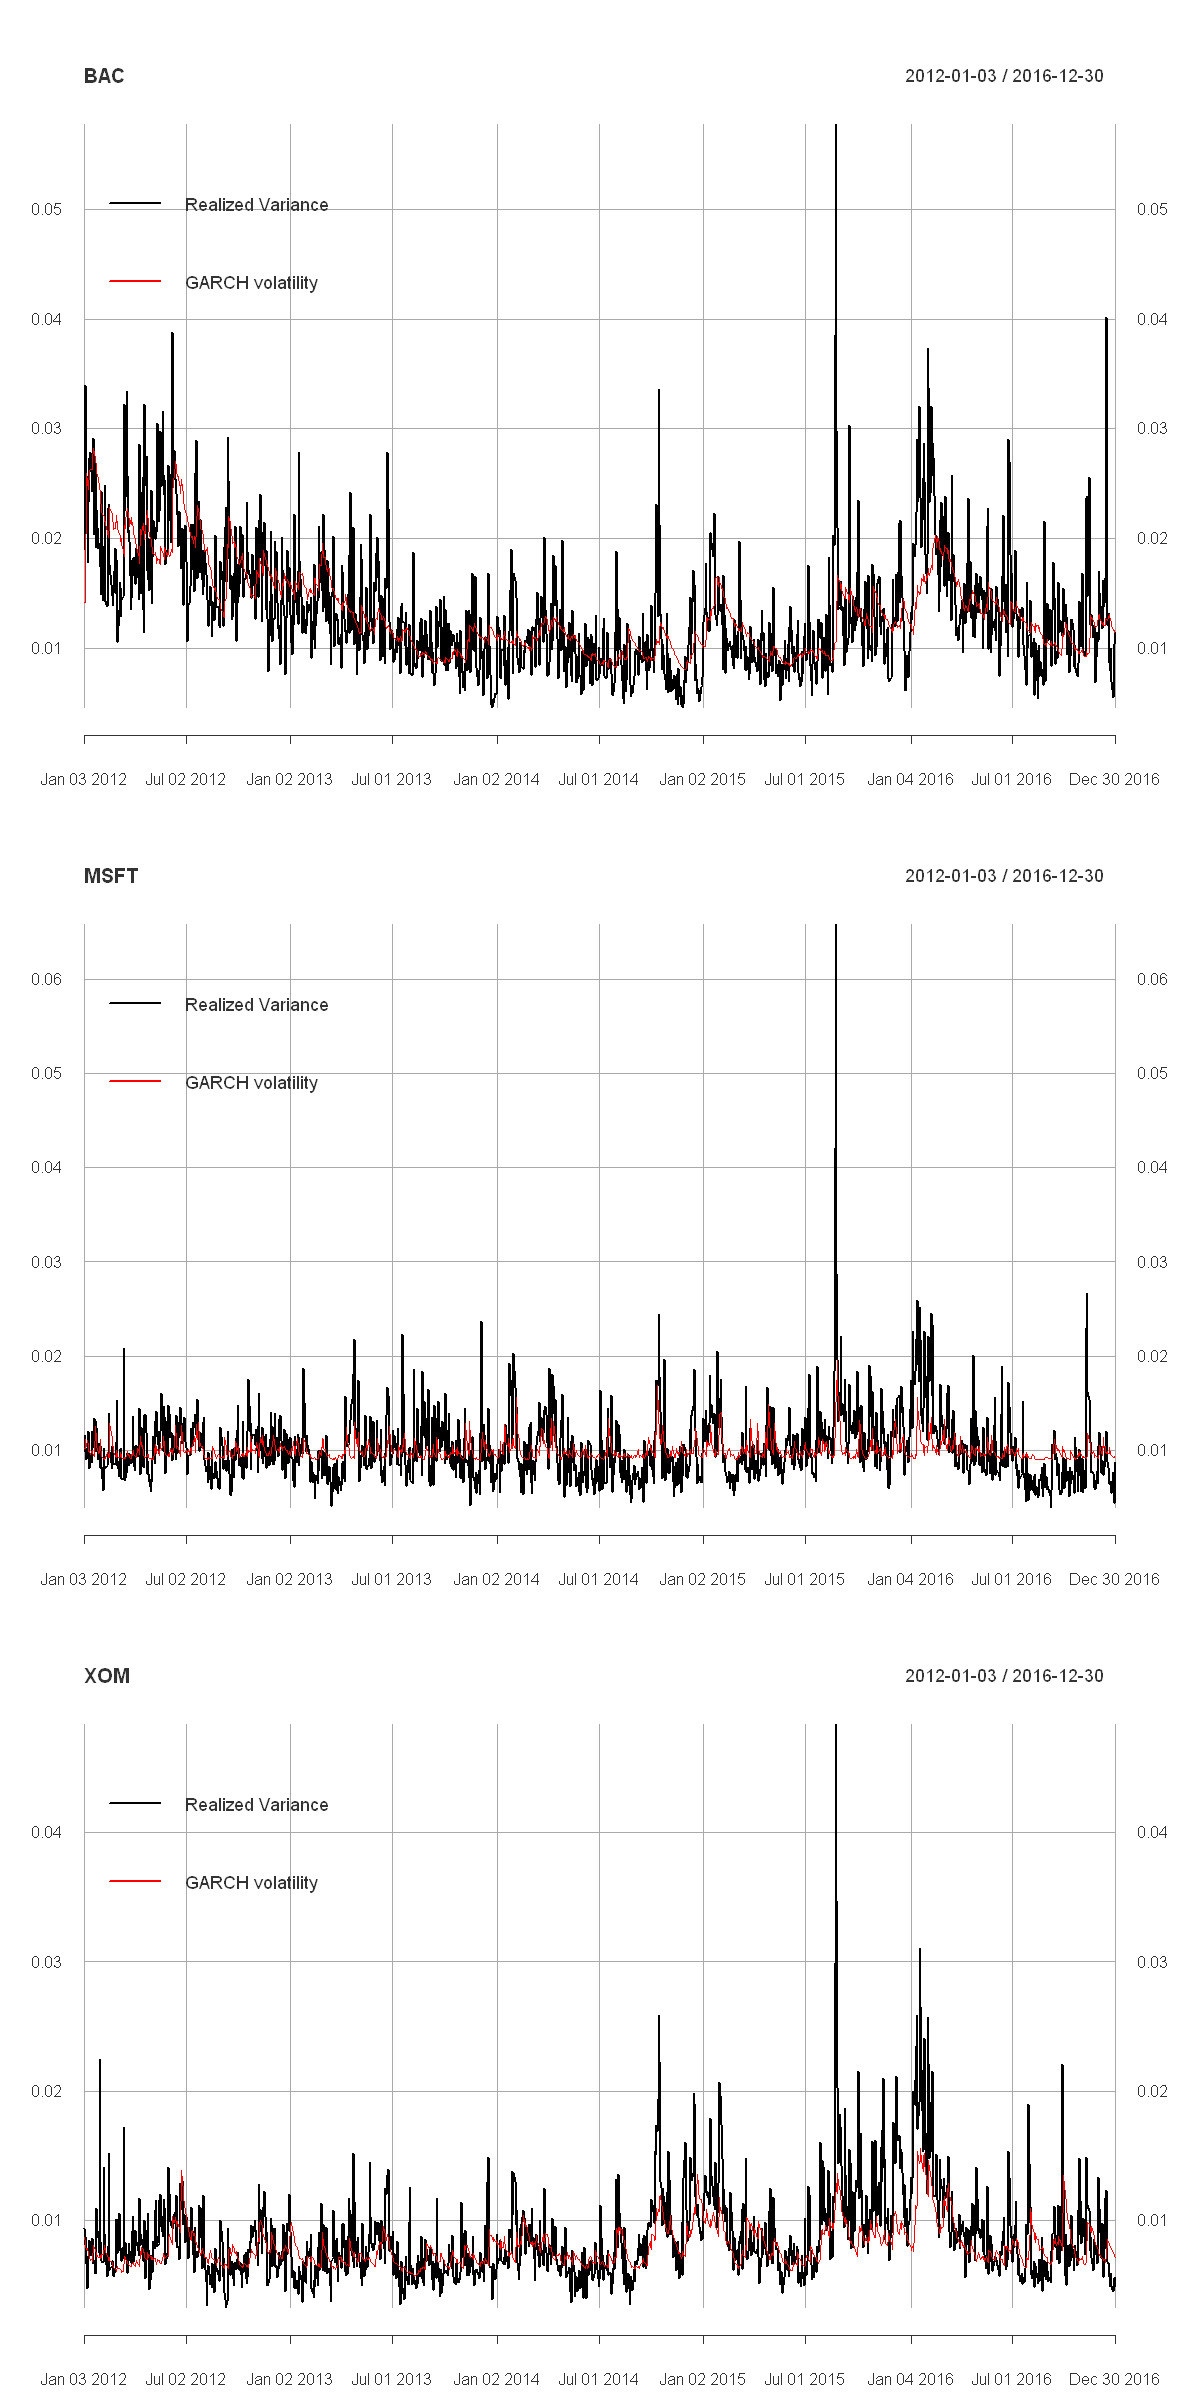

In [92]:
#Plotting estimated GARCH volatility vs Realized Volatility
options(repr.plot.width = 10, repr.plot.height = 20)
par(mfrow = c(3, 1))
for (i in 1:3) {
    plot_holder <- plot(sqrt(to.daily(real_var_from_5min_returns[[i]], OHLC = F)), main = stock_names[i])
    plot_holder <- lines(sigma(garch_models_5min[[i]]), col = "red")
    plot_holder <- addLegend("topleft", on = 1, legend.names = c("Realized Variance", "GARCH volatility"), col = c("black", "red"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}

As can be seen, the estimated GARCH volatility fits the Realized Volatility better when calculated from 5 minute prices. This can be seen especially for the beggining of the series of the BAC stock. As previously mentioned, 5 minutes data should contain less noise and thus the results are expected to be less distorted.

#### B)

In the previous section, we have already discussed the observed differences between 1 minute and 5 minute data so let us summarize our findings:
- As expected, the behavior of the ``rCov()`` function is the same for both data frequencies.
- We have not observed any substantial differences regarding the plots of the Realized Variance for intraday sub-periods. In both cases, the Realized Variance appeared to be systematically lower in the morning for the BAC stock.
- As for the calculated differences between daily RV and sum of intraday RV, they appear to be larger for 5 minute prices. This is likely due to the fact that the disregarded between-subperiod returns account for a large share of the daily RV.

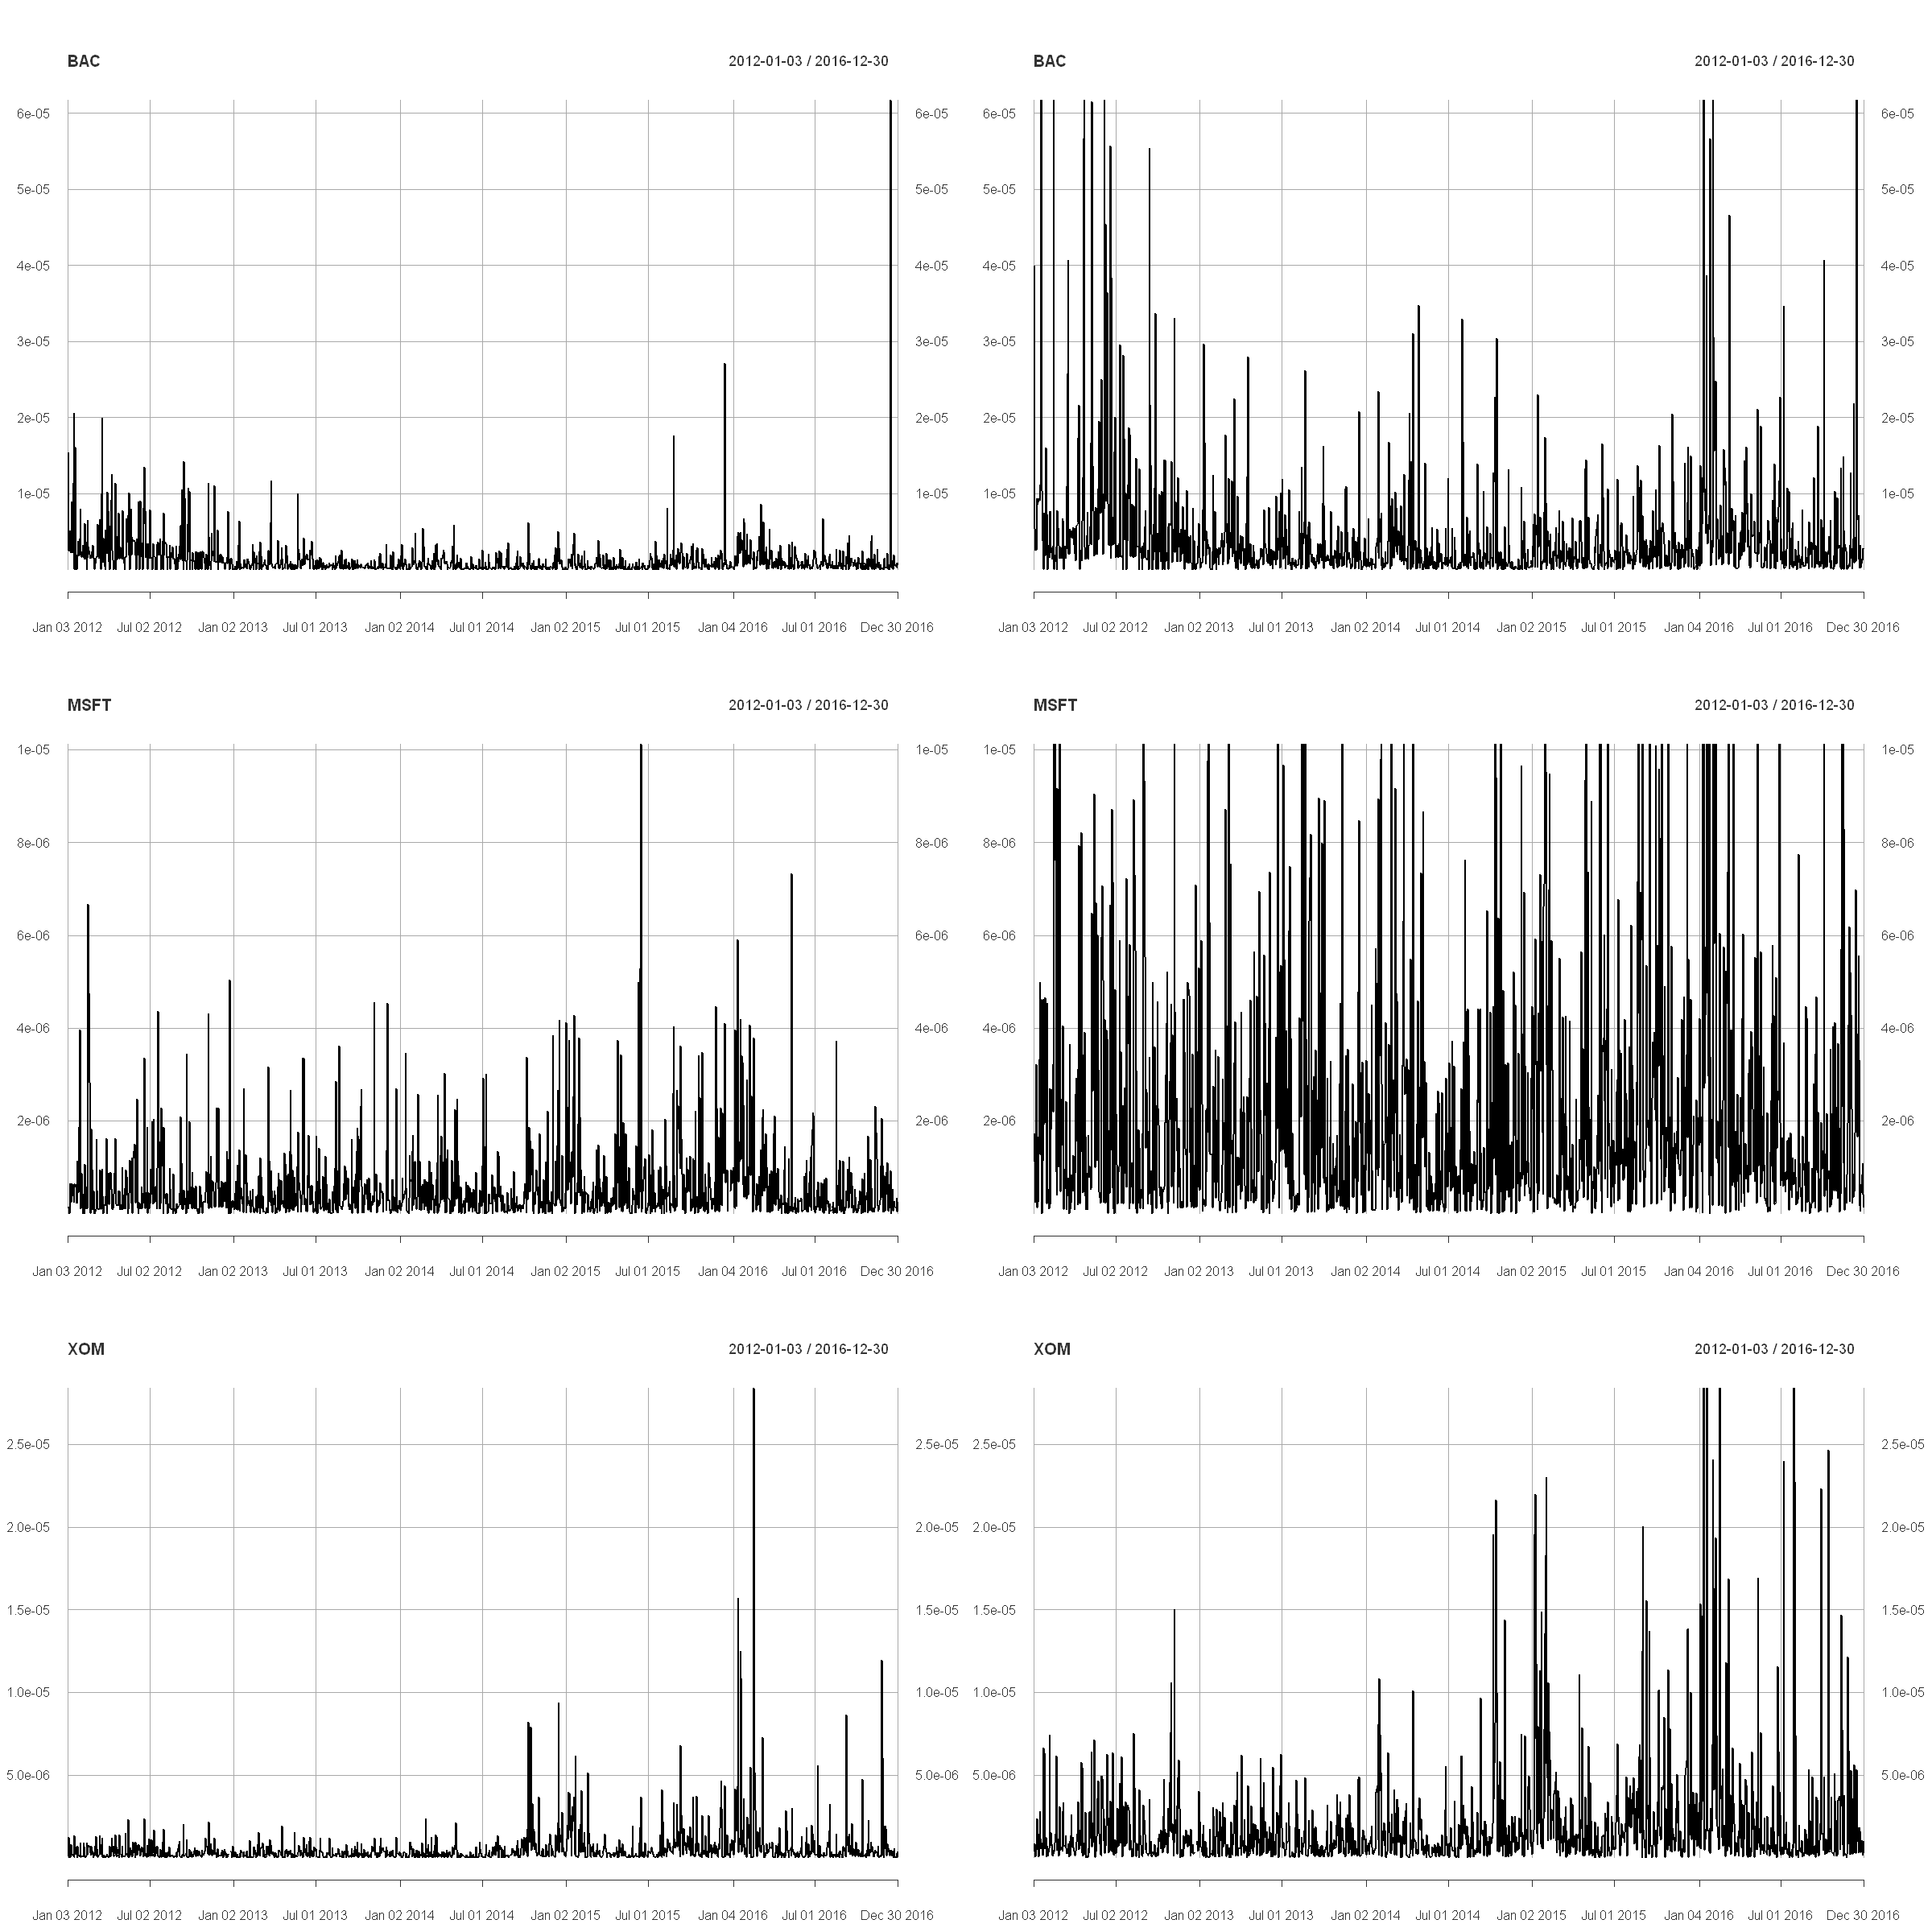

In [99]:
#Difference between Daily RV and sum of intraday RV
options(repr.plot.width = 20, repr.plot.height = 20)
par(mfcol = c(3, 2))
#1 minute data
for (i in 1:3) { #Looping through the tickers
    print(plot(daily_RV_from_prices[[i]] - sum_intraday_RV_from_prices[[i]], main = stock_names[i]))
}
#5 minute data
for (i in 1:3) { #Looping through the tickers
    print(plot(daily_RV_from_prices_5min[[i]] - sum_intraday_RV_from_prices_5min[[i]], main = stock_names[i], ylim = c(min(daily_RV_from_prices[[i]] - sum_intraday_RV_from_prices[[i]], na.rm = T), max(daily_RV_from_prices[[i]] - sum_intraday_RV_from_prices[[i]], na.rm = T))))
}

- For 5 minute prices, the Bipower Variation estimates the Realized Variance more precisely. This is especially visible for the BAC stock.

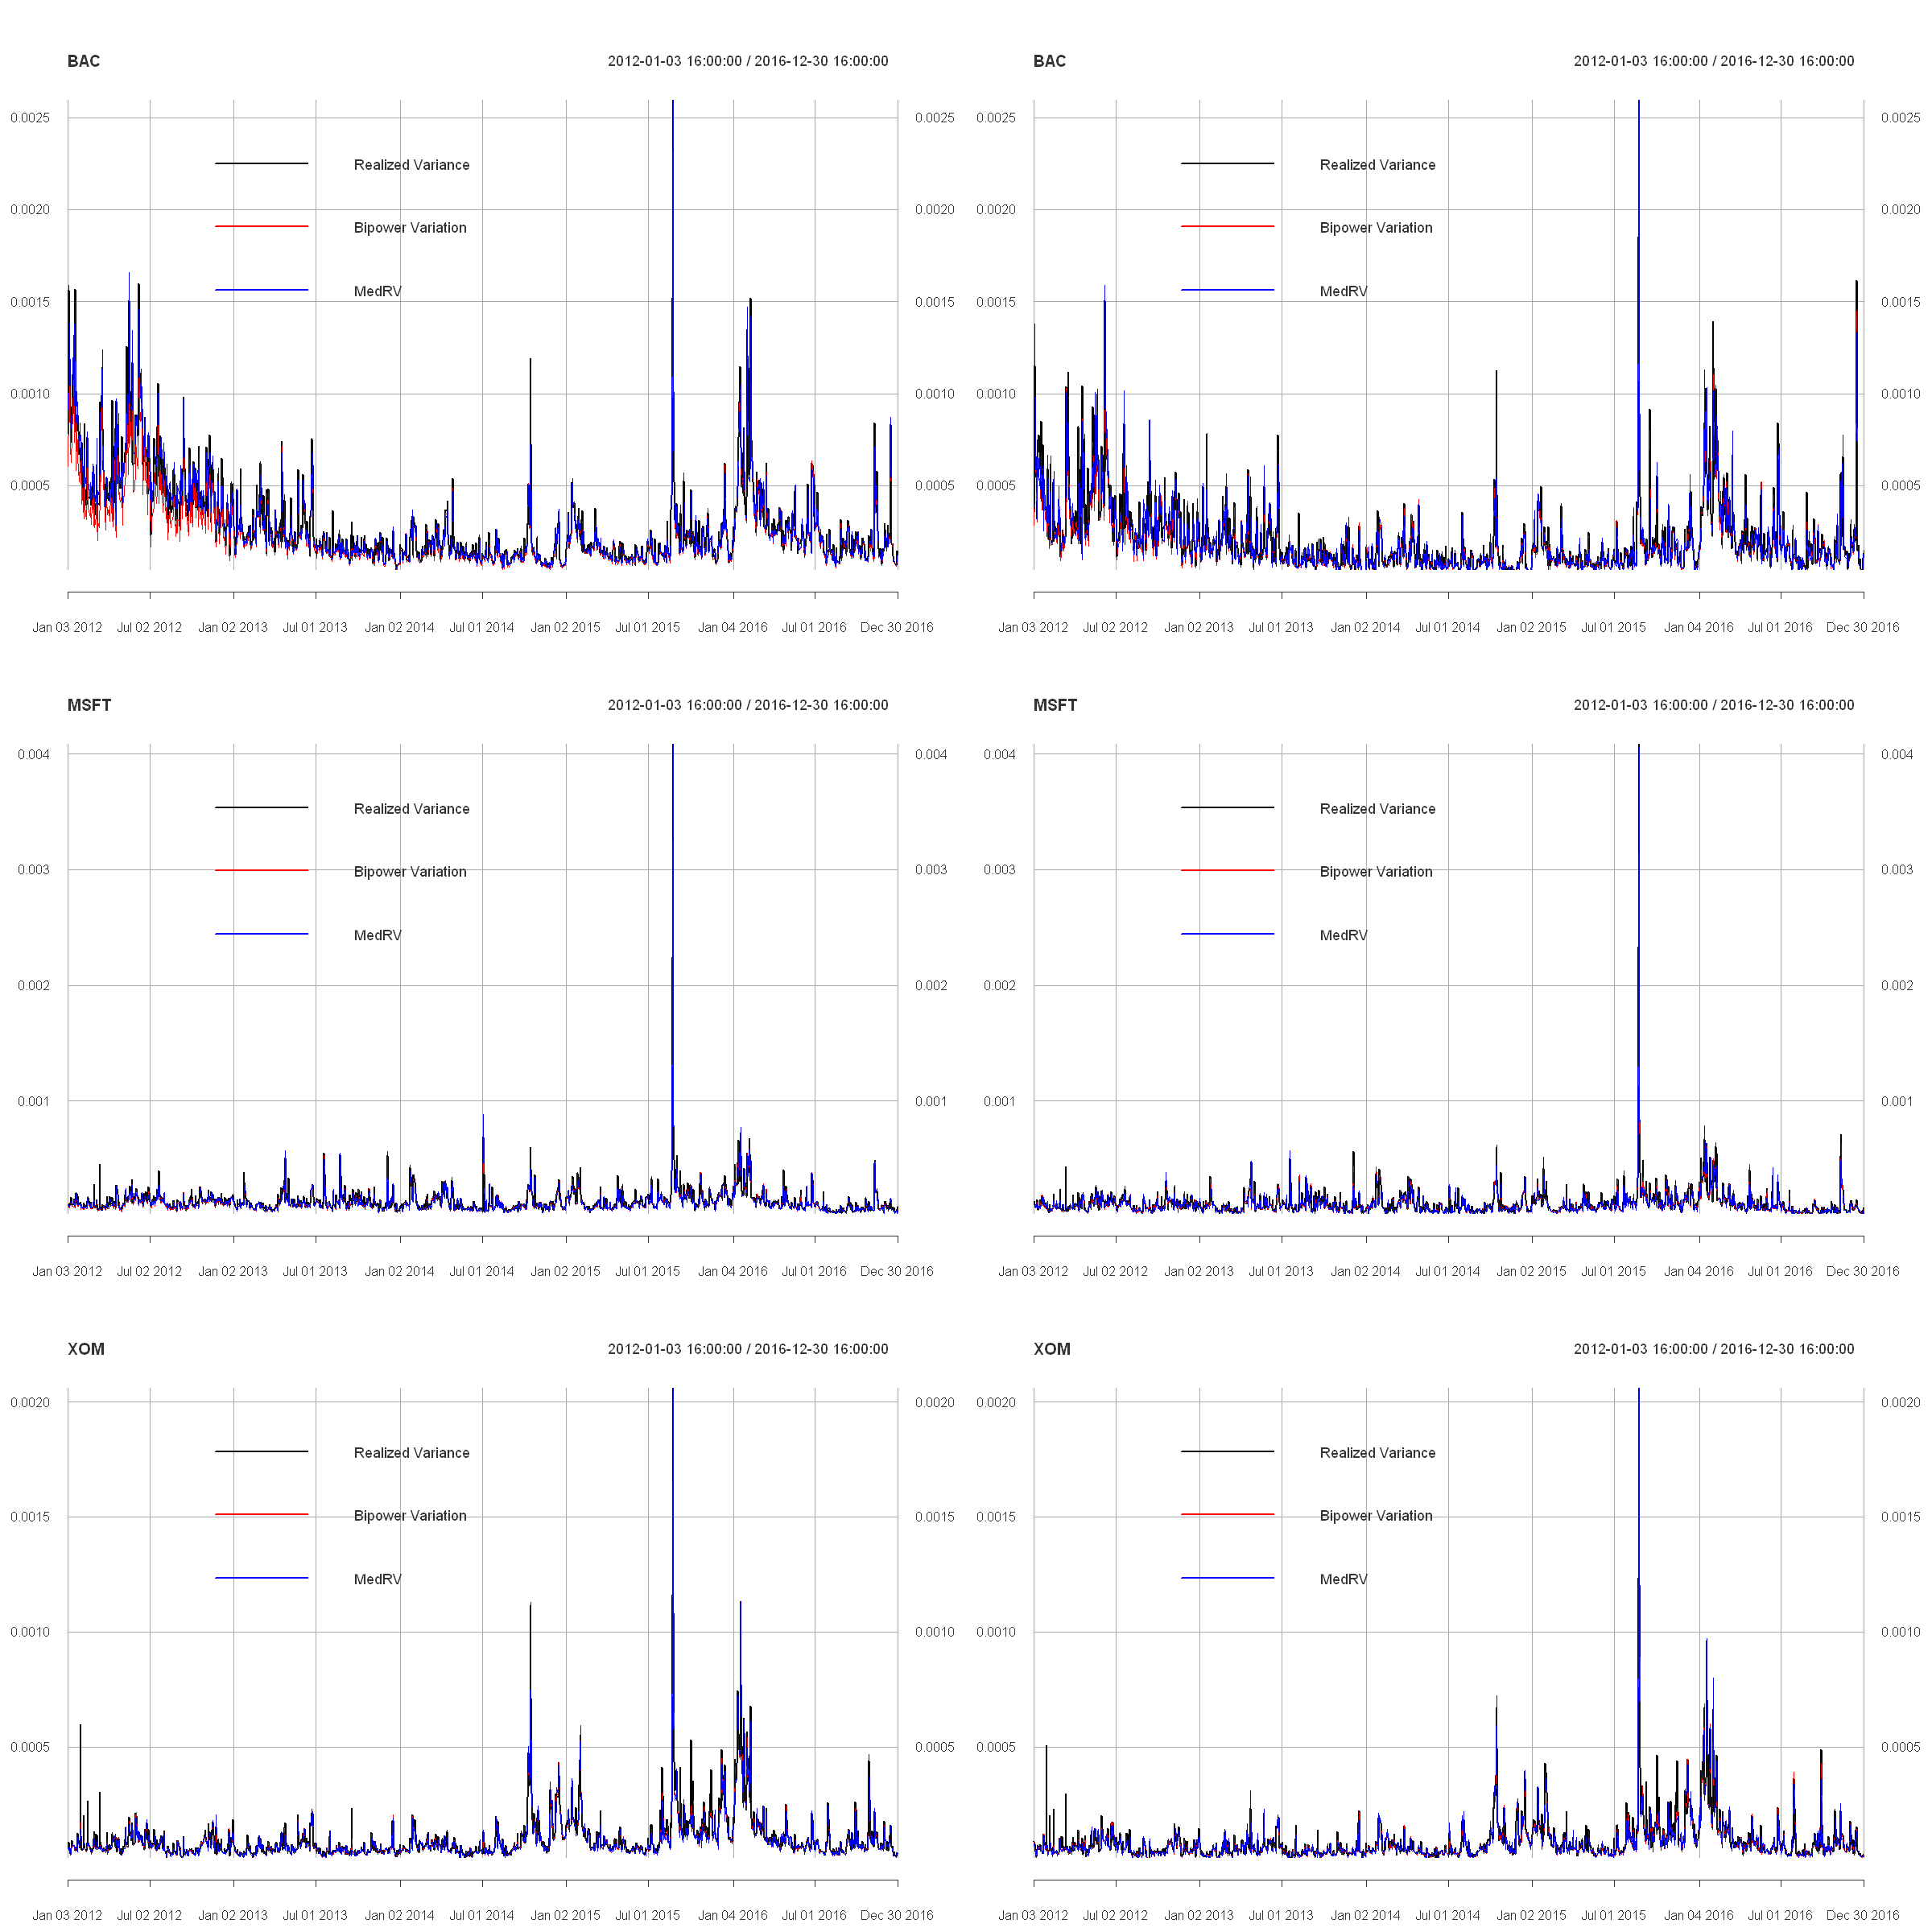

In [103]:
#Plotting Realized Variance, Bipower Variation, and MedRV estimator
options(repr.plot.width = 20, repr.plot.height = 20)
par(mfcol = c(3, 2))
for (i in 1:3) { #Looping through the tickers
    plot_holder <- plot(real_var_from_prices[[i]], main = stock_names[i])
    plot_holder <- lines(bpv[[i]], col = "red")
    plot_holder <- lines(medrv[[i]], col = "blue")
    plot_holder <- addLegend("top", on = 1, legend.names = c("Realized Variance", "Bipower Variation", "MedRV"), col = c("black", "red", "blue"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}
for (i in 1:3) { #Looping through the tickers
    plot_holder <- plot(real_var_from_5min_prices[[i]], main = stock_names[i], ylim = c(min(real_var_from_prices[[i]], na.rm = T), max(real_var_from_prices[[i]], na.rm = T)))
    plot_holder <- lines(bpv_5min[[i]], col = "red")
    plot_holder <- lines(medrv_5min[[i]], col = "blue")
    plot_holder <- addLegend("top", on = 1, legend.names = c("Realized Variance", "Bipower Variation", "MedRV"), col = c("black", "red", "blue"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}

- For 5 minutes prices, the jumps appear to be larger in magnitude and there appear to be more of them. However, the magnitude is intuitive, since 5 minute returns are likely to be larger in absolute values than 1 minute returns.

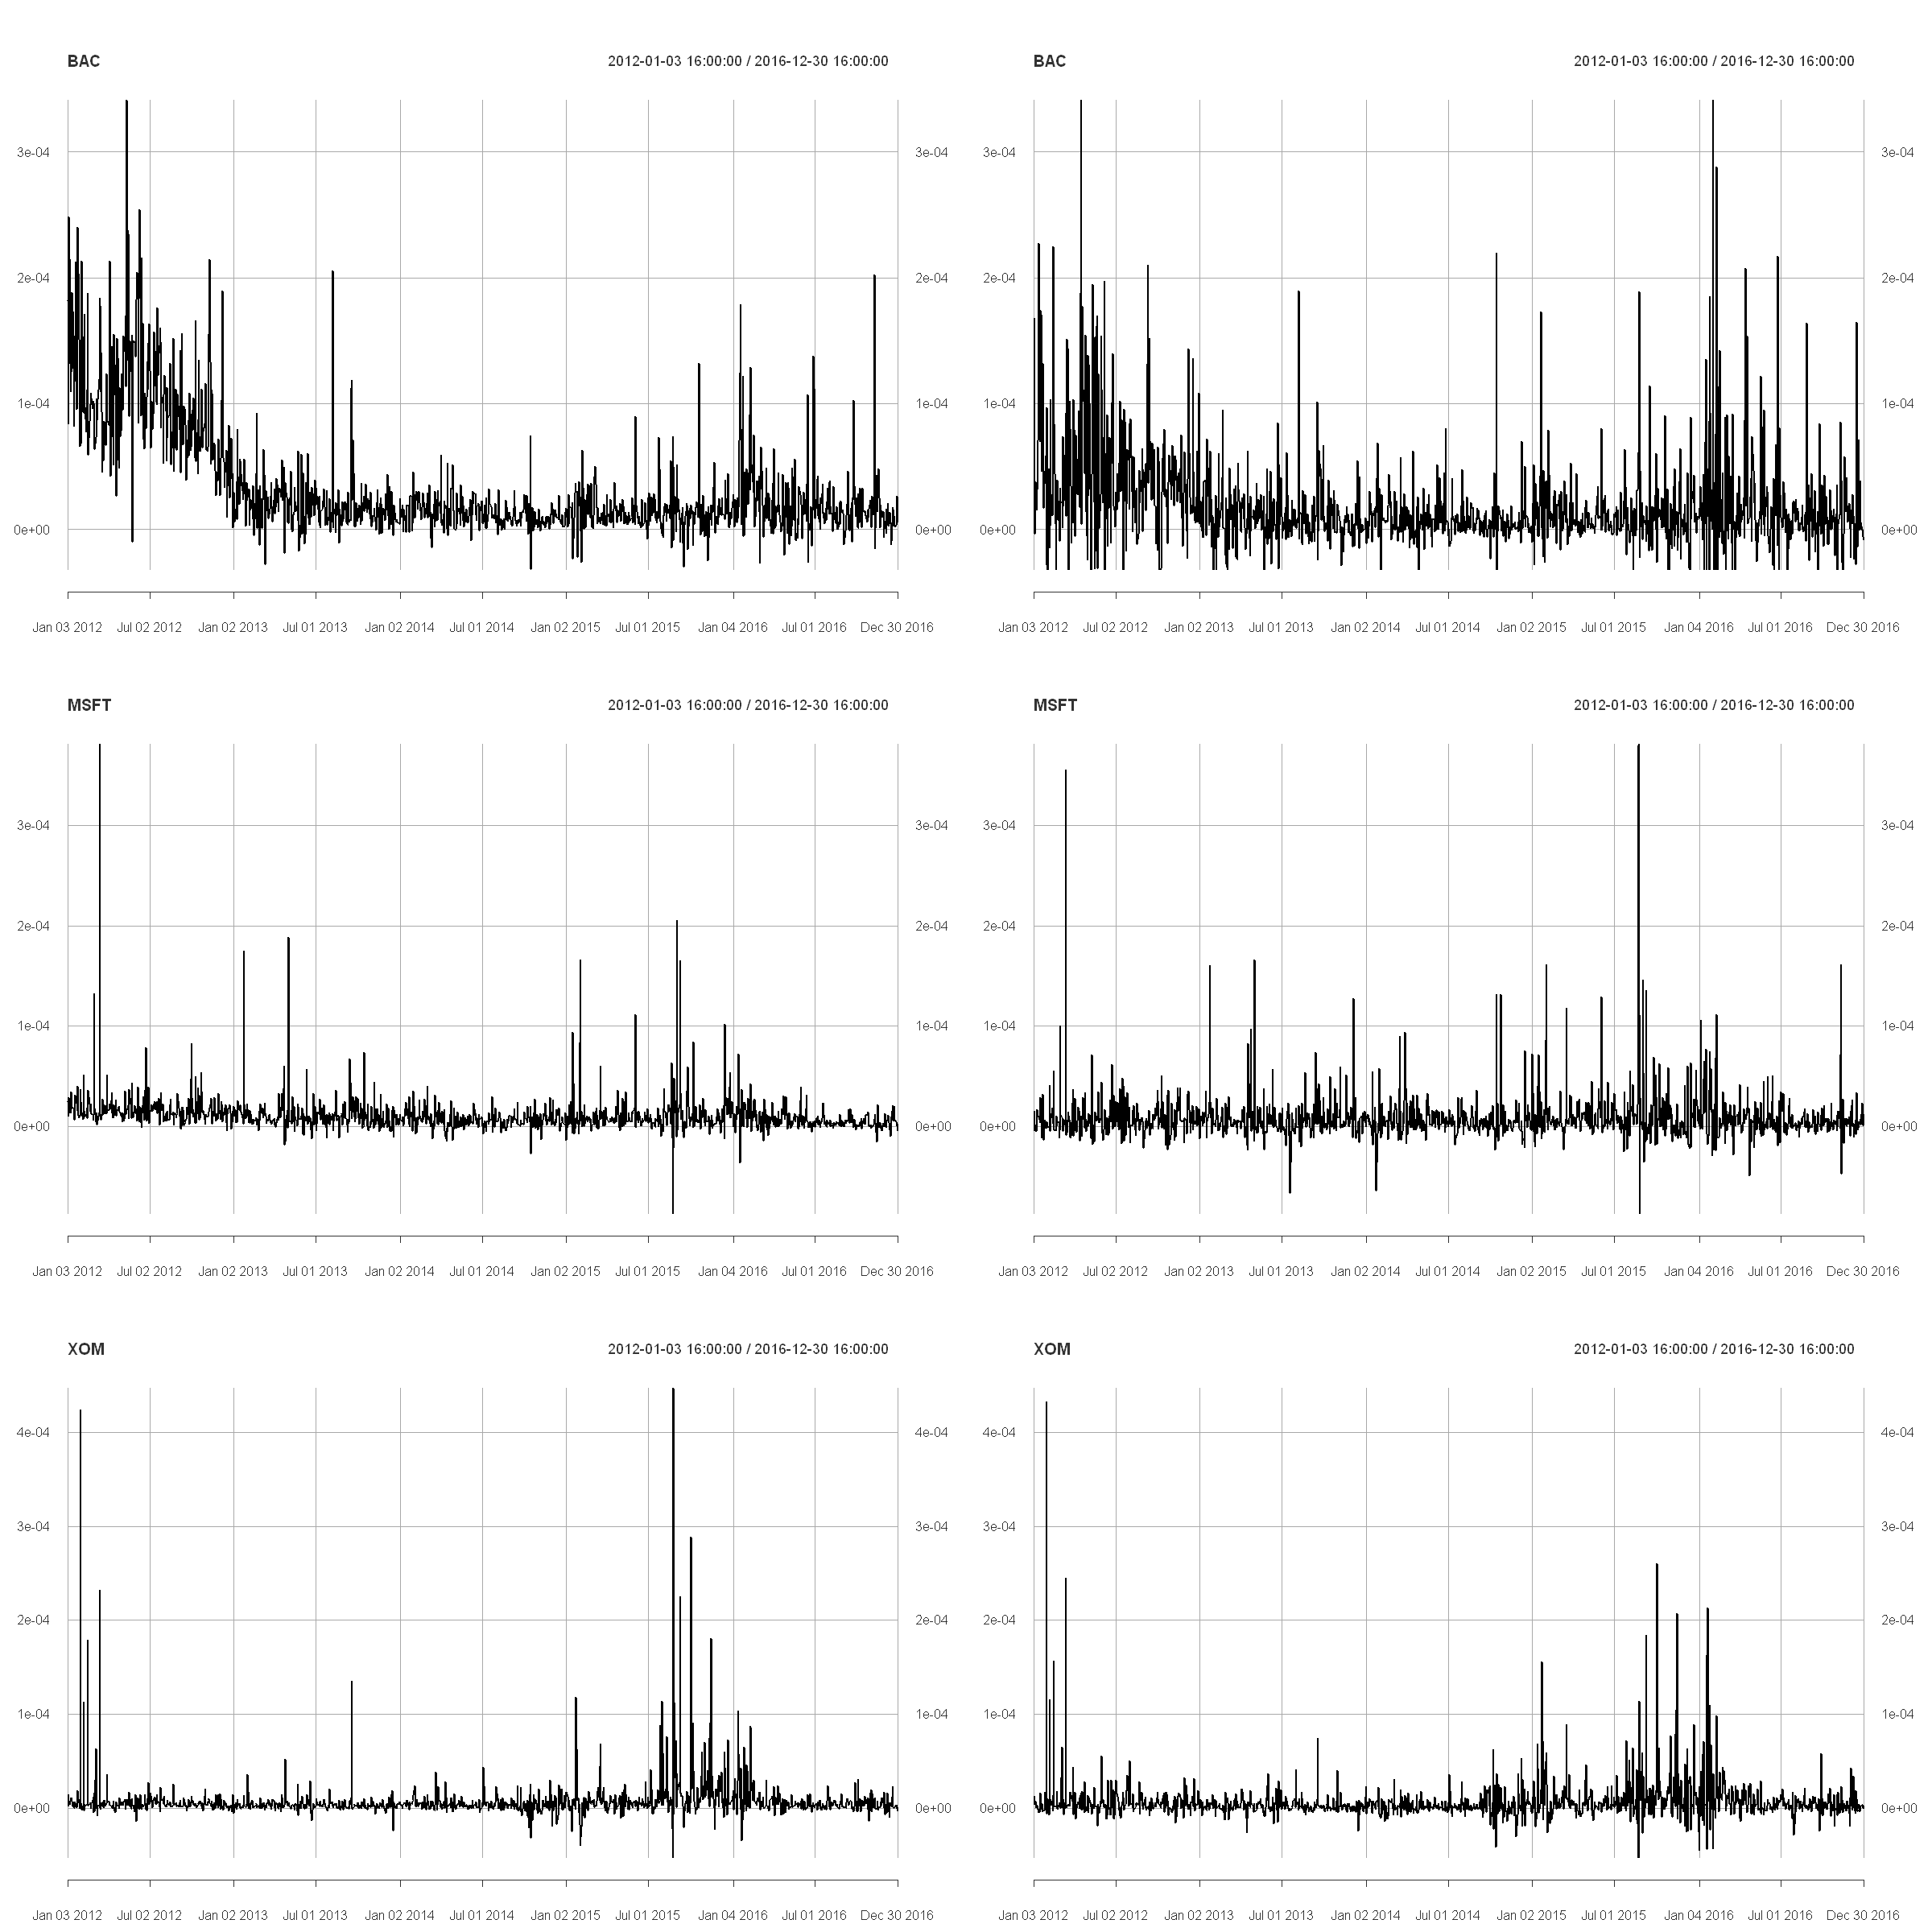

In [106]:
#Plotting the jumps
options(repr.plot.width = 20, repr.plot.height = 20)
par(mfcol = c(3, 2))
#1 minute data
for (i in 1:3) {
    print(plot(jumps[[i]], main = stock_names[i]))
}
#5 minute data
for (i in 1:3) {
    print(plot(jumps_5min[[i]], main = stock_names[i], ylim = c(min(jumps[[i]], na.rm = T), max(jumps[[i]], na.rm = T))))
}

- With regards to GARCH estimation, the estimated volatility seems to be more precise when using 5 minute prices.

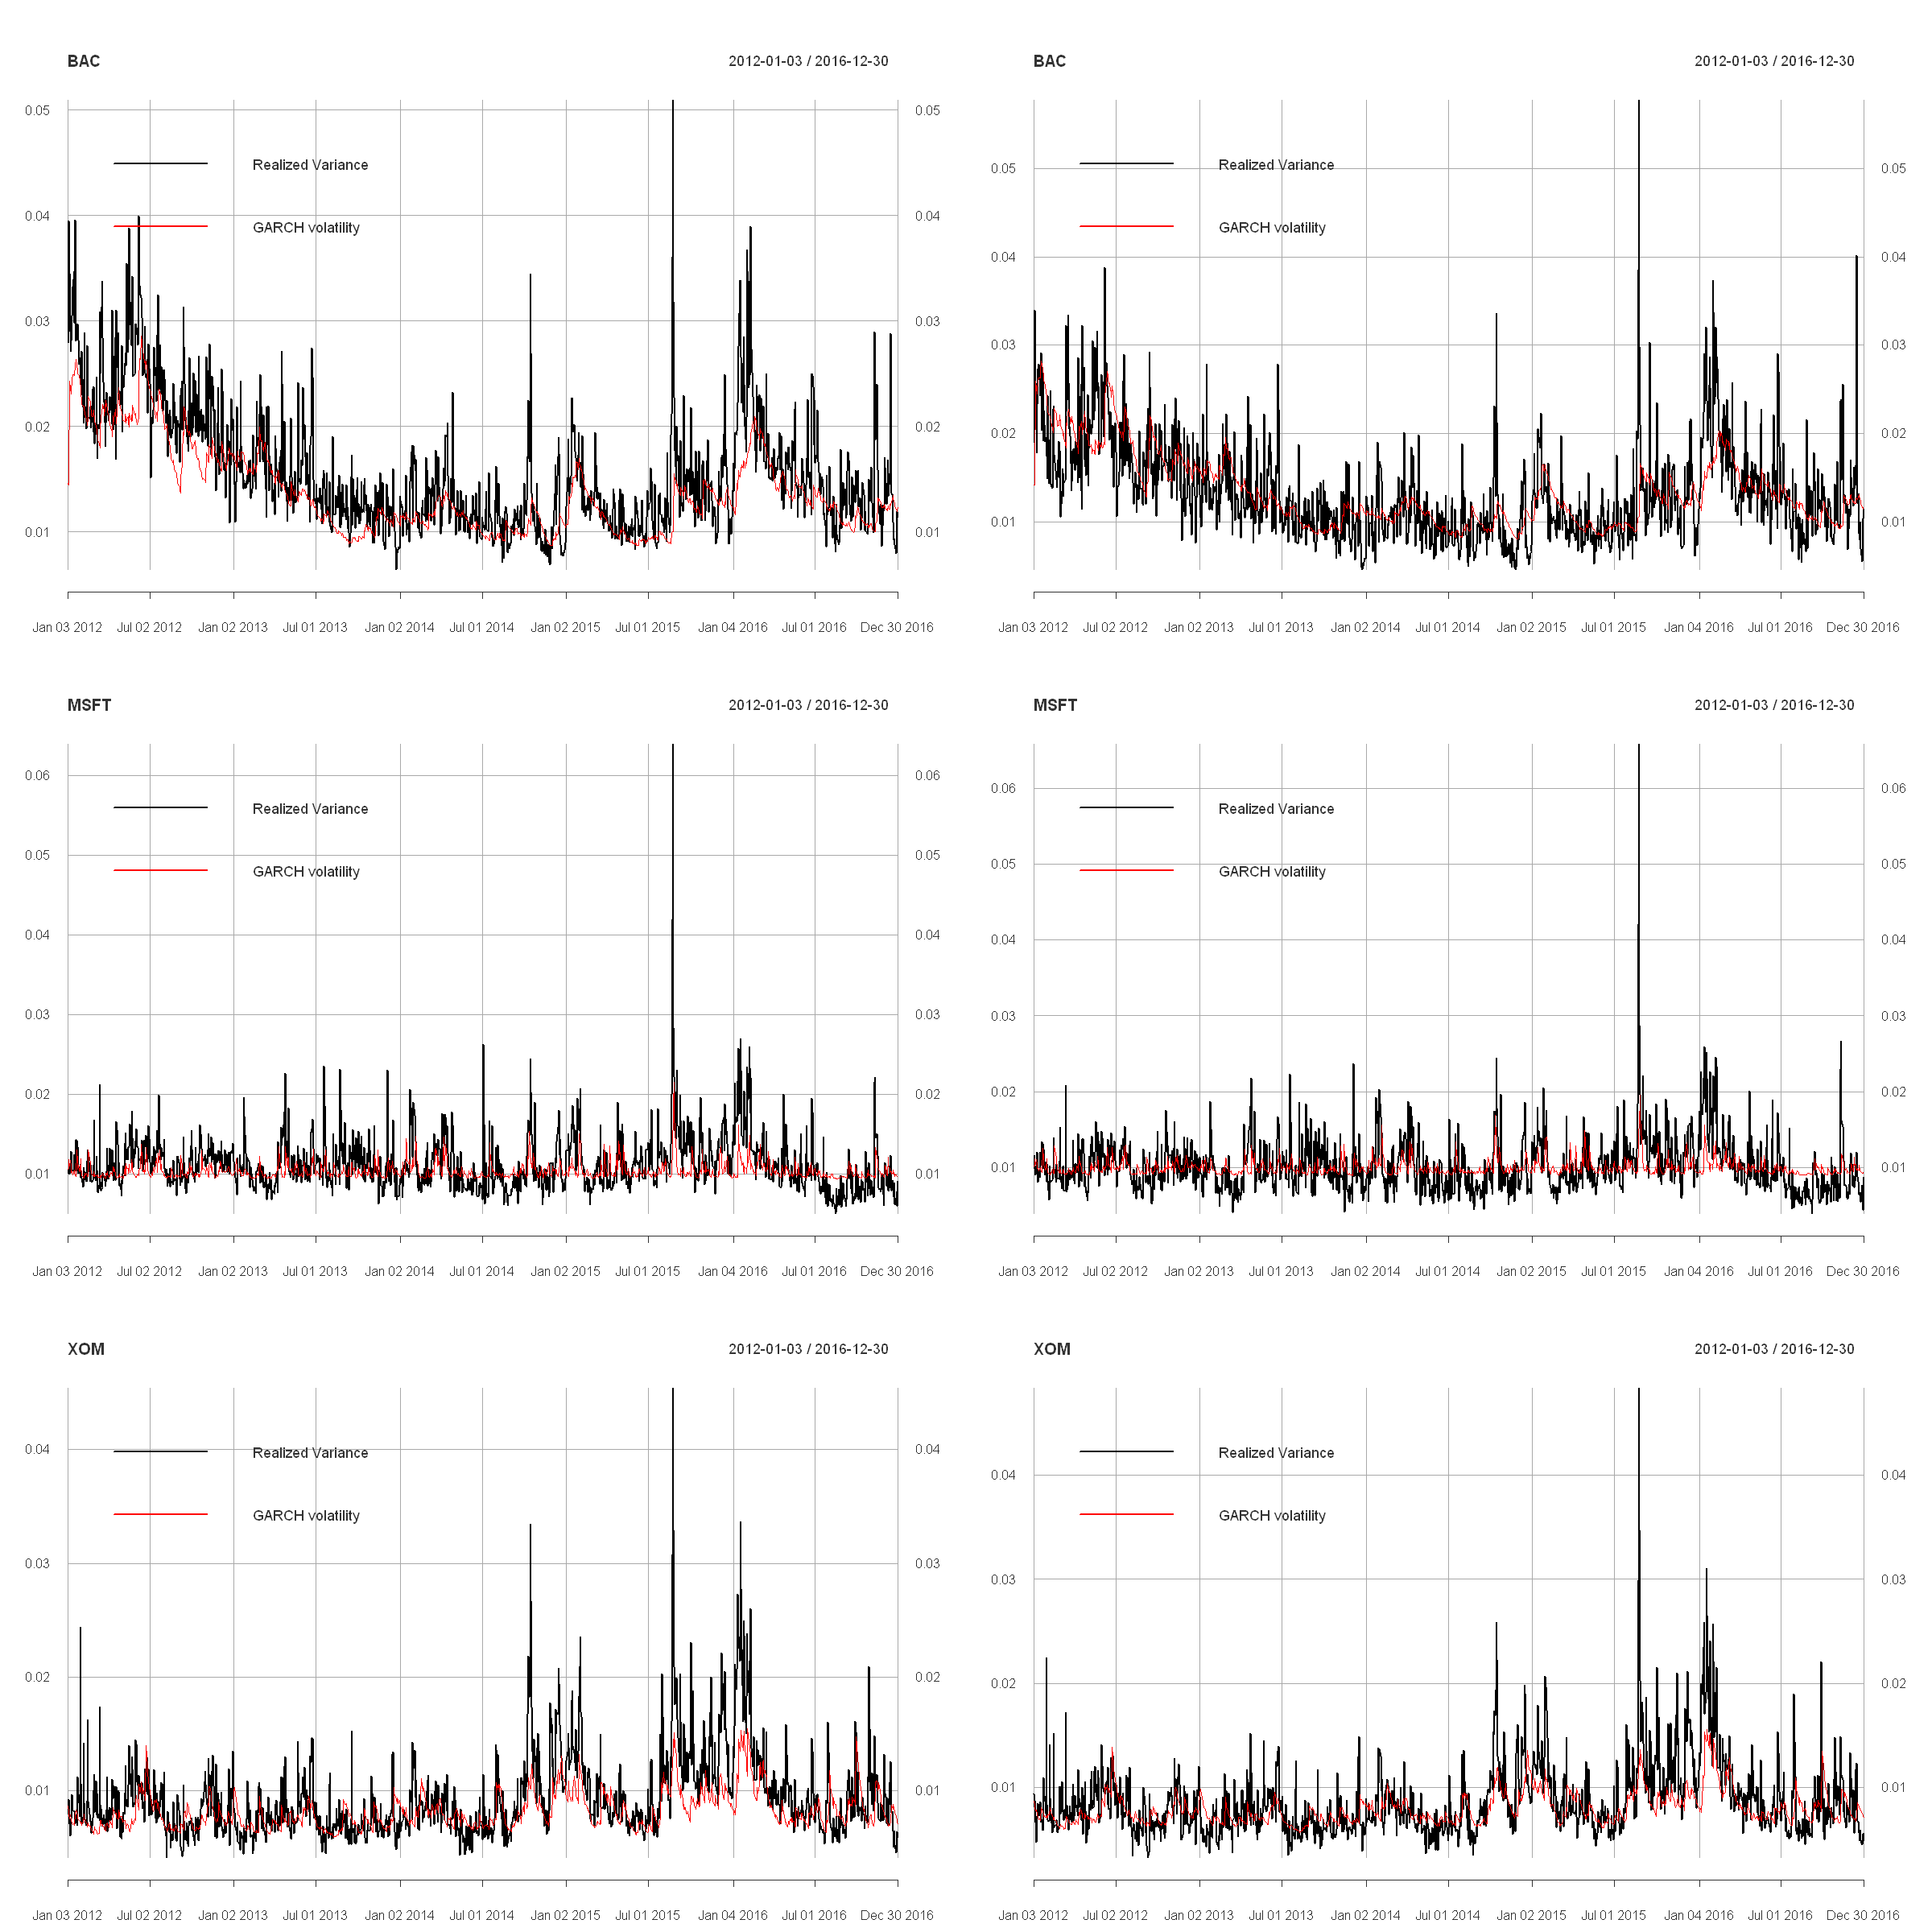

In [110]:
#Realized Volatility vs. GARCH volatility
options(repr.plot.width = 20, repr.plot.height = 20)
par(mfcol = c(3, 2))
for (i in 1:3) {
    plot_holder <- plot(sqrt(to.daily(real_var_from_returns[[i]], OHLC = F)), main = stock_names[i])
    plot_holder <- lines(sigma(garch_models[[i]]), col = "red")
    plot_holder <- addLegend("topleft", on = 1, legend.names = c("Realized Variance", "GARCH volatility"), col = c("black", "red"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}
for (i in 1:3) {
    plot_holder <- plot(sqrt(to.daily(real_var_from_5min_returns[[i]], OHLC = F)), main = stock_names[i])
    plot_holder <- lines(sigma(garch_models_5min[[i]]), col = "red")
    plot_holder <- addLegend("topleft", on = 1, legend.names = c("Realized Variance", "GARCH volatility"), col = c("black", "red"), lty = 1, bty = "n", lwd = 2)
    print(plot_holder)
}